In [ ]:
import json
import numpy as np
import traceback

# 数据预处理

In [ ]:
def convert_example(examples:dict,tokenizer,max_source_seq_len:int,max_target_seq_len:int):
    tokenized_output={
        'input_ids':[],
        'attention_mask':[],
        'decoder_input_ids':[],
        'labels':[]
    }
    for example in examples['text']:
        try:
            example=json.loads(example)
            question=example['question']
            context=example['context']
            answer=example['answer']

            input_seq=f'问题:{question}{tokenizer.sep_token}原文{context}'
            output_seq=f'答案:{answer}{tokenizer.eos_token}'

            output_ids=tokenizer.encode(
                text=output_seq,
                truncation=True,
                max_length=max_target_seq_len
            )
            decoder_input_ids=output_ids[:-2]

            decoder_input_ids=decoder_input_ids+[tokenizer.pad_token_id]*(max_target_seq_len-len(decoder_input_ids))
            lables=output_ids[1:-1]
            lables=lables+[-100]*(max_target_seq_len-len(lables))

            inputs=tokenizer(
                text=input_seq,
                truncation=True,
                max_length=max_source_seq_len,
                padding='max_length'
            )
        except:
            print(f'"{example}" -> {traceback.format_exc()}')
            continue
        tokenized_output['input_ids'].append(inputs['input_ids'])
        tokenized_output['attention_mask'].append(inputs['attention_mask'])
        tokenized_output['decoder_input_ids'].append(decoder_input_ids)
        tokenized_output['labels'].append(lables)

    for k,v in tokenized_output.items():
        tokenized_output[k]=np.array(v)

    return tokenized_output

In [ ]:
from rich import print
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("uer/t5-small-chinese-cluecorpussmall")
tokenizer.eos_token = tokenizer.sep_token
tokenizer.bos_token = tokenizer.cls_token

res = convert_example({
            "text": [
                "{\"context\": \"年基准利率4.35%。从实际看\", \"answer\": \"年基准利率4.35%\", \"question\": \"2017年银行贷款基准利率\"}"
            ]
        },
        tokenizer=tokenizer,
        max_source_seq_len=50,
        max_target_seq_len=20
)
print(res)
print('input_ids: ', tokenizer.convert_ids_to_tokens(res['input_ids'][0]))
print('decoder_input_ids: ', tokenizer.convert_ids_to_tokens(res['decoder_input_ids'][0]))
print('labels: ', tokenizer.convert_ids_to_tokens(res['labels'][0]))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{
    'input_ids': array([[ 101, 7309, 7579,  131, 8109, 2399, 7213, 6121, 6587, 3621, 1825,
        1114, 1164, 4372,  102, 1333, 3152, 2399, 1825, 1114, 1164, 4372,
         125,  119, 8198,  110,  511,  794, 2141, 7354, 4692,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]]),
    'attention_mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]]),
    'decoder_input_ids': array([[ 101, 5031, 3428,  131, 2399, 1825, 1114, 1164, 4372,  125,  119,
        8198,  110,    0,    0,    0,    0,    0,    0,    0]]),
    'labels': array([[5031, 3428,  131, 2399, 1825, 1114, 1164, 4372,  125,  119, 8198,
         110,  102, -100, -100, -100, -100, -100, -100, -100]])
}

input_ids: 
[
    '[CLS]',
    '问',
    '题',
    ':',
    '2017',
    '年',
    '银',
    '行',
    '贷',
    '款',
    '基',
    '准',
    '利',
    '率',
    '[SEP]',
    '原',
    '文',
    '年',
    '基',
    '准',
    '利',
    '率',
    '4',
    '.',
    '35',
    '%',
    '。',
    '从',
    '实',
    '际',
    '看',
    '[SEP]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]'
]

decoder_input_ids: 
[
    '[CLS]',
    '答',
    '案',
    ':',
    '年',
    '基',
    '准',
    '利',
    '率',
    '4',
    '.',
    '35',
    '%',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]',
    '[PAD]'
]

labels: 
[
    '答',
    '案',
    ':',
    '年',
    '基',
    '准',
    '利',
    '率',
    '4',
    '.',
    '35',
    '%',
    '[SEP]',
    '[UNK]',
    '[UNK]',
    '[UNK]',
    '[UNK]',
    '[UNK]',
    '[UNK]',
    '[UNK]'
]

# 定义评估指标BLEU

In [ ]:
import sys
import math
from typing import List
from collections import defaultdict

import numpy as np


def default_trans_func(output, label, seq_mask, vocab):
    seq_mask = np.expand_dims(seq_mask, axis=2).repeat(output.shape[2], axis=2)
    output = output * seq_mask
    idx = np.argmax(output, axis=2)
    prediction, references = [], []
    for i in range(idx.shape[0]):
        token_list = []
        for j in range(idx.shape[1]):
            if seq_mask[i][j][0] == 0:
                break
            token_list.append(vocab[idx[i][j]])
        prediction.append(token_list)

    label = np.squeeze(label, axis=2)
    for i in range(label.shape[0]):
        token_list = []
        for j in range(label.shape[1]):
            if seq_mask[i][j][0] == 0:
                break
            token_list.append(vocab[label[i][j]])

        references.append([token_list])
    return prediction, references


def get_match_size(prediction_ngram, refs_ngram):
    ref_set = defaultdict(int)
    for ref_ngram in refs_ngram:
        tmp_ref_set = defaultdict(int)
        for ngram in ref_ngram:
            tmp_ref_set[tuple(ngram)] += 1
        for ngram, count in tmp_ref_set.items():
            ref_set[tuple(ngram)] = max(ref_set[tuple(ngram)], count)
    prediction_set = defaultdict(int)
    for ngram in prediction_ngram:
        prediction_set[tuple(ngram)] += 1
    match_size = 0
    for ngram, count in prediction_set.items():
        match_size += min(count, ref_set.get(tuple(ngram), 0))
    prediction_size = len(prediction_ngram)
    return match_size, prediction_size


def get_ngram(sent, n_size, label=None):
    def _ngram(sent, n_size):
        ngram_list = []
        for left in range(len(sent) - n_size):
            ngram_list.append(sent[left : left + n_size + 1])
        return ngram_list

    ngram_list = _ngram(sent, n_size)
    if label is not None:
        ngram_list = [ngram + "_" + label for ngram in ngram_list]
    return ngram_list


class BLEU(object):
    def __init__(self, trans_func=None, vocab=None, n_size=4, name="bleu"):
        super().__init__()
        weights = [1 / n_size for _ in range(n_size)]
        self._name = name
        self.match_ngram = {}
        self.prediction_ngram = {}
        self.weights = weights
        self.bp_r = 0
        self.bp_c = 0
        self.n_size = n_size
        self.vocab = vocab
        self.trans_func = trans_func

    def update(self, output, label, seq_mask=None):
        if self.trans_func is None:
            if self.vocab is None:
                raise AttributeError(
                    "The `update` method requires users to provide `trans_func` or `vocab` when initializing BLEU."
                )
            prediction_list, references = default_trans_func(output, label, seq_mask=seq_mask, vocab=self.vocab)
        else:
            prediction_list, references = self.trans_func(output, label, seq_mask)
        if len(prediction_list) != len(references):
            raise ValueError("Length error! Please check the output of network.")
        for i in range(len(prediction_list)):
            self.add_inst(prediction_list[i], references[i])

    def add_instance(self, prediction: List[str], references: List[List[str]]):
        for n_size in range(self.n_size):
            self.count_ngram(prediction, references, n_size)
        self.count_bp(prediction, references)

    def count_ngram(self, prediction, references, n_size):
        prediction_ngram = get_ngram(prediction, n_size)
        refs_ngram = []
        for ref in references:
            refs_ngram.append(get_ngram(ref, n_size))
        if n_size not in self.match_ngram:
            self.match_ngram[n_size] = 0
            self.prediction_ngram[n_size] = 0
        match_size, prediction_size = get_match_size(prediction_ngram, refs_ngram)

        self.match_ngram[n_size] += match_size
        self.prediction_ngram[n_size] += prediction_size

    def count_bp(self, prediction, references):
        self.bp_c += len(prediction)
        self.bp_r += min([(abs(len(prediction) - len(ref)), len(ref)) for ref in references])[1]

    def reset(self):
        self.match_ngram = {}
        self.prediction_ngram = {}
        self.bp_r = 0
        self.bp_c = 0

    def accumulate(self):
        prob_list = []
        for n_size in range(self.n_size):
            try:
                if self.prediction_ngram[n_size] == 0:
                    _score = 0.0
                else:
                    _score = self.match_ngram[n_size] / float(self.prediction_ngram[n_size])
            except:
                _score = 0
            if _score == 0:
                _score = sys.float_info.min
            prob_list.append(_score)

        logs = math.fsum(w_i * math.log(p_i) for w_i, p_i in zip(self.weights, prob_list))
        bp = math.exp(min(1 - self.bp_r / float(self.bp_c), 0))
        bleu = bp * math.exp(logs)
        return bleu

    def compute(self):
        return self.accumulate()

    def name(self):
        return self._name

In [ ]:
!pip install datasets
import os
import time
from functools import partial

import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, T5ForConditionalGeneration, default_data_collator, get_scheduler
from iTrainingLogger import iSummaryWriter

class Args:
    pretrained_model = "uer/t5-base-chinese-cluecorpussmall"
    train_path = "DuReaderQG/train.json"
    dev_path = "DuReaderQG/dev.json"
    save_dir = "checkpoints/DuReaderQG"
    max_source_seq_len = 128
    max_target_seq_len = 16
    batch_size = 32
    learning_rate = 5e-5
    weight_decay = 0.0
    num_train_epochs = 50
    warmup_ratio = 0.06
    valid_steps = 1000
    logging_steps = 10
    device = "cuda:0"
    img_log_dir = "logs/DuReaderQG"
    img_log_name = "T5-Base-Chinese"
    num_labels = 2

args = Args()

writer = iSummaryWriter(log_path=args.img_log_dir, log_name=args.img_log_name)

In [ ]:
from datasets import load_metric

def evaluate_model(model, data_loader):
    """
    在测试集上评估当前模型的训练效果。

    Args:
        model: 当前模型
        data_loader: 测试集的dataloader
    """
    bleu_metric = load_metric("bleu")
    model.eval()

    with torch.no_grad():
        for batch in data_loader:
            outputs = model.generate(input_ids=batch['input_ids'].to(args.device))

            predictions = [pred.tolist() for pred in outputs]
            references = [[ref.tolist()] for ref in batch['labels']]

            bleu_metric.add_batch(predictions=predictions, references=references)

    bleu_scores = bleu_metric.compute()["bleu"]
    model.train()
    return bleu_scores


In [ ]:
def train():
    # 加载模型和tokenizer
    model = T5ForConditionalGeneration.from_pretrained(args.pretrained_model)
    tokenizer = AutoTokenizer.from_pretrained(args.pretrained_model)
    tokenizer.eos_token = tokenizer.sep_token
    tokenizer.bos_token = tokenizer.cls_token

    # 加载并预处理数据集
    dataset = load_dataset('text', data_files={'train': args.train_path, 'dev': args.dev_path})
    convert_func = partial(convert_example, tokenizer=tokenizer,
                           max_source_seq_len=args.max_source_seq_len,
                           max_target_seq_len=args.max_target_seq_len)
    dataset = dataset.map(convert_func, batched=True)
    train_dataloader = DataLoader(dataset['train'], shuffle=True, collate_fn=default_data_collator, batch_size=args.batch_size)
    eval_dataloader = DataLoader(dataset['dev'], collate_fn=default_data_collator, batch_size=args.batch_size)

    # 设置优化器和学习率调度器
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         "weight_decay": args.weight_decay},
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
         "weight_decay": 0.0}
    ]
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=args.learning_rate)
    model.to(args.device)

    # 计算训练步骤和学习率调度
    max_train_steps = args.num_train_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                                 num_warmup_steps=int(args.warmup_ratio * max_train_steps),
                                 num_training_steps=max_train_steps)

    # 训练主循环
    loss_list = []
    tic_train = time.time()
    global_step, best_bleu4 = 0, 0
    for epoch in range(args.num_train_epochs):
        model.train()
        for batch in train_dataloader:
            outputs = model(
                input_ids=batch['input_ids'].to(args.device),
                attention_mask=batch['attention_mask'].to(args.device),
                decoder_input_ids=batch['decoder_input_ids'].to(args.device),
                labels=batch['labels'].to(args.device)
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            global_step += 1
            if global_step % args.logging_steps == 0:
                time_diff = time.time() - tic_train
                loss_avg = sum(loss_list) / len(loss_list)
                writer.add_scalar('train/train_loss', loss_avg, global_step)
                print("global step %d, epoch: %d, loss: %.5f, speed: %.2f step/s"
                        % (global_step, epoch, loss_avg, args.logging_steps / time_diff))
                tic_train = time.time()

            if global_step % args.valid_steps == 0:
                cur_save_dir = os.path.join(args.save_dir, "model_%d" % global_step)
                if not os.path.exists(cur_save_dir):
                    os.makedirs(cur_save_dir)
                model.save_pretrained(os.path.join(cur_save_dir))
                tokenizer.save_pretrained(os.path.join(cur_save_dir))

                bleu1, bleu2, bleu3, bleu4 = evaluate_model(model, eval_dataloader)
                writer.add_scalar('eval/bleu-size-1', bleu1, global_step)
                writer.add_scalar('eval/bleu-size-2', bleu2, global_step)
                writer.add_scalar('eval/bleu-size-3', bleu3, global_step)
                writer.add_scalar('eval/bleu-size-4', bleu4, global_step)
                writer.record()

                print("Evaluation bleu4: %.5f" % (bleu4))
                if bleu4 > best_bleu4:
                    print(
                        f"best BLEU-4 performence has been updated: {best_bleu4:.5f} --> {bleu4:.5f}"
                    )
                    best_bleu4 = bleu4
                    cur_save_dir = os.path.join(args.save_dir, "model_best")
                    if not os.path.exists(cur_save_dir):
                        os.makedirs(cur_save_dir)
                    model.save_pretrained(os.path.join(cur_save_dir))
                    tokenizer.save_pretrained(os.path.join(cur_save_dir))
                tic_train = time.time()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 14520
    })
    dev: Dataset({
        features: ['text'],
        num_rows: 984
    })
})

Map:   0%|          | 0/14520 [00:00<?, ? examples/s]

Map:   0%|          | 0/984 [00:00<?, ? examples/s]

global step 10, epoch: 1, loss: 9.40390, speed: 4.35 step/s

global step 20, epoch: 1, loss: 9.40389, speed: 4.41 step/s

global step 30, epoch: 1, loss: 9.40114, speed: 4.42 step/s

global step 40, epoch: 1, loss: 9.40029, speed: 4.42 step/s

global step 50, epoch: 1, loss: 9.39780, speed: 4.42 step/s

global step 60, epoch: 1, loss: 9.39402, speed: 4.41 step/s

global step 70, epoch: 1, loss: 9.38969, speed: 4.40 step/s

global step 80, epoch: 1, loss: 9.38418, speed: 4.41 step/s

global step 90, epoch: 1, loss: 9.37800, speed: 4.32 step/s

global step 100, epoch: 1, loss: 9.36938, speed: 4.42 step/s

global step 110, epoch: 1, loss: 9.35906, speed: 4.42 step/s

global step 120, epoch: 1, loss: 9.34696, speed: 4.42 step/s

global step 130, epoch: 1, loss: 9.33189, speed: 4.42 step/s

global step 140, epoch: 1, loss: 9.31198, speed: 4.42 step/s

global step 150, epoch: 1, loss: 9.28399, speed: 4.42 step/s

global step 160, epoch: 1, loss: 9.24614, speed: 4.42 step/s

global step 170, epoch: 1, loss: 9.20180, speed: 4.42 step/s

global step 180, epoch: 1, loss: 9.15239, speed: 4.42 step/s

global step 190, epoch: 1, loss: 9.10264, speed: 4.42 step/s

global step 200, epoch: 1, loss: 9.05211, speed: 4.42 step/s

global step 210, epoch: 1, loss: 9.00036, speed: 4.42 step/s

global step 220, epoch: 1, loss: 8.94792, speed: 4.42 step/s

global step 230, epoch: 1, loss: 8.89528, speed: 4.42 step/s

global step 240, epoch: 1, loss: 8.84513, speed: 4.42 step/s

global step 250, epoch: 1, loss: 8.79469, speed: 4.41 step/s

global step 260, epoch: 1, loss: 8.74680, speed: 4.42 step/s

global step 270, epoch: 1, loss: 8.70006, speed: 4.42 step/s

global step 280, epoch: 1, loss: 8.65294, speed: 4.42 step/s

global step 290, epoch: 1, loss: 8.60790, speed: 4.42 step/s

global step 300, epoch: 1, loss: 8.56337, speed: 4.42 step/s

global step 310, epoch: 1, loss: 8.51904, speed: 4.42 step/s

global step 320, epoch: 1, loss: 8.47388, speed: 4.42 step/s

global step 330, epoch: 1, loss: 8.43213, speed: 4.42 step/s

global step 340, epoch: 1, loss: 8.39056, speed: 4.42 step/s

global step 350, epoch: 1, loss: 8.34745, speed: 4.42 step/s

global step 360, epoch: 1, loss: 8.30638, speed: 4.42 step/s

global step 370, epoch: 1, loss: 8.26627, speed: 4.40 step/s

global step 380, epoch: 1, loss: 8.22660, speed: 4.43 step/s

global step 390, epoch: 1, loss: 8.18840, speed: 4.43 step/s

global step 400, epoch: 1, loss: 8.14896, speed: 4.42 step/s

global step 410, epoch: 1, loss: 8.11030, speed: 4.42 step/s

global step 420, epoch: 1, loss: 8.07299, speed: 4.42 step/s

global step 430, epoch: 1, loss: 8.03621, speed: 4.42 step/s

global step 440, epoch: 1, loss: 7.99877, speed: 4.41 step/s

global step 450, epoch: 1, loss: 7.96224, speed: 4.42 step/s

global step 460, epoch: 2, loss: 7.92598, speed: 4.52 step/s

global step 470, epoch: 2, loss: 7.89110, speed: 4.42 step/s

global step 480, epoch: 2, loss: 7.85623, speed: 4.42 step/s

global step 490, epoch: 2, loss: 7.82120, speed: 4.42 step/s

global step 500, epoch: 2, loss: 7.78753, speed: 4.42 step/s

global step 510, epoch: 2, loss: 7.75399, speed: 4.42 step/s

global step 520, epoch: 2, loss: 7.72107, speed: 4.42 step/s

global step 530, epoch: 2, loss: 7.68741, speed: 4.42 step/s

global step 540, epoch: 2, loss: 7.65481, speed: 4.42 step/s

global step 550, epoch: 2, loss: 7.62144, speed: 4.42 step/s

global step 560, epoch: 2, loss: 7.58950, speed: 4.42 step/s

global step 570, epoch: 2, loss: 7.55811, speed: 4.42 step/s

global step 580, epoch: 2, loss: 7.52691, speed: 4.42 step/s

global step 590, epoch: 2, loss: 7.49639, speed: 4.42 step/s

global step 600, epoch: 2, loss: 7.46587, speed: 4.42 step/s

global step 610, epoch: 2, loss: 7.43580, speed: 4.43 step/s

global step 620, epoch: 2, loss: 7.40488, speed: 4.43 step/s

global step 630, epoch: 2, loss: 7.37577, speed: 4.42 step/s

global step 640, epoch: 2, loss: 7.34666, speed: 4.42 step/s

global step 650, epoch: 2, loss: 7.31787, speed: 4.42 step/s

global step 660, epoch: 2, loss: 7.28902, speed: 4.42 step/s

global step 670, epoch: 2, loss: 7.25986, speed: 4.42 step/s

global step 680, epoch: 2, loss: 7.23099, speed: 4.43 step/s

global step 690, epoch: 2, loss: 7.20336, speed: 4.43 step/s

global step 700, epoch: 2, loss: 7.17624, speed: 4.42 step/s

global step 710, epoch: 2, loss: 7.14912, speed: 4.42 step/s

global step 720, epoch: 2, loss: 7.12368, speed: 4.42 step/s

global step 730, epoch: 2, loss: 7.09678, speed: 4.42 step/s

global step 740, epoch: 2, loss: 7.07085, speed: 4.42 step/s

global step 750, epoch: 2, loss: 7.04478, speed: 4.42 step/s

global step 760, epoch: 2, loss: 7.01912, speed: 4.42 step/s

global step 770, epoch: 2, loss: 6.99432, speed: 4.42 step/s

global step 780, epoch: 2, loss: 6.96977, speed: 4.42 step/s

global step 790, epoch: 2, loss: 6.94578, speed: 4.42 step/s

global step 800, epoch: 2, loss: 6.92164, speed: 4.41 step/s

global step 810, epoch: 2, loss: 6.89747, speed: 4.42 step/s

global step 820, epoch: 2, loss: 6.87366, speed: 4.42 step/s

global step 830, epoch: 2, loss: 6.85047, speed: 4.42 step/s

global step 840, epoch: 2, loss: 6.82646, speed: 4.42 step/s

global step 850, epoch: 2, loss: 6.80340, speed: 4.42 step/s

global step 860, epoch: 2, loss: 6.78028, speed: 4.42 step/s

global step 870, epoch: 2, loss: 6.75796, speed: 4.42 step/s

global step 880, epoch: 2, loss: 6.73604, speed: 4.42 step/s

global step 890, epoch: 2, loss: 6.71327, speed: 4.42 step/s

global step 900, epoch: 2, loss: 6.69069, speed: 4.42 step/s

global step 910, epoch: 3, loss: 6.66854, speed: 4.48 step/s

global step 920, epoch: 3, loss: 6.64701, speed: 4.42 step/s

global step 930, epoch: 3, loss: 6.62660, speed: 4.42 step/s

global step 940, epoch: 3, loss: 6.60498, speed: 4.42 step/s

global step 950, epoch: 3, loss: 6.58418, speed: 4.42 step/s

global step 960, epoch: 3, loss: 6.56385, speed: 4.42 step/s

global step 970, epoch: 3, loss: 6.54336, speed: 4.42 step/s

global step 980, epoch: 3, loss: 6.52330, speed: 4.42 step/s

global step 990, epoch: 3, loss: 6.50328, speed: 4.42 step/s

global step 1000, epoch: 3, loss: 6.48336, speed: 4.42 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.00663

best BLEU-4 performence has been updated: 0.00000 --> 0.00663

global step 1010, epoch: 3, loss: 6.49084, speed: 4.28 step/s

global step 1020, epoch: 3, loss: 6.49276, speed: 4.32 step/s

global step 1030, epoch: 3, loss: 6.49231, speed: 4.33 step/s

global step 1040, epoch: 3, loss: 6.49053, speed: 4.33 step/s

global step 1050, epoch: 3, loss: 6.48721, speed: 4.32 step/s

global step 1060, epoch: 3, loss: 6.48372, speed: 4.33 step/s

global step 1070, epoch: 3, loss: 6.47890, speed: 4.32 step/s

global step 1080, epoch: 3, loss: 6.47344, speed: 4.33 step/s

global step 1090, epoch: 3, loss: 6.46733, speed: 4.33 step/s

global step 1100, epoch: 3, loss: 6.46153, speed: 4.33 step/s

global step 1110, epoch: 3, loss: 6.45544, speed: 4.33 step/s

global step 1120, epoch: 3, loss: 6.44839, speed: 4.33 step/s

global step 1130, epoch: 3, loss: 6.44104, speed: 4.33 step/s

global step 1140, epoch: 3, loss: 6.43380, speed: 4.33 step/s

global step 1150, epoch: 3, loss: 6.42647, speed: 4.33 step/s

global step 1160, epoch: 3, loss: 6.41844, speed: 4.33 step/s

global step 1170, epoch: 3, loss: 6.40996, speed: 4.33 step/s

global step 1180, epoch: 3, loss: 6.40196, speed: 4.33 step/s

global step 1190, epoch: 3, loss: 6.39325, speed: 4.33 step/s

global step 1200, epoch: 3, loss: 6.38461, speed: 4.33 step/s

global step 1210, epoch: 3, loss: 6.37622, speed: 4.33 step/s

global step 1220, epoch: 3, loss: 6.36756, speed: 4.33 step/s

global step 1230, epoch: 3, loss: 6.35904, speed: 4.33 step/s

global step 1240, epoch: 3, loss: 6.35003, speed: 4.33 step/s

global step 1250, epoch: 3, loss: 6.34103, speed: 4.33 step/s

global step 1260, epoch: 3, loss: 6.33162, speed: 4.33 step/s

global step 1270, epoch: 3, loss: 6.32236, speed: 4.33 step/s

global step 1280, epoch: 3, loss: 6.31352, speed: 4.33 step/s

global step 1290, epoch: 3, loss: 6.30442, speed: 4.33 step/s

global step 1300, epoch: 3, loss: 6.29562, speed: 4.33 step/s

global step 1310, epoch: 3, loss: 6.28609, speed: 4.33 step/s

global step 1320, epoch: 3, loss: 6.27707, speed: 4.33 step/s

global step 1330, epoch: 3, loss: 6.26703, speed: 4.33 step/s

global step 1340, epoch: 3, loss: 6.25763, speed: 4.33 step/s

global step 1350, epoch: 3, loss: 6.24840, speed: 4.28 step/s

global step 1360, epoch: 3, loss: 6.23885, speed: 4.33 step/s

global step 1370, epoch: 4, loss: 6.22947, speed: 4.43 step/s

global step 1380, epoch: 4, loss: 6.22031, speed: 4.33 step/s

global step 1390, epoch: 4, loss: 6.21088, speed: 4.33 step/s

global step 1400, epoch: 4, loss: 6.20116, speed: 4.33 step/s

global step 1410, epoch: 4, loss: 6.19154, speed: 4.33 step/s

global step 1420, epoch: 4, loss: 6.18197, speed: 4.33 step/s

global step 1430, epoch: 4, loss: 6.17281, speed: 4.33 step/s

global step 1440, epoch: 4, loss: 6.16300, speed: 4.33 step/s

global step 1450, epoch: 4, loss: 6.15414, speed: 4.33 step/s

global step 1460, epoch: 4, loss: 6.14470, speed: 4.33 step/s

global step 1470, epoch: 4, loss: 6.13521, speed: 4.33 step/s

global step 1480, epoch: 4, loss: 6.12607, speed: 4.33 step/s

global step 1490, epoch: 4, loss: 6.11720, speed: 4.32 step/s

global step 1500, epoch: 4, loss: 6.10817, speed: 4.33 step/s

global step 1510, epoch: 4, loss: 6.09929, speed: 4.33 step/s

global step 1520, epoch: 4, loss: 6.08985, speed: 4.33 step/s

global step 1530, epoch: 4, loss: 6.08020, speed: 4.33 step/s

global step 1540, epoch: 4, loss: 6.07134, speed: 4.33 step/s

global step 1550, epoch: 4, loss: 6.06232, speed: 4.33 step/s

global step 1560, epoch: 4, loss: 6.05291, speed: 4.33 step/s

global step 1570, epoch: 4, loss: 6.04343, speed: 4.33 step/s

global step 1580, epoch: 4, loss: 6.03421, speed: 4.33 step/s

global step 1590, epoch: 4, loss: 6.02495, speed: 4.33 step/s

global step 1600, epoch: 4, loss: 6.01606, speed: 4.33 step/s

global step 1610, epoch: 4, loss: 6.00709, speed: 4.33 step/s

global step 1620, epoch: 4, loss: 5.99827, speed: 4.33 step/s

global step 1630, epoch: 4, loss: 5.98947, speed: 4.32 step/s

global step 1640, epoch: 4, loss: 5.98061, speed: 4.33 step/s

global step 1650, epoch: 4, loss: 5.97123, speed: 4.33 step/s

global step 1660, epoch: 4, loss: 5.96245, speed: 4.33 step/s

global step 1670, epoch: 4, loss: 5.95362, speed: 4.33 step/s

global step 1680, epoch: 4, loss: 5.94470, speed: 4.33 step/s

global step 1690, epoch: 4, loss: 5.93587, speed: 4.33 step/s

global step 1700, epoch: 4, loss: 5.92729, speed: 4.33 step/s

global step 1710, epoch: 4, loss: 5.91844, speed: 4.33 step/s

global step 1720, epoch: 4, loss: 5.90966, speed: 4.33 step/s

global step 1730, epoch: 4, loss: 5.90096, speed: 4.33 step/s

global step 1740, epoch: 4, loss: 5.89289, speed: 4.32 step/s

global step 1750, epoch: 4, loss: 5.88392, speed: 4.33 step/s

global step 1760, epoch: 4, loss: 5.87566, speed: 4.33 step/s

global step 1770, epoch: 4, loss: 5.86699, speed: 4.33 step/s

global step 1780, epoch: 4, loss: 5.85801, speed: 4.33 step/s

global step 1790, epoch: 4, loss: 5.84970, speed: 4.33 step/s

global step 1800, epoch: 4, loss: 5.84117, speed: 4.33 step/s

global step 1810, epoch: 4, loss: 5.83310, speed: 4.33 step/s

global step 1820, epoch: 5, loss: 5.82480, speed: 4.43 step/s

global step 1830, epoch: 5, loss: 5.81707, speed: 4.33 step/s

global step 1840, epoch: 5, loss: 5.80910, speed: 4.33 step/s

global step 1850, epoch: 5, loss: 5.80097, speed: 4.33 step/s

global step 1860, epoch: 5, loss: 5.79282, speed: 4.33 step/s

global step 1870, epoch: 5, loss: 5.78455, speed: 4.33 step/s

global step 1880, epoch: 5, loss: 5.77640, speed: 4.33 step/s

global step 1890, epoch: 5, loss: 5.76813, speed: 4.33 step/s

global step 1900, epoch: 5, loss: 5.75978, speed: 4.32 step/s

global step 1910, epoch: 5, loss: 5.75163, speed: 4.33 step/s

global step 1920, epoch: 5, loss: 5.74340, speed: 4.33 step/s

global step 1930, epoch: 5, loss: 5.73554, speed: 4.33 step/s

global step 1940, epoch: 5, loss: 5.72751, speed: 4.33 step/s

global step 1950, epoch: 5, loss: 5.71989, speed: 4.33 step/s

global step 1960, epoch: 5, loss: 5.71196, speed: 4.33 step/s

global step 1970, epoch: 5, loss: 5.70411, speed: 4.33 step/s

global step 1980, epoch: 5, loss: 5.69605, speed: 4.33 step/s

global step 1990, epoch: 5, loss: 5.68860, speed: 4.33 step/s

global step 2000, epoch: 5, loss: 5.68058, speed: 4.33 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.12024

best BLEU-4 performence has been updated: 0.00663 --> 0.12024

global step 2010, epoch: 5, loss: 5.67282, speed: 4.27 step/s

global step 2020, epoch: 5, loss: 5.66516, speed: 4.32 step/s

global step 2030, epoch: 5, loss: 5.65736, speed: 4.32 step/s

global step 2040, epoch: 5, loss: 5.64951, speed: 4.32 step/s

global step 2050, epoch: 5, loss: 5.64192, speed: 4.32 step/s

global step 2060, epoch: 5, loss: 5.63426, speed: 4.32 step/s

global step 2070, epoch: 5, loss: 5.62705, speed: 4.32 step/s

global step 2080, epoch: 5, loss: 5.61978, speed: 4.32 step/s

global step 2090, epoch: 5, loss: 5.61234, speed: 4.32 step/s

global step 2100, epoch: 5, loss: 5.60458, speed: 4.32 step/s

global step 2110, epoch: 5, loss: 5.59727, speed: 4.32 step/s

global step 2120, epoch: 5, loss: 5.58966, speed: 4.32 step/s

global step 2130, epoch: 5, loss: 5.58238, speed: 4.32 step/s

global step 2140, epoch: 5, loss: 5.57512, speed: 4.33 step/s

global step 2150, epoch: 5, loss: 5.56786, speed: 4.32 step/s

global step 2160, epoch: 5, loss: 5.56085, speed: 4.32 step/s

global step 2170, epoch: 5, loss: 5.55348, speed: 4.32 step/s

global step 2180, epoch: 5, loss: 5.54626, speed: 4.32 step/s

global step 2190, epoch: 5, loss: 5.53913, speed: 4.32 step/s

global step 2200, epoch: 5, loss: 5.53185, speed: 4.33 step/s

global step 2210, epoch: 5, loss: 5.52473, speed: 4.32 step/s

global step 2220, epoch: 5, loss: 5.51774, speed: 4.32 step/s

global step 2230, epoch: 5, loss: 5.51047, speed: 4.32 step/s

global step 2240, epoch: 5, loss: 5.50356, speed: 4.32 step/s

global step 2250, epoch: 5, loss: 5.49642, speed: 4.32 step/s

global step 2260, epoch: 5, loss: 5.48947, speed: 4.32 step/s

global step 2270, epoch: 5, loss: 5.48214, speed: 4.43 step/s

global step 2280, epoch: 6, loss: 5.47524, speed: 4.32 step/s

global step 2290, epoch: 6, loss: 5.46819, speed: 4.33 step/s

global step 2300, epoch: 6, loss: 5.46124, speed: 4.33 step/s

global step 2310, epoch: 6, loss: 5.45453, speed: 4.32 step/s

global step 2320, epoch: 6, loss: 5.44767, speed: 4.32 step/s

global step 2330, epoch: 6, loss: 5.44104, speed: 4.32 step/s

global step 2340, epoch: 6, loss: 5.43443, speed: 4.32 step/s

global step 2350, epoch: 6, loss: 5.42777, speed: 4.32 step/s

global step 2360, epoch: 6, loss: 5.42093, speed: 4.32 step/s

global step 2370, epoch: 6, loss: 5.41421, speed: 4.32 step/s

global step 2380, epoch: 6, loss: 5.40746, speed: 4.32 step/s

global step 2390, epoch: 6, loss: 5.40038, speed: 4.33 step/s

global step 2400, epoch: 6, loss: 5.39374, speed: 4.33 step/s

global step 2410, epoch: 6, loss: 5.38700, speed: 4.32 step/s

global step 2420, epoch: 6, loss: 5.38014, speed: 4.32 step/s

global step 2430, epoch: 6, loss: 5.37376, speed: 4.32 step/s

global step 2440, epoch: 6, loss: 5.36720, speed: 4.32 step/s

global step 2450, epoch: 6, loss: 5.36072, speed: 4.33 step/s

global step 2460, epoch: 6, loss: 5.35413, speed: 4.32 step/s

global step 2470, epoch: 6, loss: 5.34782, speed: 4.32 step/s

global step 2480, epoch: 6, loss: 5.34139, speed: 4.33 step/s

global step 2490, epoch: 6, loss: 5.33468, speed: 4.32 step/s

global step 2500, epoch: 6, loss: 5.32833, speed: 4.32 step/s

global step 2510, epoch: 6, loss: 5.32188, speed: 4.32 step/s

global step 2520, epoch: 6, loss: 5.31512, speed: 4.32 step/s

global step 2530, epoch: 6, loss: 5.30878, speed: 4.32 step/s

global step 2540, epoch: 6, loss: 5.30233, speed: 4.32 step/s

global step 2550, epoch: 6, loss: 5.29618, speed: 4.32 step/s

global step 2560, epoch: 6, loss: 5.28975, speed: 4.32 step/s

global step 2570, epoch: 6, loss: 5.28336, speed: 4.32 step/s

global step 2580, epoch: 6, loss: 5.27693, speed: 4.32 step/s

global step 2590, epoch: 6, loss: 5.27074, speed: 4.32 step/s

global step 2600, epoch: 6, loss: 5.26460, speed: 4.32 step/s

global step 2610, epoch: 6, loss: 5.25849, speed: 4.32 step/s

global step 2620, epoch: 6, loss: 5.25234, speed: 4.32 step/s

global step 2630, epoch: 6, loss: 5.24635, speed: 4.32 step/s

global step 2640, epoch: 6, loss: 5.24033, speed: 4.32 step/s

global step 2650, epoch: 6, loss: 5.23447, speed: 4.30 step/s

global step 2660, epoch: 6, loss: 5.22839, speed: 4.32 step/s

global step 2670, epoch: 6, loss: 5.22206, speed: 4.32 step/s

global step 2680, epoch: 6, loss: 5.21629, speed: 4.32 step/s

global step 2690, epoch: 6, loss: 5.21037, speed: 4.32 step/s

global step 2700, epoch: 6, loss: 5.20446, speed: 4.32 step/s

global step 2710, epoch: 6, loss: 5.19859, speed: 4.32 step/s

global step 2720, epoch: 6, loss: 5.19258, speed: 4.32 step/s

global step 2730, epoch: 7, loss: 5.18670, speed: 4.42 step/s

global step 2740, epoch: 7, loss: 5.18052, speed: 4.32 step/s

global step 2750, epoch: 7, loss: 5.17457, speed: 4.32 step/s

global step 2760, epoch: 7, loss: 5.16864, speed: 4.32 step/s

global step 2770, epoch: 7, loss: 5.16268, speed: 4.30 step/s

global step 2780, epoch: 7, loss: 5.15660, speed: 4.33 step/s

global step 2790, epoch: 7, loss: 5.15097, speed: 4.32 step/s

global step 2800, epoch: 7, loss: 5.14534, speed: 4.32 step/s

global step 2810, epoch: 7, loss: 5.13960, speed: 4.32 step/s

global step 2820, epoch: 7, loss: 5.13390, speed: 4.32 step/s

global step 2830, epoch: 7, loss: 5.12816, speed: 4.32 step/s

global step 2840, epoch: 7, loss: 5.12252, speed: 4.32 step/s

global step 2850, epoch: 7, loss: 5.11651, speed: 4.32 step/s

global step 2860, epoch: 7, loss: 5.11070, speed: 4.22 step/s

global step 2870, epoch: 7, loss: 5.10508, speed: 4.32 step/s

global step 2880, epoch: 7, loss: 5.09932, speed: 4.32 step/s

global step 2890, epoch: 7, loss: 5.09388, speed: 4.33 step/s

global step 2900, epoch: 7, loss: 5.08832, speed: 4.32 step/s

global step 2910, epoch: 7, loss: 5.08293, speed: 4.32 step/s

global step 2920, epoch: 7, loss: 5.07735, speed: 4.32 step/s

global step 2930, epoch: 7, loss: 5.07182, speed: 4.33 step/s

global step 2940, epoch: 7, loss: 5.06619, speed: 4.32 step/s

global step 2950, epoch: 7, loss: 5.06076, speed: 4.32 step/s

global step 2960, epoch: 7, loss: 5.05544, speed: 4.32 step/s

global step 2970, epoch: 7, loss: 5.04982, speed: 4.32 step/s

global step 2980, epoch: 7, loss: 5.04433, speed: 4.32 step/s

global step 2990, epoch: 7, loss: 5.03875, speed: 4.32 step/s

global step 3000, epoch: 7, loss: 5.03308, speed: 4.32 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.09355

global step 3010, epoch: 7, loss: 5.02759, speed: 4.30 step/s

global step 3020, epoch: 7, loss: 5.02224, speed: 4.31 step/s

global step 3030, epoch: 7, loss: 5.01682, speed: 4.32 step/s

global step 3040, epoch: 7, loss: 5.01137, speed: 4.32 step/s

global step 3050, epoch: 7, loss: 5.00596, speed: 4.32 step/s

global step 3060, epoch: 7, loss: 5.00052, speed: 4.32 step/s

global step 3070, epoch: 7, loss: 4.99524, speed: 4.32 step/s

global step 3080, epoch: 7, loss: 4.98968, speed: 4.32 step/s

global step 3090, epoch: 7, loss: 4.98457, speed: 4.32 step/s

global step 3100, epoch: 7, loss: 4.97917, speed: 4.32 step/s

global step 3110, epoch: 7, loss: 4.97393, speed: 4.32 step/s

global step 3120, epoch: 7, loss: 4.96857, speed: 4.32 step/s

global step 3130, epoch: 7, loss: 4.96366, speed: 4.32 step/s

global step 3140, epoch: 7, loss: 4.95855, speed: 4.32 step/s

global step 3150, epoch: 7, loss: 4.95335, speed: 4.32 step/s

global step 3160, epoch: 7, loss: 4.94801, speed: 4.32 step/s

global step 3170, epoch: 7, loss: 4.94300, speed: 4.32 step/s

global step 3180, epoch: 8, loss: 4.93764, speed: 4.42 step/s

global step 3190, epoch: 8, loss: 4.93228, speed: 4.32 step/s

global step 3200, epoch: 8, loss: 4.92705, speed: 4.32 step/s

global step 3210, epoch: 8, loss: 4.92197, speed: 4.32 step/s

global step 3220, epoch: 8, loss: 4.91674, speed: 4.32 step/s

global step 3230, epoch: 8, loss: 4.91184, speed: 4.32 step/s

global step 3240, epoch: 8, loss: 4.90677, speed: 4.32 step/s

global step 3250, epoch: 8, loss: 4.90149, speed: 4.32 step/s

global step 3260, epoch: 8, loss: 4.89656, speed: 4.32 step/s

global step 3270, epoch: 8, loss: 4.89157, speed: 4.32 step/s

global step 3280, epoch: 8, loss: 4.88640, speed: 4.32 step/s

global step 3290, epoch: 8, loss: 4.88132, speed: 4.32 step/s

global step 3300, epoch: 8, loss: 4.87618, speed: 4.32 step/s

global step 3310, epoch: 8, loss: 4.87146, speed: 4.32 step/s

global step 3320, epoch: 8, loss: 4.86622, speed: 4.32 step/s

global step 3330, epoch: 8, loss: 4.86115, speed: 4.32 step/s

global step 3340, epoch: 8, loss: 4.85615, speed: 4.32 step/s

global step 3350, epoch: 8, loss: 4.85118, speed: 4.32 step/s

global step 3360, epoch: 8, loss: 4.84622, speed: 4.32 step/s

global step 3370, epoch: 8, loss: 4.84142, speed: 4.32 step/s

global step 3380, epoch: 8, loss: 4.83636, speed: 4.32 step/s

global step 3390, epoch: 8, loss: 4.83130, speed: 4.32 step/s

global step 3400, epoch: 8, loss: 4.82651, speed: 4.32 step/s

global step 3410, epoch: 8, loss: 4.82169, speed: 4.32 step/s

global step 3420, epoch: 8, loss: 4.81702, speed: 4.32 step/s

global step 3430, epoch: 8, loss: 4.81221, speed: 4.32 step/s

global step 3440, epoch: 8, loss: 4.80731, speed: 4.32 step/s

global step 3450, epoch: 8, loss: 4.80243, speed: 4.32 step/s

global step 3460, epoch: 8, loss: 4.79744, speed: 4.32 step/s

global step 3470, epoch: 8, loss: 4.79228, speed: 4.33 step/s

global step 3480, epoch: 8, loss: 4.78742, speed: 4.32 step/s

global step 3490, epoch: 8, loss: 4.78257, speed: 4.32 step/s

global step 3500, epoch: 8, loss: 4.77768, speed: 4.32 step/s

global step 3510, epoch: 8, loss: 4.77296, speed: 4.32 step/s

global step 3520, epoch: 8, loss: 4.76815, speed: 4.32 step/s

global step 3530, epoch: 8, loss: 4.76323, speed: 4.32 step/s

global step 3540, epoch: 8, loss: 4.75847, speed: 4.32 step/s

global step 3550, epoch: 8, loss: 4.75369, speed: 4.32 step/s

global step 3560, epoch: 8, loss: 4.74910, speed: 4.32 step/s

global step 3570, epoch: 8, loss: 4.74433, speed: 4.32 step/s

global step 3580, epoch: 8, loss: 4.73984, speed: 4.32 step/s

global step 3590, epoch: 8, loss: 4.73506, speed: 4.32 step/s

global step 3600, epoch: 8, loss: 4.73046, speed: 4.32 step/s

global step 3610, epoch: 8, loss: 4.72553, speed: 4.32 step/s

global step 3620, epoch: 8, loss: 4.72075, speed: 4.32 step/s

global step 3630, epoch: 8, loss: 4.71628, speed: 4.32 step/s

global step 3640, epoch: 9, loss: 4.71153, speed: 4.42 step/s

global step 3650, epoch: 9, loss: 4.70681, speed: 4.32 step/s

global step 3660, epoch: 9, loss: 4.70202, speed: 4.32 step/s

global step 3670, epoch: 9, loss: 4.69735, speed: 4.32 step/s

global step 3680, epoch: 9, loss: 4.69262, speed: 4.32 step/s

global step 3690, epoch: 9, loss: 4.68809, speed: 4.32 step/s

global step 3700, epoch: 9, loss: 4.68332, speed: 4.33 step/s

global step 3710, epoch: 9, loss: 4.67870, speed: 4.32 step/s

global step 3720, epoch: 9, loss: 4.67403, speed: 4.32 step/s

global step 3730, epoch: 9, loss: 4.66946, speed: 4.32 step/s

global step 3740, epoch: 9, loss: 4.66485, speed: 4.32 step/s

global step 3750, epoch: 9, loss: 4.66026, speed: 4.32 step/s

global step 3760, epoch: 9, loss: 4.65576, speed: 4.31 step/s

global step 3770, epoch: 9, loss: 4.65129, speed: 4.32 step/s

global step 3780, epoch: 9, loss: 4.64691, speed: 4.32 step/s

global step 3790, epoch: 9, loss: 4.64217, speed: 4.32 step/s

global step 3800, epoch: 9, loss: 4.63759, speed: 4.31 step/s

global step 3810, epoch: 9, loss: 4.63289, speed: 4.31 step/s

global step 3820, epoch: 9, loss: 4.62829, speed: 4.32 step/s

global step 3830, epoch: 9, loss: 4.62366, speed: 4.32 step/s

global step 3840, epoch: 9, loss: 4.61891, speed: 4.32 step/s

global step 3850, epoch: 9, loss: 4.61459, speed: 4.32 step/s

global step 3860, epoch: 9, loss: 4.61005, speed: 4.32 step/s

global step 3870, epoch: 9, loss: 4.60571, speed: 4.32 step/s

global step 3880, epoch: 9, loss: 4.60122, speed: 4.32 step/s

global step 3890, epoch: 9, loss: 4.59659, speed: 4.32 step/s

global step 3900, epoch: 9, loss: 4.59219, speed: 4.33 step/s

global step 3910, epoch: 9, loss: 4.58775, speed: 4.32 step/s

global step 3920, epoch: 9, loss: 4.58318, speed: 4.32 step/s

global step 3930, epoch: 9, loss: 4.57870, speed: 4.32 step/s

global step 3940, epoch: 9, loss: 4.57430, speed: 4.33 step/s

global step 3950, epoch: 9, loss: 4.56982, speed: 4.32 step/s

global step 3960, epoch: 9, loss: 4.56527, speed: 4.32 step/s

global step 3970, epoch: 9, loss: 4.56084, speed: 4.32 step/s

global step 3980, epoch: 9, loss: 4.55629, speed: 4.32 step/s

global step 3990, epoch: 9, loss: 4.55176, speed: 4.32 step/s

global step 4000, epoch: 9, loss: 4.54735, speed: 4.32 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.22909

best BLEU-4 performence has been updated: 0.12024 --> 0.22909

global step 4010, epoch: 9, loss: 4.54300, speed: 4.27 step/s

global step 4020, epoch: 9, loss: 4.53862, speed: 4.32 step/s

global step 4030, epoch: 9, loss: 4.53410, speed: 4.32 step/s

global step 4040, epoch: 9, loss: 4.52954, speed: 4.32 step/s

global step 4050, epoch: 9, loss: 4.52478, speed: 4.32 step/s

global step 4060, epoch: 9, loss: 4.52022, speed: 4.32 step/s

global step 4070, epoch: 9, loss: 4.51555, speed: 4.32 step/s

global step 4080, epoch: 9, loss: 4.51068, speed: 4.31 step/s

global step 4090, epoch: 10, loss: 4.50572, speed: 4.42 step/s

global step 4100, epoch: 10, loss: 4.50067, speed: 4.32 step/s

global step 4110, epoch: 10, loss: 4.49565, speed: 4.32 step/s

global step 4120, epoch: 10, loss: 4.49044, speed: 4.31 step/s

global step 4130, epoch: 10, loss: 4.48502, speed: 4.32 step/s

global step 4140, epoch: 10, loss: 4.47981, speed: 4.32 step/s

global step 4150, epoch: 10, loss: 4.47467, speed: 4.32 step/s

global step 4160, epoch: 10, loss: 4.46923, speed: 4.32 step/s

global step 4170, epoch: 10, loss: 4.46366, speed: 4.33 step/s

global step 4180, epoch: 10, loss: 4.45842, speed: 4.33 step/s

global step 4190, epoch: 10, loss: 4.45310, speed: 4.32 step/s

global step 4200, epoch: 10, loss: 4.44767, speed: 4.33 step/s

global step 4210, epoch: 10, loss: 4.44229, speed: 4.32 step/s

global step 4220, epoch: 10, loss: 4.43684, speed: 4.32 step/s

global step 4230, epoch: 10, loss: 4.43141, speed: 4.33 step/s

global step 4240, epoch: 10, loss: 4.42608, speed: 4.32 step/s

global step 4250, epoch: 10, loss: 4.42076, speed: 4.32 step/s

global step 4260, epoch: 10, loss: 4.41536, speed: 4.31 step/s

global step 4270, epoch: 10, loss: 4.40997, speed: 4.32 step/s

global step 4280, epoch: 10, loss: 4.40483, speed: 4.33 step/s

global step 4290, epoch: 10, loss: 4.39937, speed: 4.32 step/s

global step 4300, epoch: 10, loss: 4.39400, speed: 4.32 step/s

global step 4310, epoch: 10, loss: 4.38861, speed: 4.33 step/s

global step 4320, epoch: 10, loss: 4.38345, speed: 4.33 step/s

global step 4330, epoch: 10, loss: 4.37801, speed: 4.33 step/s

global step 4340, epoch: 10, loss: 4.37261, speed: 4.32 step/s

global step 4350, epoch: 10, loss: 4.36756, speed: 4.33 step/s

global step 4360, epoch: 10, loss: 4.36226, speed: 4.33 step/s

global step 4370, epoch: 10, loss: 4.35701, speed: 4.32 step/s

global step 4380, epoch: 10, loss: 4.35174, speed: 4.32 step/s

global step 4390, epoch: 10, loss: 4.34656, speed: 4.32 step/s

global step 4400, epoch: 10, loss: 4.34124, speed: 4.32 step/s

global step 4410, epoch: 10, loss: 4.33598, speed: 4.32 step/s

global step 4420, epoch: 10, loss: 4.33088, speed: 4.33 step/s

global step 4430, epoch: 10, loss: 4.32570, speed: 4.32 step/s

global step 4440, epoch: 10, loss: 4.32036, speed: 4.32 step/s

global step 4450, epoch: 10, loss: 4.31519, speed: 4.32 step/s

global step 4460, epoch: 10, loss: 4.30990, speed: 4.32 step/s

global step 4470, epoch: 10, loss: 4.30476, speed: 4.32 step/s

global step 4480, epoch: 10, loss: 4.29966, speed: 4.32 step/s

global step 4490, epoch: 10, loss: 4.29452, speed: 4.32 step/s

global step 4500, epoch: 10, loss: 4.28948, speed: 4.33 step/s

global step 4510, epoch: 10, loss: 4.28446, speed: 4.32 step/s

global step 4520, epoch: 10, loss: 4.27958, speed: 4.32 step/s

global step 4530, epoch: 10, loss: 4.27439, speed: 4.32 step/s

global step 4540, epoch: 10, loss: 4.26937, speed: 4.42 step/s

global step 4550, epoch: 11, loss: 4.26433, speed: 4.32 step/s

global step 4560, epoch: 11, loss: 4.25917, speed: 4.32 step/s

global step 4570, epoch: 11, loss: 4.25407, speed: 4.32 step/s

global step 4580, epoch: 11, loss: 4.24894, speed: 4.32 step/s

global step 4590, epoch: 11, loss: 4.24391, speed: 4.32 step/s

global step 4600, epoch: 11, loss: 4.23892, speed: 4.32 step/s

global step 4610, epoch: 11, loss: 4.23392, speed: 4.32 step/s

global step 4620, epoch: 11, loss: 4.22892, speed: 4.33 step/s

global step 4630, epoch: 11, loss: 4.22391, speed: 4.33 step/s

global step 4640, epoch: 11, loss: 4.21919, speed: 4.33 step/s

global step 4650, epoch: 11, loss: 4.21427, speed: 4.32 step/s

global step 4660, epoch: 11, loss: 4.20935, speed: 4.33 step/s

global step 4670, epoch: 11, loss: 4.20443, speed: 4.32 step/s

global step 4680, epoch: 11, loss: 4.19948, speed: 4.32 step/s

global step 4690, epoch: 11, loss: 4.19460, speed: 4.32 step/s

global step 4700, epoch: 11, loss: 4.18976, speed: 4.32 step/s

global step 4710, epoch: 11, loss: 4.18517, speed: 4.32 step/s

global step 4720, epoch: 11, loss: 4.18039, speed: 4.33 step/s

global step 4730, epoch: 11, loss: 4.17565, speed: 4.33 step/s

global step 4740, epoch: 11, loss: 4.17077, speed: 4.32 step/s

global step 4750, epoch: 11, loss: 4.16593, speed: 4.33 step/s

global step 4760, epoch: 11, loss: 4.16109, speed: 4.32 step/s

global step 4770, epoch: 11, loss: 4.15618, speed: 4.31 step/s

global step 4780, epoch: 11, loss: 4.15147, speed: 4.32 step/s

global step 4790, epoch: 11, loss: 4.14700, speed: 4.32 step/s

global step 4800, epoch: 11, loss: 4.14235, speed: 4.32 step/s

global step 4810, epoch: 11, loss: 4.13769, speed: 4.32 step/s

global step 4820, epoch: 11, loss: 4.13315, speed: 4.32 step/s

global step 4830, epoch: 11, loss: 4.12851, speed: 4.32 step/s

global step 4840, epoch: 11, loss: 4.12419, speed: 4.32 step/s

global step 4850, epoch: 11, loss: 4.11948, speed: 4.32 step/s

global step 4860, epoch: 11, loss: 4.11480, speed: 4.32 step/s

global step 4870, epoch: 11, loss: 4.11014, speed: 4.32 step/s

global step 4880, epoch: 11, loss: 4.10559, speed: 4.32 step/s

global step 4890, epoch: 11, loss: 4.10098, speed: 4.32 step/s

global step 4900, epoch: 11, loss: 4.09652, speed: 4.32 step/s

global step 4910, epoch: 11, loss: 4.09206, speed: 4.32 step/s

global step 4920, epoch: 11, loss: 4.08748, speed: 4.32 step/s

global step 4930, epoch: 11, loss: 4.08293, speed: 4.32 step/s

global step 4940, epoch: 11, loss: 4.07826, speed: 4.32 step/s

global step 4950, epoch: 11, loss: 4.07366, speed: 4.32 step/s

global step 4960, epoch: 11, loss: 4.06925, speed: 4.32 step/s

global step 4970, epoch: 11, loss: 4.06471, speed: 4.32 step/s

global step 4980, epoch: 11, loss: 4.06032, speed: 4.32 step/s

global step 4990, epoch: 11, loss: 4.05591, speed: 4.32 step/s

global step 5000, epoch: 12, loss: 4.05178, speed: 4.42 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.23628

best BLEU-4 performence has been updated: 0.22909 --> 0.23628

global step 5010, epoch: 12, loss: 4.04725, speed: 4.23 step/s

global step 5020, epoch: 12, loss: 4.04285, speed: 4.31 step/s

global step 5030, epoch: 12, loss: 4.03825, speed: 4.32 step/s

global step 5040, epoch: 12, loss: 4.03387, speed: 4.32 step/s

global step 5050, epoch: 12, loss: 4.02949, speed: 4.32 step/s

global step 5060, epoch: 12, loss: 4.02499, speed: 4.32 step/s

global step 5070, epoch: 12, loss: 4.02084, speed: 4.32 step/s

global step 5080, epoch: 12, loss: 4.01639, speed: 4.32 step/s

global step 5090, epoch: 12, loss: 4.01215, speed: 4.32 step/s

global step 5100, epoch: 12, loss: 4.00778, speed: 4.31 step/s

global step 5110, epoch: 12, loss: 4.00335, speed: 4.32 step/s

global step 5120, epoch: 12, loss: 3.99908, speed: 4.32 step/s

global step 5130, epoch: 12, loss: 3.99468, speed: 4.32 step/s

global step 5140, epoch: 12, loss: 3.99031, speed: 4.32 step/s

global step 5150, epoch: 12, loss: 3.98594, speed: 4.32 step/s

global step 5160, epoch: 12, loss: 3.98166, speed: 4.32 step/s

global step 5170, epoch: 12, loss: 3.97733, speed: 4.32 step/s

global step 5180, epoch: 12, loss: 3.97319, speed: 4.32 step/s

global step 5190, epoch: 12, loss: 3.96903, speed: 4.32 step/s

global step 5200, epoch: 12, loss: 3.96493, speed: 4.32 step/s

global step 5210, epoch: 12, loss: 3.96074, speed: 4.32 step/s

global step 5220, epoch: 12, loss: 3.95669, speed: 4.32 step/s

global step 5230, epoch: 12, loss: 3.95264, speed: 4.32 step/s

global step 5240, epoch: 12, loss: 3.94855, speed: 4.32 step/s

global step 5250, epoch: 12, loss: 3.94433, speed: 4.33 step/s

global step 5260, epoch: 12, loss: 3.94031, speed: 4.32 step/s

global step 5270, epoch: 12, loss: 3.93624, speed: 4.33 step/s

global step 5280, epoch: 12, loss: 3.93201, speed: 4.30 step/s

global step 5290, epoch: 12, loss: 3.92802, speed: 4.33 step/s

global step 5300, epoch: 12, loss: 3.92398, speed: 4.32 step/s

global step 5310, epoch: 12, loss: 3.92004, speed: 4.32 step/s

global step 5320, epoch: 12, loss: 3.91580, speed: 4.32 step/s

global step 5330, epoch: 12, loss: 3.91177, speed: 4.32 step/s

global step 5340, epoch: 12, loss: 3.90751, speed: 4.32 step/s

global step 5350, epoch: 12, loss: 3.90346, speed: 4.32 step/s

global step 5360, epoch: 12, loss: 3.89959, speed: 4.32 step/s

global step 5370, epoch: 12, loss: 3.89569, speed: 4.32 step/s

global step 5380, epoch: 12, loss: 3.89163, speed: 4.32 step/s

global step 5390, epoch: 12, loss: 3.88765, speed: 4.32 step/s

global step 5400, epoch: 12, loss: 3.88378, speed: 4.32 step/s

global step 5410, epoch: 12, loss: 3.87975, speed: 4.32 step/s

global step 5420, epoch: 12, loss: 3.87573, speed: 4.32 step/s

global step 5430, epoch: 12, loss: 3.87180, speed: 4.32 step/s

global step 5440, epoch: 12, loss: 3.86787, speed: 4.32 step/s

global step 5450, epoch: 13, loss: 3.86392, speed: 4.42 step/s

global step 5460, epoch: 13, loss: 3.85999, speed: 4.33 step/s

global step 5470, epoch: 13, loss: 3.85592, speed: 4.32 step/s

global step 5480, epoch: 13, loss: 3.85212, speed: 4.32 step/s

global step 5490, epoch: 13, loss: 3.84824, speed: 4.32 step/s

global step 5500, epoch: 13, loss: 3.84428, speed: 4.33 step/s

global step 5510, epoch: 13, loss: 3.84041, speed: 4.32 step/s

global step 5520, epoch: 13, loss: 3.83652, speed: 4.33 step/s

global step 5530, epoch: 13, loss: 3.83268, speed: 4.32 step/s

global step 5540, epoch: 13, loss: 3.82900, speed: 4.32 step/s

global step 5550, epoch: 13, loss: 3.82508, speed: 4.32 step/s

global step 5560, epoch: 13, loss: 3.82129, speed: 4.32 step/s

global step 5570, epoch: 13, loss: 3.81749, speed: 4.33 step/s

global step 5580, epoch: 13, loss: 3.81382, speed: 4.32 step/s

global step 5590, epoch: 13, loss: 3.81006, speed: 4.32 step/s

global step 5600, epoch: 13, loss: 3.80623, speed: 4.33 step/s

global step 5610, epoch: 13, loss: 3.80232, speed: 4.33 step/s

global step 5620, epoch: 13, loss: 3.79858, speed: 4.33 step/s

global step 5630, epoch: 13, loss: 3.79466, speed: 4.32 step/s

global step 5640, epoch: 13, loss: 3.79093, speed: 4.32 step/s

global step 5650, epoch: 13, loss: 3.78717, speed: 4.33 step/s

global step 5660, epoch: 13, loss: 3.78360, speed: 4.33 step/s

global step 5670, epoch: 13, loss: 3.77989, speed: 4.32 step/s

global step 5680, epoch: 13, loss: 3.77603, speed: 4.32 step/s

global step 5690, epoch: 13, loss: 3.77225, speed: 4.33 step/s

global step 5700, epoch: 13, loss: 3.76848, speed: 4.32 step/s

global step 5710, epoch: 13, loss: 3.76484, speed: 4.33 step/s

global step 5720, epoch: 13, loss: 3.76124, speed: 4.32 step/s

global step 5730, epoch: 13, loss: 3.75761, speed: 4.32 step/s

global step 5740, epoch: 13, loss: 3.75411, speed: 4.32 step/s

global step 5750, epoch: 13, loss: 3.75044, speed: 4.32 step/s

global step 5760, epoch: 13, loss: 3.74696, speed: 4.33 step/s

global step 5770, epoch: 13, loss: 3.74320, speed: 4.33 step/s

global step 5780, epoch: 13, loss: 3.73951, speed: 4.32 step/s

global step 5790, epoch: 13, loss: 3.73590, speed: 4.32 step/s

global step 5800, epoch: 13, loss: 3.73235, speed: 4.33 step/s

global step 5810, epoch: 13, loss: 3.72868, speed: 4.32 step/s

global step 5820, epoch: 13, loss: 3.72504, speed: 4.32 step/s

global step 5830, epoch: 13, loss: 3.72143, speed: 4.32 step/s

global step 5840, epoch: 13, loss: 3.71791, speed: 4.32 step/s

global step 5850, epoch: 13, loss: 3.71437, speed: 4.32 step/s

global step 5860, epoch: 13, loss: 3.71086, speed: 4.32 step/s

global step 5870, epoch: 13, loss: 3.70728, speed: 4.33 step/s

global step 5880, epoch: 13, loss: 3.70387, speed: 4.32 step/s

global step 5890, epoch: 13, loss: 3.70048, speed: 4.32 step/s

global step 5900, epoch: 13, loss: 3.69693, speed: 4.32 step/s

global step 5910, epoch: 14, loss: 3.69344, speed: 4.42 step/s

global step 5920, epoch: 14, loss: 3.68997, speed: 4.32 step/s

global step 5930, epoch: 14, loss: 3.68638, speed: 4.32 step/s

global step 5940, epoch: 14, loss: 3.68296, speed: 4.31 step/s

global step 5950, epoch: 14, loss: 3.67962, speed: 4.33 step/s

global step 5960, epoch: 14, loss: 3.67601, speed: 4.32 step/s

global step 5970, epoch: 14, loss: 3.67245, speed: 4.32 step/s

global step 5980, epoch: 14, loss: 3.66889, speed: 4.32 step/s

global step 5990, epoch: 14, loss: 3.66542, speed: 4.32 step/s

global step 6000, epoch: 14, loss: 3.66212, speed: 4.33 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.23735

best BLEU-4 performence has been updated: 0.23628 --> 0.23735

global step 6010, epoch: 14, loss: 3.65877, speed: 4.23 step/s

global step 6020, epoch: 14, loss: 3.65540, speed: 4.32 step/s

global step 6030, epoch: 14, loss: 3.65207, speed: 4.33 step/s

global step 6040, epoch: 14, loss: 3.64860, speed: 4.32 step/s

global step 6050, epoch: 14, loss: 3.64521, speed: 4.33 step/s

global step 6060, epoch: 14, loss: 3.64184, speed: 4.33 step/s

global step 6070, epoch: 14, loss: 3.63844, speed: 4.33 step/s

global step 6080, epoch: 14, loss: 3.63505, speed: 4.33 step/s

global step 6090, epoch: 14, loss: 3.63165, speed: 4.33 step/s

global step 6100, epoch: 14, loss: 3.62827, speed: 4.33 step/s

global step 6110, epoch: 14, loss: 3.62500, speed: 4.33 step/s

global step 6120, epoch: 14, loss: 3.62165, speed: 4.32 step/s

global step 6130, epoch: 14, loss: 3.61840, speed: 4.33 step/s

global step 6140, epoch: 14, loss: 3.61498, speed: 4.33 step/s

global step 6150, epoch: 14, loss: 3.61164, speed: 4.33 step/s

global step 6160, epoch: 14, loss: 3.60833, speed: 4.33 step/s

global step 6170, epoch: 14, loss: 3.60512, speed: 4.33 step/s

global step 6180, epoch: 14, loss: 3.60181, speed: 4.33 step/s

global step 6190, epoch: 14, loss: 3.59846, speed: 4.32 step/s

global step 6200, epoch: 14, loss: 3.59526, speed: 4.33 step/s

global step 6210, epoch: 14, loss: 3.59195, speed: 4.33 step/s

global step 6220, epoch: 14, loss: 3.58875, speed: 4.32 step/s

global step 6230, epoch: 14, loss: 3.58546, speed: 4.33 step/s

global step 6240, epoch: 14, loss: 3.58226, speed: 4.32 step/s

global step 6250, epoch: 14, loss: 3.57900, speed: 4.32 step/s

global step 6260, epoch: 14, loss: 3.57573, speed: 4.32 step/s

global step 6270, epoch: 14, loss: 3.57233, speed: 4.32 step/s

global step 6280, epoch: 14, loss: 3.56906, speed: 4.33 step/s

global step 6290, epoch: 14, loss: 3.56586, speed: 4.33 step/s

global step 6300, epoch: 14, loss: 3.56273, speed: 4.31 step/s

global step 6310, epoch: 14, loss: 3.55963, speed: 4.32 step/s

global step 6320, epoch: 14, loss: 3.55642, speed: 4.32 step/s

global step 6330, epoch: 14, loss: 3.55319, speed: 4.31 step/s

global step 6340, epoch: 14, loss: 3.55001, speed: 4.32 step/s

global step 6350, epoch: 14, loss: 3.54688, speed: 4.32 step/s

global step 6360, epoch: 15, loss: 3.54364, speed: 4.42 step/s

global step 6370, epoch: 15, loss: 3.54057, speed: 4.33 step/s

global step 6380, epoch: 15, loss: 3.53740, speed: 4.32 step/s

global step 6390, epoch: 15, loss: 3.53413, speed: 4.32 step/s

global step 6400, epoch: 15, loss: 3.53091, speed: 4.32 step/s

global step 6410, epoch: 15, loss: 3.52781, speed: 4.32 step/s

global step 6420, epoch: 15, loss: 3.52473, speed: 4.32 step/s

global step 6430, epoch: 15, loss: 3.52151, speed: 4.32 step/s

global step 6440, epoch: 15, loss: 3.51834, speed: 4.32 step/s

global step 6450, epoch: 15, loss: 3.51538, speed: 4.32 step/s

global step 6460, epoch: 15, loss: 3.51230, speed: 4.32 step/s

global step 6470, epoch: 15, loss: 3.50910, speed: 4.33 step/s

global step 6480, epoch: 15, loss: 3.50596, speed: 4.32 step/s

global step 6490, epoch: 15, loss: 3.50302, speed: 4.32 step/s

global step 6500, epoch: 15, loss: 3.49989, speed: 4.32 step/s

global step 6510, epoch: 15, loss: 3.49682, speed: 4.33 step/s

global step 6520, epoch: 15, loss: 3.49369, speed: 4.33 step/s

global step 6530, epoch: 15, loss: 3.49067, speed: 4.33 step/s

global step 6540, epoch: 15, loss: 3.48749, speed: 4.33 step/s

global step 6550, epoch: 15, loss: 3.48456, speed: 4.32 step/s

global step 6560, epoch: 15, loss: 3.48153, speed: 4.32 step/s

global step 6570, epoch: 15, loss: 3.47853, speed: 4.33 step/s

global step 6580, epoch: 15, loss: 3.47560, speed: 4.32 step/s

global step 6590, epoch: 15, loss: 3.47273, speed: 4.33 step/s

global step 6600, epoch: 15, loss: 3.46963, speed: 4.32 step/s

global step 6610, epoch: 15, loss: 3.46664, speed: 4.33 step/s

global step 6620, epoch: 15, loss: 3.46366, speed: 4.32 step/s

global step 6630, epoch: 15, loss: 3.46066, speed: 4.32 step/s

global step 6640, epoch: 15, loss: 3.45767, speed: 4.33 step/s

global step 6650, epoch: 15, loss: 3.45466, speed: 4.32 step/s

global step 6660, epoch: 15, loss: 3.45161, speed: 4.32 step/s

global step 6670, epoch: 15, loss: 3.44880, speed: 4.32 step/s

global step 6680, epoch: 15, loss: 3.44582, speed: 4.32 step/s

global step 6690, epoch: 15, loss: 3.44283, speed: 4.33 step/s

global step 6700, epoch: 15, loss: 3.44005, speed: 4.32 step/s

global step 6710, epoch: 15, loss: 3.43703, speed: 4.32 step/s

global step 6720, epoch: 15, loss: 3.43413, speed: 4.32 step/s

global step 6730, epoch: 15, loss: 3.43122, speed: 4.32 step/s

global step 6740, epoch: 15, loss: 3.42842, speed: 4.32 step/s

global step 6750, epoch: 15, loss: 3.42556, speed: 4.32 step/s

global step 6760, epoch: 15, loss: 3.42264, speed: 4.32 step/s

global step 6770, epoch: 15, loss: 3.41986, speed: 4.32 step/s

global step 6780, epoch: 15, loss: 3.41703, speed: 4.32 step/s

global step 6790, epoch: 15, loss: 3.41406, speed: 4.32 step/s

global step 6800, epoch: 15, loss: 3.41133, speed: 4.31 step/s

global step 6810, epoch: 15, loss: 3.40833, speed: 4.42 step/s

global step 6820, epoch: 16, loss: 3.40554, speed: 4.32 step/s

global step 6830, epoch: 16, loss: 3.40262, speed: 4.32 step/s

global step 6840, epoch: 16, loss: 3.39968, speed: 4.32 step/s

global step 6850, epoch: 16, loss: 3.39688, speed: 4.32 step/s

global step 6860, epoch: 16, loss: 3.39414, speed: 4.32 step/s

global step 6870, epoch: 16, loss: 3.39121, speed: 4.32 step/s

global step 6880, epoch: 16, loss: 3.38837, speed: 4.32 step/s

global step 6890, epoch: 16, loss: 3.38548, speed: 4.33 step/s

global step 6900, epoch: 16, loss: 3.38262, speed: 4.33 step/s

global step 6910, epoch: 16, loss: 3.37994, speed: 4.32 step/s

global step 6920, epoch: 16, loss: 3.37709, speed: 4.32 step/s

global step 6930, epoch: 16, loss: 3.37419, speed: 4.32 step/s

global step 6940, epoch: 16, loss: 3.37131, speed: 4.32 step/s

global step 6950, epoch: 16, loss: 3.36849, speed: 4.32 step/s

global step 6960, epoch: 16, loss: 3.36572, speed: 4.33 step/s

global step 6970, epoch: 16, loss: 3.36291, speed: 4.32 step/s

global step 6980, epoch: 16, loss: 3.36007, speed: 4.32 step/s

global step 6990, epoch: 16, loss: 3.35722, speed: 4.32 step/s

global step 7000, epoch: 16, loss: 3.35437, speed: 4.32 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24263

best BLEU-4 performence has been updated: 0.23735 --> 0.24263

global step 7010, epoch: 16, loss: 3.35175, speed: 4.23 step/s

global step 7020, epoch: 16, loss: 3.34899, speed: 4.32 step/s

global step 7030, epoch: 16, loss: 3.34635, speed: 4.32 step/s

global step 7040, epoch: 16, loss: 3.34368, speed: 4.32 step/s

global step 7050, epoch: 16, loss: 3.34092, speed: 4.32 step/s

global step 7060, epoch: 16, loss: 3.33814, speed: 4.32 step/s

global step 7070, epoch: 16, loss: 3.33545, speed: 4.33 step/s

global step 7080, epoch: 16, loss: 3.33285, speed: 4.32 step/s

global step 7090, epoch: 16, loss: 3.33013, speed: 4.32 step/s

global step 7100, epoch: 16, loss: 3.32746, speed: 4.32 step/s

global step 7110, epoch: 16, loss: 3.32480, speed: 4.32 step/s

global step 7120, epoch: 16, loss: 3.32214, speed: 4.32 step/s

global step 7130, epoch: 16, loss: 3.31946, speed: 4.32 step/s

global step 7140, epoch: 16, loss: 3.31676, speed: 4.32 step/s

global step 7150, epoch: 16, loss: 3.31414, speed: 4.32 step/s

global step 7160, epoch: 16, loss: 3.31145, speed: 4.32 step/s

global step 7170, epoch: 16, loss: 3.30897, speed: 4.32 step/s

global step 7180, epoch: 16, loss: 3.30632, speed: 4.32 step/s

global step 7190, epoch: 16, loss: 3.30372, speed: 4.32 step/s

global step 7200, epoch: 16, loss: 3.30096, speed: 4.32 step/s

global step 7210, epoch: 16, loss: 3.29831, speed: 4.32 step/s

global step 7220, epoch: 16, loss: 3.29558, speed: 4.32 step/s

global step 7230, epoch: 16, loss: 3.29295, speed: 4.32 step/s

global step 7240, epoch: 16, loss: 3.29021, speed: 4.32 step/s

global step 7250, epoch: 16, loss: 3.28755, speed: 4.32 step/s

global step 7260, epoch: 16, loss: 3.28487, speed: 4.32 step/s

global step 7270, epoch: 17, loss: 3.28230, speed: 4.42 step/s

global step 7280, epoch: 17, loss: 3.27974, speed: 4.32 step/s

global step 7290, epoch: 17, loss: 3.27718, speed: 4.32 step/s

global step 7300, epoch: 17, loss: 3.27450, speed: 4.32 step/s

global step 7310, epoch: 17, loss: 3.27189, speed: 4.32 step/s

global step 7320, epoch: 17, loss: 3.26921, speed: 4.33 step/s

global step 7330, epoch: 17, loss: 3.26660, speed: 4.32 step/s

global step 7340, epoch: 17, loss: 3.26406, speed: 4.32 step/s

global step 7350, epoch: 17, loss: 3.26147, speed: 4.32 step/s

global step 7360, epoch: 17, loss: 3.25893, speed: 4.32 step/s

global step 7370, epoch: 17, loss: 3.25631, speed: 4.32 step/s

global step 7380, epoch: 17, loss: 3.25374, speed: 4.32 step/s

global step 7390, epoch: 17, loss: 3.25109, speed: 4.32 step/s

global step 7400, epoch: 17, loss: 3.24849, speed: 4.32 step/s

global step 7410, epoch: 17, loss: 3.24597, speed: 4.32 step/s

global step 7420, epoch: 17, loss: 3.24346, speed: 4.32 step/s

global step 7430, epoch: 17, loss: 3.24094, speed: 4.32 step/s

global step 7440, epoch: 17, loss: 3.23839, speed: 4.32 step/s

global step 7450, epoch: 17, loss: 3.23587, speed: 4.32 step/s

global step 7460, epoch: 17, loss: 3.23326, speed: 4.32 step/s

global step 7470, epoch: 17, loss: 3.23077, speed: 4.32 step/s

global step 7480, epoch: 17, loss: 3.22834, speed: 4.32 step/s

global step 7490, epoch: 17, loss: 3.22583, speed: 4.32 step/s

global step 7500, epoch: 17, loss: 3.22327, speed: 4.32 step/s

global step 7510, epoch: 17, loss: 3.22075, speed: 4.32 step/s

global step 7520, epoch: 17, loss: 3.21830, speed: 4.32 step/s

global step 7530, epoch: 17, loss: 3.21580, speed: 4.32 step/s

global step 7540, epoch: 17, loss: 3.21327, speed: 4.32 step/s

global step 7550, epoch: 17, loss: 3.21077, speed: 4.32 step/s

global step 7560, epoch: 17, loss: 3.20829, speed: 4.32 step/s

global step 7570, epoch: 17, loss: 3.20579, speed: 4.32 step/s

global step 7580, epoch: 17, loss: 3.20339, speed: 4.32 step/s

global step 7590, epoch: 17, loss: 3.20090, speed: 4.32 step/s

global step 7600, epoch: 17, loss: 3.19841, speed: 4.32 step/s

global step 7610, epoch: 17, loss: 3.19596, speed: 4.32 step/s

global step 7620, epoch: 17, loss: 3.19352, speed: 4.32 step/s

global step 7630, epoch: 17, loss: 3.19117, speed: 4.32 step/s

global step 7640, epoch: 17, loss: 3.18888, speed: 4.32 step/s

global step 7650, epoch: 17, loss: 3.18640, speed: 4.31 step/s

global step 7660, epoch: 17, loss: 3.18386, speed: 4.31 step/s

global step 7670, epoch: 17, loss: 3.18147, speed: 4.32 step/s

global step 7680, epoch: 17, loss: 3.17906, speed: 4.32 step/s

global step 7690, epoch: 17, loss: 3.17666, speed: 4.32 step/s

global step 7700, epoch: 17, loss: 3.17429, speed: 4.32 step/s

global step 7710, epoch: 17, loss: 3.17186, speed: 4.32 step/s

global step 7720, epoch: 18, loss: 3.16943, speed: 4.42 step/s

global step 7730, epoch: 18, loss: 3.16707, speed: 4.32 step/s

global step 7740, epoch: 18, loss: 3.16471, speed: 4.32 step/s

global step 7750, epoch: 18, loss: 3.16242, speed: 4.32 step/s

global step 7760, epoch: 18, loss: 3.16007, speed: 4.32 step/s

global step 7770, epoch: 18, loss: 3.15772, speed: 4.32 step/s

global step 7780, epoch: 18, loss: 3.15531, speed: 4.32 step/s

global step 7790, epoch: 18, loss: 3.15301, speed: 4.32 step/s

global step 7800, epoch: 18, loss: 3.15063, speed: 4.32 step/s

global step 7810, epoch: 18, loss: 3.14817, speed: 4.32 step/s

global step 7820, epoch: 18, loss: 3.14580, speed: 4.32 step/s

global step 7830, epoch: 18, loss: 3.14346, speed: 4.32 step/s

global step 7840, epoch: 18, loss: 3.14117, speed: 4.32 step/s

global step 7850, epoch: 18, loss: 3.13885, speed: 4.32 step/s

global step 7860, epoch: 18, loss: 3.13656, speed: 4.31 step/s

global step 7870, epoch: 18, loss: 3.13414, speed: 4.32 step/s

global step 7880, epoch: 18, loss: 3.13175, speed: 4.32 step/s

global step 7890, epoch: 18, loss: 3.12940, speed: 4.32 step/s

global step 7900, epoch: 18, loss: 3.12704, speed: 4.32 step/s

global step 7910, epoch: 18, loss: 3.12472, speed: 4.31 step/s

global step 7920, epoch: 18, loss: 3.12244, speed: 4.32 step/s

global step 7930, epoch: 18, loss: 3.12015, speed: 4.32 step/s

global step 7940, epoch: 18, loss: 3.11783, speed: 4.32 step/s

global step 7950, epoch: 18, loss: 3.11549, speed: 4.32 step/s

global step 7960, epoch: 18, loss: 3.11319, speed: 4.32 step/s

global step 7970, epoch: 18, loss: 3.11081, speed: 4.32 step/s

global step 7980, epoch: 18, loss: 3.10852, speed: 4.32 step/s

global step 7990, epoch: 18, loss: 3.10625, speed: 4.32 step/s

global step 8000, epoch: 18, loss: 3.10391, speed: 4.32 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24352

best BLEU-4 performence has been updated: 0.24263 --> 0.24352

global step 8010, epoch: 18, loss: 3.10148, speed: 4.22 step/s

global step 8020, epoch: 18, loss: 3.09922, speed: 4.32 step/s

global step 8030, epoch: 18, loss: 3.09693, speed: 4.32 step/s

global step 8040, epoch: 18, loss: 3.09463, speed: 4.32 step/s

global step 8050, epoch: 18, loss: 3.09239, speed: 4.32 step/s

global step 8060, epoch: 18, loss: 3.09009, speed: 4.31 step/s

global step 8070, epoch: 18, loss: 3.08800, speed: 4.32 step/s

global step 8080, epoch: 18, loss: 3.08582, speed: 4.31 step/s

global step 8090, epoch: 18, loss: 3.08361, speed: 4.32 step/s

global step 8100, epoch: 18, loss: 3.08149, speed: 4.33 step/s

global step 8110, epoch: 18, loss: 3.07922, speed: 4.33 step/s

global step 8120, epoch: 18, loss: 3.07695, speed: 4.32 step/s

global step 8130, epoch: 18, loss: 3.07465, speed: 4.32 step/s

global step 8140, epoch: 18, loss: 3.07243, speed: 4.32 step/s

global step 8150, epoch: 18, loss: 3.07020, speed: 4.32 step/s

global step 8160, epoch: 18, loss: 3.06797, speed: 4.32 step/s

global step 8170, epoch: 18, loss: 3.06581, speed: 4.33 step/s

global step 8180, epoch: 19, loss: 3.06363, speed: 4.42 step/s

global step 8190, epoch: 19, loss: 3.06141, speed: 4.32 step/s

global step 8200, epoch: 19, loss: 3.05925, speed: 4.33 step/s

global step 8210, epoch: 19, loss: 3.05708, speed: 4.32 step/s

global step 8220, epoch: 19, loss: 3.05486, speed: 4.32 step/s

global step 8230, epoch: 19, loss: 3.05269, speed: 4.32 step/s

global step 8240, epoch: 19, loss: 3.05042, speed: 4.32 step/s

global step 8250, epoch: 19, loss: 3.04838, speed: 4.32 step/s

global step 8260, epoch: 19, loss: 3.04618, speed: 4.32 step/s

global step 8270, epoch: 19, loss: 3.04401, speed: 4.32 step/s

global step 8280, epoch: 19, loss: 3.04182, speed: 4.33 step/s

global step 8290, epoch: 19, loss: 3.03970, speed: 4.32 step/s

global step 8300, epoch: 19, loss: 3.03763, speed: 4.32 step/s

global step 8310, epoch: 19, loss: 3.03536, speed: 4.32 step/s

global step 8320, epoch: 19, loss: 3.03315, speed: 4.32 step/s

global step 8330, epoch: 19, loss: 3.03102, speed: 4.32 step/s

global step 8340, epoch: 19, loss: 3.02885, speed: 4.32 step/s

global step 8350, epoch: 19, loss: 3.02685, speed: 4.33 step/s

global step 8360, epoch: 19, loss: 3.02469, speed: 4.33 step/s

global step 8370, epoch: 19, loss: 3.02267, speed: 4.32 step/s

global step 8380, epoch: 19, loss: 3.02053, speed: 4.32 step/s

global step 8390, epoch: 19, loss: 3.01832, speed: 4.32 step/s

global step 8400, epoch: 19, loss: 3.01621, speed: 4.32 step/s

global step 8410, epoch: 19, loss: 3.01397, speed: 4.32 step/s

global step 8420, epoch: 19, loss: 3.01184, speed: 4.32 step/s

global step 8430, epoch: 19, loss: 3.00979, speed: 4.33 step/s

global step 8440, epoch: 19, loss: 3.00762, speed: 4.32 step/s

global step 8450, epoch: 19, loss: 3.00553, speed: 4.32 step/s

global step 8460, epoch: 19, loss: 3.00338, speed: 4.32 step/s

global step 8470, epoch: 19, loss: 3.00113, speed: 4.32 step/s

global step 8480, epoch: 19, loss: 2.99903, speed: 4.32 step/s

global step 8490, epoch: 19, loss: 2.99694, speed: 4.32 step/s

global step 8500, epoch: 19, loss: 2.99487, speed: 4.33 step/s

global step 8510, epoch: 19, loss: 2.99269, speed: 4.32 step/s

global step 8520, epoch: 19, loss: 2.99054, speed: 4.33 step/s

global step 8530, epoch: 19, loss: 2.98850, speed: 4.32 step/s

global step 8540, epoch: 19, loss: 2.98642, speed: 4.32 step/s

global step 8550, epoch: 19, loss: 2.98438, speed: 4.32 step/s

global step 8560, epoch: 19, loss: 2.98228, speed: 4.33 step/s

global step 8570, epoch: 19, loss: 2.98026, speed: 4.33 step/s

global step 8580, epoch: 19, loss: 2.97821, speed: 4.32 step/s

global step 8590, epoch: 19, loss: 2.97616, speed: 4.32 step/s

global step 8600, epoch: 19, loss: 2.97414, speed: 4.32 step/s

global step 8610, epoch: 19, loss: 2.97207, speed: 4.33 step/s

global step 8620, epoch: 19, loss: 2.97011, speed: 4.32 step/s

global step 8630, epoch: 20, loss: 2.96801, speed: 4.42 step/s

global step 8640, epoch: 20, loss: 2.96597, speed: 4.31 step/s

global step 8650, epoch: 20, loss: 2.96388, speed: 4.30 step/s

global step 8660, epoch: 20, loss: 2.96183, speed: 4.32 step/s

global step 8670, epoch: 20, loss: 2.95979, speed: 4.32 step/s

global step 8680, epoch: 20, loss: 2.95782, speed: 4.32 step/s

global step 8690, epoch: 20, loss: 2.95586, speed: 4.32 step/s

global step 8700, epoch: 20, loss: 2.95377, speed: 4.32 step/s

global step 8710, epoch: 20, loss: 2.95174, speed: 4.32 step/s

global step 8720, epoch: 20, loss: 2.94974, speed: 4.32 step/s

global step 8730, epoch: 20, loss: 2.94763, speed: 4.32 step/s

global step 8740, epoch: 20, loss: 2.94561, speed: 4.32 step/s

global step 8750, epoch: 20, loss: 2.94360, speed: 4.32 step/s

global step 8760, epoch: 20, loss: 2.94161, speed: 4.28 step/s

global step 8770, epoch: 20, loss: 2.93958, speed: 4.32 step/s

global step 8780, epoch: 20, loss: 2.93751, speed: 4.33 step/s

global step 8790, epoch: 20, loss: 2.93547, speed: 4.32 step/s

global step 8800, epoch: 20, loss: 2.93346, speed: 4.32 step/s

global step 8810, epoch: 20, loss: 2.93151, speed: 4.33 step/s

global step 8820, epoch: 20, loss: 2.92934, speed: 4.33 step/s

global step 8830, epoch: 20, loss: 2.92753, speed: 4.33 step/s

global step 8840, epoch: 20, loss: 2.92552, speed: 4.32 step/s

global step 8850, epoch: 20, loss: 2.92353, speed: 4.32 step/s

global step 8860, epoch: 20, loss: 2.92156, speed: 4.32 step/s

global step 8870, epoch: 20, loss: 2.91951, speed: 4.33 step/s

global step 8880, epoch: 20, loss: 2.91751, speed: 4.32 step/s

global step 8890, epoch: 20, loss: 2.91551, speed: 4.32 step/s

global step 8900, epoch: 20, loss: 2.91353, speed: 4.32 step/s

global step 8910, epoch: 20, loss: 2.91163, speed: 4.32 step/s

global step 8920, epoch: 20, loss: 2.90977, speed: 4.32 step/s

global step 8930, epoch: 20, loss: 2.90784, speed: 4.32 step/s

global step 8940, epoch: 20, loss: 2.90595, speed: 4.32 step/s

global step 8950, epoch: 20, loss: 2.90396, speed: 4.32 step/s

global step 8960, epoch: 20, loss: 2.90204, speed: 4.32 step/s

global step 8970, epoch: 20, loss: 2.90005, speed: 4.32 step/s

global step 8980, epoch: 20, loss: 2.89816, speed: 4.32 step/s

global step 8990, epoch: 20, loss: 2.89639, speed: 4.32 step/s

global step 9000, epoch: 20, loss: 2.89446, speed: 4.32 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24358

best BLEU-4 performence has been updated: 0.24352 --> 0.24358

global step 9010, epoch: 20, loss: 2.89256, speed: 4.25 step/s

global step 9020, epoch: 20, loss: 2.89067, speed: 4.31 step/s

global step 9030, epoch: 20, loss: 2.88880, speed: 4.31 step/s

global step 9040, epoch: 20, loss: 2.88689, speed: 4.33 step/s

global step 9050, epoch: 20, loss: 2.88492, speed: 4.32 step/s

global step 9060, epoch: 20, loss: 2.88302, speed: 4.33 step/s

global step 9070, epoch: 20, loss: 2.88113, speed: 4.32 step/s

global step 9080, epoch: 20, loss: 2.87920, speed: 4.42 step/s

global step 9090, epoch: 21, loss: 2.87740, speed: 4.31 step/s

global step 9100, epoch: 21, loss: 2.87545, speed: 4.32 step/s

global step 9110, epoch: 21, loss: 2.87353, speed: 4.32 step/s

global step 9120, epoch: 21, loss: 2.87157, speed: 4.33 step/s

global step 9130, epoch: 21, loss: 2.86973, speed: 4.32 step/s

global step 9140, epoch: 21, loss: 2.86794, speed: 4.32 step/s

global step 9150, epoch: 21, loss: 2.86602, speed: 4.33 step/s

global step 9160, epoch: 21, loss: 2.86421, speed: 4.32 step/s

global step 9170, epoch: 21, loss: 2.86233, speed: 4.32 step/s

global step 9180, epoch: 21, loss: 2.86045, speed: 4.31 step/s

global step 9190, epoch: 21, loss: 2.85859, speed: 4.32 step/s

global step 9200, epoch: 21, loss: 2.85667, speed: 4.32 step/s

global step 9210, epoch: 21, loss: 2.85477, speed: 4.33 step/s

global step 9220, epoch: 21, loss: 2.85282, speed: 4.32 step/s

global step 9230, epoch: 21, loss: 2.85084, speed: 4.31 step/s

global step 9240, epoch: 21, loss: 2.84896, speed: 4.32 step/s

global step 9250, epoch: 21, loss: 2.84716, speed: 4.32 step/s

global step 9260, epoch: 21, loss: 2.84533, speed: 4.33 step/s

global step 9270, epoch: 21, loss: 2.84348, speed: 4.33 step/s

global step 9280, epoch: 21, loss: 2.84161, speed: 4.32 step/s

global step 9290, epoch: 21, loss: 2.83979, speed: 4.32 step/s

global step 9300, epoch: 21, loss: 2.83800, speed: 4.32 step/s

global step 9310, epoch: 21, loss: 2.83620, speed: 4.32 step/s

global step 9320, epoch: 21, loss: 2.83436, speed: 4.32 step/s

global step 9330, epoch: 21, loss: 2.83260, speed: 4.32 step/s

global step 9340, epoch: 21, loss: 2.83063, speed: 4.33 step/s

global step 9350, epoch: 21, loss: 2.82888, speed: 4.32 step/s

global step 9360, epoch: 21, loss: 2.82709, speed: 4.32 step/s

global step 9370, epoch: 21, loss: 2.82527, speed: 4.32 step/s

global step 9380, epoch: 21, loss: 2.82335, speed: 4.33 step/s

global step 9390, epoch: 21, loss: 2.82156, speed: 4.33 step/s

global step 9400, epoch: 21, loss: 2.81975, speed: 4.33 step/s

global step 9410, epoch: 21, loss: 2.81801, speed: 4.33 step/s

global step 9420, epoch: 21, loss: 2.81613, speed: 4.33 step/s

global step 9430, epoch: 21, loss: 2.81434, speed: 4.32 step/s

global step 9440, epoch: 21, loss: 2.81259, speed: 4.32 step/s

global step 9450, epoch: 21, loss: 2.81075, speed: 4.33 step/s

global step 9460, epoch: 21, loss: 2.80894, speed: 4.32 step/s

global step 9470, epoch: 21, loss: 2.80717, speed: 4.32 step/s

global step 9480, epoch: 21, loss: 2.80538, speed: 4.33 step/s

global step 9490, epoch: 21, loss: 2.80363, speed: 4.32 step/s

global step 9500, epoch: 21, loss: 2.80177, speed: 4.32 step/s

global step 9510, epoch: 21, loss: 2.79995, speed: 4.32 step/s

global step 9520, epoch: 21, loss: 2.79825, speed: 4.32 step/s

global step 9530, epoch: 21, loss: 2.79647, speed: 4.32 step/s

global step 9540, epoch: 22, loss: 2.79462, speed: 4.42 step/s

global step 9550, epoch: 22, loss: 2.79289, speed: 4.32 step/s

global step 9560, epoch: 22, loss: 2.79121, speed: 4.32 step/s

global step 9570, epoch: 22, loss: 2.78933, speed: 4.32 step/s

global step 9580, epoch: 22, loss: 2.78747, speed: 4.32 step/s

global step 9590, epoch: 22, loss: 2.78573, speed: 4.32 step/s

global step 9600, epoch: 22, loss: 2.78394, speed: 4.32 step/s

global step 9610, epoch: 22, loss: 2.78213, speed: 4.32 step/s

global step 9620, epoch: 22, loss: 2.78034, speed: 4.32 step/s

global step 9630, epoch: 22, loss: 2.77852, speed: 4.32 step/s

global step 9640, epoch: 22, loss: 2.77680, speed: 4.31 step/s

global step 9650, epoch: 22, loss: 2.77506, speed: 4.33 step/s

global step 9660, epoch: 22, loss: 2.77333, speed: 4.33 step/s

global step 9670, epoch: 22, loss: 2.77174, speed: 4.33 step/s

global step 9680, epoch: 22, loss: 2.77007, speed: 4.32 step/s

global step 9690, epoch: 22, loss: 2.76835, speed: 4.32 step/s

global step 9700, epoch: 22, loss: 2.76668, speed: 4.32 step/s

global step 9710, epoch: 22, loss: 2.76487, speed: 4.33 step/s

global step 9720, epoch: 22, loss: 2.76315, speed: 4.33 step/s

global step 9730, epoch: 22, loss: 2.76144, speed: 4.32 step/s

global step 9740, epoch: 22, loss: 2.75978, speed: 4.32 step/s

global step 9750, epoch: 22, loss: 2.75807, speed: 4.31 step/s

global step 9760, epoch: 22, loss: 2.75630, speed: 4.33 step/s

global step 9770, epoch: 22, loss: 2.75465, speed: 4.32 step/s

global step 9780, epoch: 22, loss: 2.75294, speed: 4.32 step/s

global step 9790, epoch: 22, loss: 2.75121, speed: 4.31 step/s

global step 9800, epoch: 22, loss: 2.74950, speed: 4.32 step/s

global step 9810, epoch: 22, loss: 2.74775, speed: 4.32 step/s

global step 9820, epoch: 22, loss: 2.74600, speed: 4.33 step/s

global step 9830, epoch: 22, loss: 2.74426, speed: 4.32 step/s

global step 9840, epoch: 22, loss: 2.74249, speed: 4.32 step/s

global step 9850, epoch: 22, loss: 2.74077, speed: 4.32 step/s

global step 9860, epoch: 22, loss: 2.73915, speed: 4.32 step/s

global step 9870, epoch: 22, loss: 2.73749, speed: 4.32 step/s

global step 9880, epoch: 22, loss: 2.73579, speed: 4.32 step/s

global step 9890, epoch: 22, loss: 2.73416, speed: 4.32 step/s

global step 9900, epoch: 22, loss: 2.73257, speed: 4.32 step/s

global step 9910, epoch: 22, loss: 2.73085, speed: 4.32 step/s

global step 9920, epoch: 22, loss: 2.72914, speed: 4.31 step/s

global step 9930, epoch: 22, loss: 2.72757, speed: 4.32 step/s

global step 9940, epoch: 22, loss: 2.72586, speed: 4.32 step/s

global step 9950, epoch: 22, loss: 2.72424, speed: 4.33 step/s

global step 9960, epoch: 22, loss: 2.72266, speed: 4.32 step/s

global step 9970, epoch: 22, loss: 2.72098, speed: 4.33 step/s

global step 9980, epoch: 22, loss: 2.71936, speed: 4.32 step/s

global step 9990, epoch: 23, loss: 2.71773, speed: 4.42 step/s

global step 10000, epoch: 23, loss: 2.71608, speed: 4.32 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24629

best BLEU-4 performence has been updated: 0.24358 --> 0.24629

global step 10010, epoch: 23, loss: 2.71435, speed: 4.25 step/s

global step 10020, epoch: 23, loss: 2.71279, speed: 4.32 step/s

global step 10030, epoch: 23, loss: 2.71117, speed: 4.32 step/s

global step 10040, epoch: 23, loss: 2.70951, speed: 4.32 step/s

global step 10050, epoch: 23, loss: 2.70781, speed: 4.32 step/s

global step 10060, epoch: 23, loss: 2.70623, speed: 4.32 step/s

global step 10070, epoch: 23, loss: 2.70456, speed: 4.32 step/s

global step 10080, epoch: 23, loss: 2.70291, speed: 4.32 step/s

global step 10090, epoch: 23, loss: 2.70126, speed: 4.32 step/s

global step 10100, epoch: 23, loss: 2.69966, speed: 4.32 step/s

global step 10110, epoch: 23, loss: 2.69802, speed: 4.32 step/s

global step 10120, epoch: 23, loss: 2.69641, speed: 4.32 step/s

global step 10130, epoch: 23, loss: 2.69487, speed: 4.32 step/s

global step 10140, epoch: 23, loss: 2.69322, speed: 4.32 step/s

global step 10150, epoch: 23, loss: 2.69153, speed: 4.32 step/s

global step 10160, epoch: 23, loss: 2.68998, speed: 4.32 step/s

global step 10170, epoch: 23, loss: 2.68834, speed: 4.31 step/s

global step 10180, epoch: 23, loss: 2.68674, speed: 4.32 step/s

global step 10190, epoch: 23, loss: 2.68513, speed: 4.32 step/s

global step 10200, epoch: 23, loss: 2.68360, speed: 4.32 step/s

global step 10210, epoch: 23, loss: 2.68191, speed: 4.32 step/s

global step 10220, epoch: 23, loss: 2.68029, speed: 4.32 step/s

global step 10230, epoch: 23, loss: 2.67876, speed: 4.32 step/s

global step 10240, epoch: 23, loss: 2.67717, speed: 4.32 step/s

global step 10250, epoch: 23, loss: 2.67565, speed: 4.32 step/s

global step 10260, epoch: 23, loss: 2.67400, speed: 4.32 step/s

global step 10270, epoch: 23, loss: 2.67240, speed: 4.32 step/s

global step 10280, epoch: 23, loss: 2.67088, speed: 4.32 step/s

global step 10290, epoch: 23, loss: 2.66921, speed: 4.32 step/s

global step 10300, epoch: 23, loss: 2.66766, speed: 4.32 step/s

global step 10310, epoch: 23, loss: 2.66608, speed: 4.32 step/s

global step 10320, epoch: 23, loss: 2.66443, speed: 4.32 step/s

global step 10330, epoch: 23, loss: 2.66288, speed: 4.32 step/s

global step 10340, epoch: 23, loss: 2.66128, speed: 4.32 step/s

global step 10350, epoch: 23, loss: 2.65966, speed: 4.33 step/s

global step 10360, epoch: 23, loss: 2.65805, speed: 4.32 step/s

global step 10370, epoch: 23, loss: 2.65642, speed: 4.32 step/s

global step 10380, epoch: 23, loss: 2.65483, speed: 4.32 step/s

global step 10390, epoch: 23, loss: 2.65336, speed: 4.32 step/s

global step 10400, epoch: 23, loss: 2.65184, speed: 4.32 step/s

global step 10410, epoch: 23, loss: 2.65031, speed: 4.32 step/s

global step 10420, epoch: 23, loss: 2.64882, speed: 4.32 step/s

global step 10430, epoch: 23, loss: 2.64723, speed: 4.32 step/s

global step 10440, epoch: 23, loss: 2.64572, speed: 4.32 step/s

global step 10450, epoch: 24, loss: 2.64420, speed: 4.42 step/s

global step 10460, epoch: 24, loss: 2.64269, speed: 4.32 step/s

global step 10470, epoch: 24, loss: 2.64112, speed: 4.32 step/s

global step 10480, epoch: 24, loss: 2.63967, speed: 4.32 step/s

global step 10490, epoch: 24, loss: 2.63814, speed: 4.32 step/s

global step 10500, epoch: 24, loss: 2.63662, speed: 4.32 step/s

global step 10510, epoch: 24, loss: 2.63505, speed: 4.32 step/s

global step 10520, epoch: 24, loss: 2.63353, speed: 4.32 step/s

global step 10530, epoch: 24, loss: 2.63201, speed: 4.32 step/s

global step 10540, epoch: 24, loss: 2.63051, speed: 4.32 step/s

global step 10550, epoch: 24, loss: 2.62900, speed: 4.32 step/s

global step 10560, epoch: 24, loss: 2.62751, speed: 4.32 step/s

global step 10570, epoch: 24, loss: 2.62604, speed: 4.31 step/s

global step 10580, epoch: 24, loss: 2.62453, speed: 4.32 step/s

global step 10590, epoch: 24, loss: 2.62298, speed: 4.31 step/s

global step 10600, epoch: 24, loss: 2.62145, speed: 4.32 step/s

global step 10610, epoch: 24, loss: 2.61991, speed: 4.32 step/s

global step 10620, epoch: 24, loss: 2.61836, speed: 4.32 step/s

global step 10630, epoch: 24, loss: 2.61688, speed: 4.32 step/s

global step 10640, epoch: 24, loss: 2.61536, speed: 4.32 step/s

global step 10650, epoch: 24, loss: 2.61389, speed: 4.31 step/s

global step 10660, epoch: 24, loss: 2.61243, speed: 4.33 step/s

global step 10670, epoch: 24, loss: 2.61091, speed: 4.32 step/s

global step 10680, epoch: 24, loss: 2.60936, speed: 4.32 step/s

global step 10690, epoch: 24, loss: 2.60781, speed: 4.32 step/s

global step 10700, epoch: 24, loss: 2.60633, speed: 4.32 step/s

global step 10710, epoch: 24, loss: 2.60482, speed: 4.32 step/s

global step 10720, epoch: 24, loss: 2.60324, speed: 4.32 step/s

global step 10730, epoch: 24, loss: 2.60177, speed: 4.32 step/s

global step 10740, epoch: 24, loss: 2.60027, speed: 4.32 step/s

global step 10750, epoch: 24, loss: 2.59880, speed: 4.32 step/s

global step 10760, epoch: 24, loss: 2.59727, speed: 4.33 step/s

global step 10770, epoch: 24, loss: 2.59571, speed: 4.33 step/s

global step 10780, epoch: 24, loss: 2.59419, speed: 4.32 step/s

global step 10790, epoch: 24, loss: 2.59271, speed: 4.32 step/s

global step 10800, epoch: 24, loss: 2.59125, speed: 4.32 step/s

global step 10810, epoch: 24, loss: 2.58975, speed: 4.32 step/s

global step 10820, epoch: 24, loss: 2.58828, speed: 4.32 step/s

global step 10830, epoch: 24, loss: 2.58682, speed: 4.33 step/s

global step 10840, epoch: 24, loss: 2.58540, speed: 4.33 step/s

global step 10850, epoch: 24, loss: 2.58398, speed: 4.33 step/s

global step 10860, epoch: 24, loss: 2.58252, speed: 4.33 step/s

global step 10870, epoch: 24, loss: 2.58100, speed: 4.33 step/s

global step 10880, epoch: 24, loss: 2.57950, speed: 4.32 step/s

global step 10890, epoch: 24, loss: 2.57803, speed: 4.33 step/s

global step 10900, epoch: 25, loss: 2.57663, speed: 4.42 step/s

global step 10910, epoch: 25, loss: 2.57508, speed: 4.33 step/s

global step 10920, epoch: 25, loss: 2.57357, speed: 4.32 step/s

global step 10930, epoch: 25, loss: 2.57208, speed: 4.33 step/s

global step 10940, epoch: 25, loss: 2.57065, speed: 4.33 step/s

global step 10950, epoch: 25, loss: 2.56924, speed: 4.31 step/s

global step 10960, epoch: 25, loss: 2.56786, speed: 4.32 step/s

global step 10970, epoch: 25, loss: 2.56644, speed: 4.33 step/s

global step 10980, epoch: 25, loss: 2.56499, speed: 4.32 step/s

global step 10990, epoch: 25, loss: 2.56353, speed: 4.32 step/s

global step 11000, epoch: 25, loss: 2.56208, speed: 4.33 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24697

best BLEU-4 performence has been updated: 0.24629 --> 0.24697

global step 11010, epoch: 25, loss: 2.56064, speed: 4.24 step/s

global step 11020, epoch: 25, loss: 2.55919, speed: 4.33 step/s

global step 11030, epoch: 25, loss: 2.55781, speed: 4.32 step/s

global step 11040, epoch: 25, loss: 2.55642, speed: 4.32 step/s

global step 11050, epoch: 25, loss: 2.55500, speed: 4.32 step/s

global step 11060, epoch: 25, loss: 2.55358, speed: 4.32 step/s

global step 11070, epoch: 25, loss: 2.55221, speed: 4.33 step/s

global step 11080, epoch: 25, loss: 2.55071, speed: 4.33 step/s

global step 11090, epoch: 25, loss: 2.54928, speed: 4.32 step/s

global step 11100, epoch: 25, loss: 2.54796, speed: 4.32 step/s

global step 11110, epoch: 25, loss: 2.54661, speed: 4.33 step/s

global step 11120, epoch: 25, loss: 2.54528, speed: 4.33 step/s

global step 11130, epoch: 25, loss: 2.54380, speed: 4.33 step/s

global step 11140, epoch: 25, loss: 2.54238, speed: 4.33 step/s

global step 11150, epoch: 25, loss: 2.54090, speed: 4.32 step/s

global step 11160, epoch: 25, loss: 2.53948, speed: 4.33 step/s

global step 11170, epoch: 25, loss: 2.53805, speed: 4.33 step/s

global step 11180, epoch: 25, loss: 2.53662, speed: 4.32 step/s

global step 11190, epoch: 25, loss: 2.53526, speed: 4.33 step/s

global step 11200, epoch: 25, loss: 2.53382, speed: 4.32 step/s

global step 11210, epoch: 25, loss: 2.53240, speed: 4.33 step/s

global step 11220, epoch: 25, loss: 2.53093, speed: 4.33 step/s

global step 11230, epoch: 25, loss: 2.52959, speed: 4.32 step/s

global step 11240, epoch: 25, loss: 2.52819, speed: 4.32 step/s

global step 11250, epoch: 25, loss: 2.52679, speed: 4.32 step/s

global step 11260, epoch: 25, loss: 2.52540, speed: 4.31 step/s

global step 11270, epoch: 25, loss: 2.52407, speed: 4.32 step/s

global step 11280, epoch: 25, loss: 2.52271, speed: 4.33 step/s

global step 11290, epoch: 25, loss: 2.52138, speed: 4.32 step/s

global step 11300, epoch: 25, loss: 2.51995, speed: 4.32 step/s

global step 11310, epoch: 25, loss: 2.51859, speed: 4.33 step/s

global step 11320, epoch: 25, loss: 2.51721, speed: 4.33 step/s

global step 11330, epoch: 25, loss: 2.51581, speed: 4.32 step/s

global step 11340, epoch: 25, loss: 2.51439, speed: 4.32 step/s

global step 11350, epoch: 25, loss: 2.51307, speed: 4.42 step/s

global step 11360, epoch: 26, loss: 2.51170, speed: 4.32 step/s

global step 11370, epoch: 26, loss: 2.51033, speed: 4.32 step/s

global step 11380, epoch: 26, loss: 2.50893, speed: 4.32 step/s

global step 11390, epoch: 26, loss: 2.50753, speed: 4.32 step/s

global step 11400, epoch: 26, loss: 2.50622, speed: 4.32 step/s

global step 11410, epoch: 26, loss: 2.50486, speed: 4.32 step/s

global step 11420, epoch: 26, loss: 2.50349, speed: 4.32 step/s

global step 11430, epoch: 26, loss: 2.50206, speed: 4.32 step/s

global step 11440, epoch: 26, loss: 2.50072, speed: 4.32 step/s

global step 11450, epoch: 26, loss: 2.49934, speed: 4.29 step/s

global step 11460, epoch: 26, loss: 2.49800, speed: 4.32 step/s

global step 11470, epoch: 26, loss: 2.49663, speed: 4.31 step/s

global step 11480, epoch: 26, loss: 2.49526, speed: 4.32 step/s

global step 11490, epoch: 26, loss: 2.49391, speed: 4.32 step/s

global step 11500, epoch: 26, loss: 2.49259, speed: 4.32 step/s

global step 11510, epoch: 26, loss: 2.49117, speed: 4.32 step/s

global step 11520, epoch: 26, loss: 2.48986, speed: 4.32 step/s

global step 11530, epoch: 26, loss: 2.48842, speed: 4.32 step/s

global step 11540, epoch: 26, loss: 2.48708, speed: 4.32 step/s

global step 11550, epoch: 26, loss: 2.48583, speed: 4.31 step/s

global step 11560, epoch: 26, loss: 2.48443, speed: 4.32 step/s

global step 11570, epoch: 26, loss: 2.48308, speed: 4.32 step/s

global step 11580, epoch: 26, loss: 2.48182, speed: 4.32 step/s

global step 11590, epoch: 26, loss: 2.48043, speed: 4.32 step/s

global step 11600, epoch: 26, loss: 2.47909, speed: 4.32 step/s

global step 11610, epoch: 26, loss: 2.47785, speed: 4.32 step/s

global step 11620, epoch: 26, loss: 2.47650, speed: 4.32 step/s

global step 11630, epoch: 26, loss: 2.47515, speed: 4.32 step/s

global step 11640, epoch: 26, loss: 2.47386, speed: 4.32 step/s

global step 11650, epoch: 26, loss: 2.47262, speed: 4.32 step/s

global step 11660, epoch: 26, loss: 2.47131, speed: 4.32 step/s

global step 11670, epoch: 26, loss: 2.47007, speed: 4.32 step/s

global step 11680, epoch: 26, loss: 2.46882, speed: 4.32 step/s

global step 11690, epoch: 26, loss: 2.46755, speed: 4.32 step/s

global step 11700, epoch: 26, loss: 2.46625, speed: 4.32 step/s

global step 11710, epoch: 26, loss: 2.46497, speed: 4.30 step/s

global step 11720, epoch: 26, loss: 2.46369, speed: 4.32 step/s

global step 11730, epoch: 26, loss: 2.46240, speed: 4.33 step/s

global step 11740, epoch: 26, loss: 2.46115, speed: 4.33 step/s

global step 11750, epoch: 26, loss: 2.45990, speed: 4.33 step/s

global step 11760, epoch: 26, loss: 2.45857, speed: 4.32 step/s

global step 11770, epoch: 26, loss: 2.45719, speed: 4.33 step/s

global step 11780, epoch: 26, loss: 2.45594, speed: 4.32 step/s

global step 11790, epoch: 26, loss: 2.45466, speed: 4.33 step/s

global step 11800, epoch: 26, loss: 2.45334, speed: 4.33 step/s

global step 11810, epoch: 27, loss: 2.45200, speed: 4.42 step/s

global step 11820, epoch: 27, loss: 2.45073, speed: 4.32 step/s

global step 11830, epoch: 27, loss: 2.44946, speed: 4.32 step/s

global step 11840, epoch: 27, loss: 2.44815, speed: 4.32 step/s

global step 11850, epoch: 27, loss: 2.44680, speed: 4.32 step/s

global step 11860, epoch: 27, loss: 2.44548, speed: 4.32 step/s

global step 11870, epoch: 27, loss: 2.44425, speed: 4.32 step/s

global step 11880, epoch: 27, loss: 2.44303, speed: 4.32 step/s

global step 11890, epoch: 27, loss: 2.44175, speed: 4.32 step/s

global step 11900, epoch: 27, loss: 2.44042, speed: 4.33 step/s

global step 11910, epoch: 27, loss: 2.43916, speed: 4.32 step/s

global step 11920, epoch: 27, loss: 2.43788, speed: 4.32 step/s

global step 11930, epoch: 27, loss: 2.43658, speed: 4.32 step/s

global step 11940, epoch: 27, loss: 2.43529, speed: 4.31 step/s

global step 11950, epoch: 27, loss: 2.43402, speed: 4.33 step/s

global step 11960, epoch: 27, loss: 2.43280, speed: 4.32 step/s

global step 11970, epoch: 27, loss: 2.43157, speed: 4.32 step/s

global step 11980, epoch: 27, loss: 2.43032, speed: 4.32 step/s

global step 11990, epoch: 27, loss: 2.42903, speed: 4.33 step/s

global step 12000, epoch: 27, loss: 2.42768, speed: 4.33 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24676

global step 12010, epoch: 27, loss: 2.42646, speed: 4.25 step/s

global step 12020, epoch: 27, loss: 2.42521, speed: 4.33 step/s

global step 12030, epoch: 27, loss: 2.42404, speed: 4.32 step/s

global step 12040, epoch: 27, loss: 2.42285, speed: 4.33 step/s

global step 12050, epoch: 27, loss: 2.42159, speed: 4.32 step/s

global step 12060, epoch: 27, loss: 2.42035, speed: 4.32 step/s

global step 12070, epoch: 27, loss: 2.41906, speed: 4.31 step/s

global step 12080, epoch: 27, loss: 2.41789, speed: 4.32 step/s

global step 12090, epoch: 27, loss: 2.41670, speed: 4.32 step/s

global step 12100, epoch: 27, loss: 2.41542, speed: 4.32 step/s

global step 12110, epoch: 27, loss: 2.41418, speed: 4.32 step/s

global step 12120, epoch: 27, loss: 2.41293, speed: 4.32 step/s

global step 12130, epoch: 27, loss: 2.41168, speed: 4.32 step/s

global step 12140, epoch: 27, loss: 2.41045, speed: 4.32 step/s

global step 12150, epoch: 27, loss: 2.40913, speed: 4.32 step/s

global step 12160, epoch: 27, loss: 2.40788, speed: 4.32 step/s

global step 12170, epoch: 27, loss: 2.40661, speed: 4.31 step/s

global step 12180, epoch: 27, loss: 2.40533, speed: 4.32 step/s

global step 12190, epoch: 27, loss: 2.40414, speed: 4.32 step/s

global step 12200, epoch: 27, loss: 2.40293, speed: 4.32 step/s

global step 12210, epoch: 27, loss: 2.40171, speed: 4.32 step/s

global step 12220, epoch: 27, loss: 2.40052, speed: 4.32 step/s

global step 12230, epoch: 27, loss: 2.39931, speed: 4.32 step/s

global step 12240, epoch: 27, loss: 2.39806, speed: 4.32 step/s

global step 12250, epoch: 27, loss: 2.39687, speed: 4.32 step/s

global step 12260, epoch: 28, loss: 2.39567, speed: 4.42 step/s

global step 12270, epoch: 28, loss: 2.39444, speed: 4.33 step/s

global step 12280, epoch: 28, loss: 2.39328, speed: 4.32 step/s

global step 12290, epoch: 28, loss: 2.39207, speed: 4.32 step/s

global step 12300, epoch: 28, loss: 2.39092, speed: 4.33 step/s

global step 12310, epoch: 28, loss: 2.38976, speed: 4.33 step/s

global step 12320, epoch: 28, loss: 2.38857, speed: 4.32 step/s

global step 12330, epoch: 28, loss: 2.38732, speed: 4.32 step/s

global step 12340, epoch: 28, loss: 2.38612, speed: 4.32 step/s

global step 12350, epoch: 28, loss: 2.38494, speed: 4.32 step/s

global step 12360, epoch: 28, loss: 2.38373, speed: 4.33 step/s

global step 12370, epoch: 28, loss: 2.38251, speed: 4.33 step/s

global step 12380, epoch: 28, loss: 2.38136, speed: 4.32 step/s

global step 12390, epoch: 28, loss: 2.38019, speed: 4.32 step/s

global step 12400, epoch: 28, loss: 2.37898, speed: 4.32 step/s

global step 12410, epoch: 28, loss: 2.37776, speed: 4.32 step/s

global step 12420, epoch: 28, loss: 2.37668, speed: 4.33 step/s

global step 12430, epoch: 28, loss: 2.37551, speed: 4.32 step/s

global step 12440, epoch: 28, loss: 2.37425, speed: 4.32 step/s

global step 12450, epoch: 28, loss: 2.37303, speed: 4.32 step/s

global step 12460, epoch: 28, loss: 2.37189, speed: 4.33 step/s

global step 12470, epoch: 28, loss: 2.37065, speed: 4.33 step/s

global step 12480, epoch: 28, loss: 2.36951, speed: 4.32 step/s

global step 12490, epoch: 28, loss: 2.36827, speed: 4.33 step/s

global step 12500, epoch: 28, loss: 2.36708, speed: 4.31 step/s

global step 12510, epoch: 28, loss: 2.36584, speed: 4.32 step/s

global step 12520, epoch: 28, loss: 2.36466, speed: 4.32 step/s

global step 12530, epoch: 28, loss: 2.36343, speed: 4.32 step/s

global step 12540, epoch: 28, loss: 2.36222, speed: 4.32 step/s

global step 12550, epoch: 28, loss: 2.36112, speed: 4.32 step/s

global step 12560, epoch: 28, loss: 2.35989, speed: 4.32 step/s

global step 12570, epoch: 28, loss: 2.35869, speed: 4.32 step/s

global step 12580, epoch: 28, loss: 2.35758, speed: 4.32 step/s

global step 12590, epoch: 28, loss: 2.35639, speed: 4.32 step/s

global step 12600, epoch: 28, loss: 2.35522, speed: 4.31 step/s

global step 12610, epoch: 28, loss: 2.35404, speed: 4.32 step/s

global step 12620, epoch: 28, loss: 2.35284, speed: 4.32 step/s

global step 12630, epoch: 28, loss: 2.35165, speed: 4.32 step/s

global step 12640, epoch: 28, loss: 2.35046, speed: 4.33 step/s

global step 12650, epoch: 28, loss: 2.34934, speed: 4.32 step/s

global step 12660, epoch: 28, loss: 2.34816, speed: 4.32 step/s

global step 12670, epoch: 28, loss: 2.34696, speed: 4.32 step/s

global step 12680, epoch: 28, loss: 2.34576, speed: 4.33 step/s

global step 12690, epoch: 28, loss: 2.34460, speed: 4.32 step/s

global step 12700, epoch: 28, loss: 2.34348, speed: 4.27 step/s

global step 12710, epoch: 28, loss: 2.34232, speed: 4.32 step/s

global step 12720, epoch: 29, loss: 2.34120, speed: 4.42 step/s

global step 12730, epoch: 29, loss: 2.34012, speed: 4.32 step/s

global step 12740, epoch: 29, loss: 2.33898, speed: 4.32 step/s

global step 12750, epoch: 29, loss: 2.33781, speed: 4.32 step/s

global step 12760, epoch: 29, loss: 2.33666, speed: 4.33 step/s

global step 12770, epoch: 29, loss: 2.33556, speed: 4.32 step/s

global step 12780, epoch: 29, loss: 2.33442, speed: 4.33 step/s

global step 12790, epoch: 29, loss: 2.33328, speed: 4.33 step/s

global step 12800, epoch: 29, loss: 2.33214, speed: 4.32 step/s

global step 12810, epoch: 29, loss: 2.33097, speed: 4.32 step/s

global step 12820, epoch: 29, loss: 2.32983, speed: 4.32 step/s

global step 12830, epoch: 29, loss: 2.32868, speed: 4.32 step/s

global step 12840, epoch: 29, loss: 2.32752, speed: 4.32 step/s

global step 12850, epoch: 29, loss: 2.32637, speed: 4.32 step/s

global step 12860, epoch: 29, loss: 2.32519, speed: 4.32 step/s

global step 12870, epoch: 29, loss: 2.32412, speed: 4.32 step/s

global step 12880, epoch: 29, loss: 2.32303, speed: 4.32 step/s

global step 12890, epoch: 29, loss: 2.32194, speed: 4.32 step/s

global step 12900, epoch: 29, loss: 2.32082, speed: 4.32 step/s

global step 12910, epoch: 29, loss: 2.31964, speed: 4.32 step/s

global step 12920, epoch: 29, loss: 2.31856, speed: 4.32 step/s

global step 12930, epoch: 29, loss: 2.31739, speed: 4.32 step/s

global step 12940, epoch: 29, loss: 2.31636, speed: 4.32 step/s

global step 12950, epoch: 29, loss: 2.31530, speed: 4.32 step/s

global step 12960, epoch: 29, loss: 2.31413, speed: 4.32 step/s

global step 12970, epoch: 29, loss: 2.31299, speed: 4.33 step/s

global step 12980, epoch: 29, loss: 2.31188, speed: 4.32 step/s

global step 12990, epoch: 29, loss: 2.31082, speed: 4.32 step/s

global step 13000, epoch: 29, loss: 2.30974, speed: 4.31 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24597

global step 13010, epoch: 29, loss: 2.30861, speed: 4.31 step/s

global step 13020, epoch: 29, loss: 2.30747, speed: 4.32 step/s

global step 13030, epoch: 29, loss: 2.30633, speed: 4.33 step/s

global step 13040, epoch: 29, loss: 2.30518, speed: 4.32 step/s

global step 13050, epoch: 29, loss: 2.30405, speed: 4.32 step/s

global step 13060, epoch: 29, loss: 2.30297, speed: 4.32 step/s

global step 13070, epoch: 29, loss: 2.30187, speed: 4.32 step/s

global step 13080, epoch: 29, loss: 2.30076, speed: 4.32 step/s

global step 13090, epoch: 29, loss: 2.29963, speed: 4.32 step/s

global step 13100, epoch: 29, loss: 2.29844, speed: 4.32 step/s

global step 13110, epoch: 29, loss: 2.29737, speed: 4.32 step/s

global step 13120, epoch: 29, loss: 2.29629, speed: 4.32 step/s

global step 13130, epoch: 29, loss: 2.29516, speed: 4.32 step/s

global step 13140, epoch: 29, loss: 2.29406, speed: 4.32 step/s

global step 13150, epoch: 29, loss: 2.29300, speed: 4.32 step/s

global step 13160, epoch: 29, loss: 2.29191, speed: 4.32 step/s

global step 13170, epoch: 30, loss: 2.29081, speed: 4.42 step/s

global step 13180, epoch: 30, loss: 2.28965, speed: 4.32 step/s

global step 13190, epoch: 30, loss: 2.28856, speed: 4.32 step/s

global step 13200, epoch: 30, loss: 2.28744, speed: 4.33 step/s

global step 13210, epoch: 30, loss: 2.28632, speed: 4.32 step/s

global step 13220, epoch: 30, loss: 2.28526, speed: 4.32 step/s

global step 13230, epoch: 30, loss: 2.28418, speed: 4.32 step/s

global step 13240, epoch: 30, loss: 2.28315, speed: 4.32 step/s

global step 13250, epoch: 30, loss: 2.28208, speed: 4.32 step/s

global step 13260, epoch: 30, loss: 2.28099, speed: 4.32 step/s

global step 13270, epoch: 30, loss: 2.27988, speed: 4.32 step/s

global step 13280, epoch: 30, loss: 2.27885, speed: 4.32 step/s

global step 13290, epoch: 30, loss: 2.27780, speed: 4.32 step/s

global step 13300, epoch: 30, loss: 2.27668, speed: 4.31 step/s

global step 13310, epoch: 30, loss: 2.27568, speed: 4.32 step/s

global step 13320, epoch: 30, loss: 2.27461, speed: 4.32 step/s

global step 13330, epoch: 30, loss: 2.27352, speed: 4.32 step/s

global step 13340, epoch: 30, loss: 2.27245, speed: 4.32 step/s

global step 13350, epoch: 30, loss: 2.27144, speed: 4.32 step/s

global step 13360, epoch: 30, loss: 2.27035, speed: 4.32 step/s

global step 13370, epoch: 30, loss: 2.26929, speed: 4.32 step/s

global step 13380, epoch: 30, loss: 2.26823, speed: 4.32 step/s

global step 13390, epoch: 30, loss: 2.26712, speed: 4.32 step/s

global step 13400, epoch: 30, loss: 2.26606, speed: 4.32 step/s

global step 13410, epoch: 30, loss: 2.26500, speed: 4.32 step/s

global step 13420, epoch: 30, loss: 2.26389, speed: 4.32 step/s

global step 13430, epoch: 30, loss: 2.26278, speed: 4.32 step/s

global step 13440, epoch: 30, loss: 2.26171, speed: 4.32 step/s

global step 13450, epoch: 30, loss: 2.26066, speed: 4.32 step/s

global step 13460, epoch: 30, loss: 2.25961, speed: 4.32 step/s

global step 13470, epoch: 30, loss: 2.25851, speed: 4.32 step/s

global step 13480, epoch: 30, loss: 2.25743, speed: 4.32 step/s

global step 13490, epoch: 30, loss: 2.25636, speed: 4.32 step/s

global step 13500, epoch: 30, loss: 2.25524, speed: 4.32 step/s

global step 13510, epoch: 30, loss: 2.25427, speed: 4.31 step/s

global step 13520, epoch: 30, loss: 2.25326, speed: 4.31 step/s

global step 13530, epoch: 30, loss: 2.25225, speed: 4.32 step/s

global step 13540, epoch: 30, loss: 2.25119, speed: 4.33 step/s

global step 13550, epoch: 30, loss: 2.25019, speed: 4.31 step/s

global step 13560, epoch: 30, loss: 2.24918, speed: 4.33 step/s

global step 13570, epoch: 30, loss: 2.24815, speed: 4.32 step/s

global step 13580, epoch: 30, loss: 2.24715, speed: 4.33 step/s

global step 13590, epoch: 30, loss: 2.24615, speed: 4.32 step/s

global step 13600, epoch: 30, loss: 2.24504, speed: 4.32 step/s

global step 13610, epoch: 30, loss: 2.24400, speed: 4.32 step/s

global step 13620, epoch: 30, loss: 2.24297, speed: 4.42 step/s

global step 13630, epoch: 31, loss: 2.24193, speed: 4.32 step/s

global step 13640, epoch: 31, loss: 2.24088, speed: 4.32 step/s

global step 13650, epoch: 31, loss: 2.23980, speed: 4.32 step/s

global step 13660, epoch: 31, loss: 2.23874, speed: 4.32 step/s

global step 13670, epoch: 31, loss: 2.23775, speed: 4.32 step/s

global step 13680, epoch: 31, loss: 2.23677, speed: 4.32 step/s

global step 13690, epoch: 31, loss: 2.23573, speed: 4.32 step/s

global step 13700, epoch: 31, loss: 2.23466, speed: 4.31 step/s

global step 13710, epoch: 31, loss: 2.23365, speed: 4.32 step/s

global step 13720, epoch: 31, loss: 2.23262, speed: 4.32 step/s

global step 13730, epoch: 31, loss: 2.23161, speed: 4.32 step/s

global step 13740, epoch: 31, loss: 2.23060, speed: 4.32 step/s

global step 13750, epoch: 31, loss: 2.22957, speed: 4.32 step/s

global step 13760, epoch: 31, loss: 2.22850, speed: 4.32 step/s

global step 13770, epoch: 31, loss: 2.22757, speed: 4.32 step/s

global step 13780, epoch: 31, loss: 2.22649, speed: 4.32 step/s

global step 13790, epoch: 31, loss: 2.22546, speed: 4.32 step/s

global step 13800, epoch: 31, loss: 2.22446, speed: 4.32 step/s

global step 13810, epoch: 31, loss: 2.22351, speed: 4.32 step/s

global step 13820, epoch: 31, loss: 2.22254, speed: 4.32 step/s

global step 13830, epoch: 31, loss: 2.22152, speed: 4.32 step/s

global step 13840, epoch: 31, loss: 2.22054, speed: 4.32 step/s

global step 13850, epoch: 31, loss: 2.21950, speed: 4.32 step/s

global step 13860, epoch: 31, loss: 2.21851, speed: 4.32 step/s

global step 13870, epoch: 31, loss: 2.21752, speed: 4.32 step/s

global step 13880, epoch: 31, loss: 2.21648, speed: 4.32 step/s

global step 13890, epoch: 31, loss: 2.21549, speed: 4.32 step/s

global step 13900, epoch: 31, loss: 2.21448, speed: 4.32 step/s

global step 13910, epoch: 31, loss: 2.21343, speed: 4.32 step/s

global step 13920, epoch: 31, loss: 2.21248, speed: 4.32 step/s

global step 13930, epoch: 31, loss: 2.21148, speed: 4.32 step/s

global step 13940, epoch: 31, loss: 2.21054, speed: 4.32 step/s

global step 13950, epoch: 31, loss: 2.20944, speed: 4.32 step/s

global step 13960, epoch: 31, loss: 2.20841, speed: 4.32 step/s

global step 13970, epoch: 31, loss: 2.20743, speed: 4.32 step/s

global step 13980, epoch: 31, loss: 2.20644, speed: 4.32 step/s

global step 13990, epoch: 31, loss: 2.20539, speed: 4.31 step/s

global step 14000, epoch: 31, loss: 2.20436, speed: 4.32 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24403

global step 14010, epoch: 31, loss: 2.20340, speed: 4.25 step/s

global step 14020, epoch: 31, loss: 2.20238, speed: 4.33 step/s

global step 14030, epoch: 31, loss: 2.20140, speed: 4.32 step/s

global step 14040, epoch: 31, loss: 2.20044, speed: 4.32 step/s

global step 14050, epoch: 31, loss: 2.19949, speed: 4.33 step/s

global step 14060, epoch: 31, loss: 2.19851, speed: 4.32 step/s

global step 14070, epoch: 31, loss: 2.19760, speed: 4.32 step/s

global step 14080, epoch: 32, loss: 2.19660, speed: 4.42 step/s

global step 14090, epoch: 32, loss: 2.19558, speed: 4.32 step/s

global step 14100, epoch: 32, loss: 2.19461, speed: 4.32 step/s

global step 14110, epoch: 32, loss: 2.19362, speed: 4.32 step/s

global step 14120, epoch: 32, loss: 2.19264, speed: 4.32 step/s

global step 14130, epoch: 32, loss: 2.19177, speed: 4.32 step/s

global step 14140, epoch: 32, loss: 2.19082, speed: 4.32 step/s

global step 14150, epoch: 32, loss: 2.18985, speed: 4.32 step/s

global step 14160, epoch: 32, loss: 2.18883, speed: 4.32 step/s

global step 14170, epoch: 32, loss: 2.18785, speed: 4.33 step/s

global step 14180, epoch: 32, loss: 2.18690, speed: 4.33 step/s

global step 14190, epoch: 32, loss: 2.18595, speed: 4.32 step/s

global step 14200, epoch: 32, loss: 2.18501, speed: 4.32 step/s

global step 14210, epoch: 32, loss: 2.18406, speed: 4.32 step/s

global step 14220, epoch: 32, loss: 2.18312, speed: 4.32 step/s

global step 14230, epoch: 32, loss: 2.18218, speed: 4.32 step/s

global step 14240, epoch: 32, loss: 2.18120, speed: 4.32 step/s

global step 14250, epoch: 32, loss: 2.18020, speed: 4.32 step/s

global step 14260, epoch: 32, loss: 2.17918, speed: 4.32 step/s

global step 14270, epoch: 32, loss: 2.17817, speed: 4.32 step/s

global step 14280, epoch: 32, loss: 2.17720, speed: 4.32 step/s

global step 14290, epoch: 32, loss: 2.17619, speed: 4.32 step/s

global step 14300, epoch: 32, loss: 2.17522, speed: 4.33 step/s

global step 14310, epoch: 32, loss: 2.17423, speed: 4.32 step/s

global step 14320, epoch: 32, loss: 2.17332, speed: 4.32 step/s

global step 14330, epoch: 32, loss: 2.17235, speed: 4.32 step/s

global step 14340, epoch: 32, loss: 2.17147, speed: 4.32 step/s

global step 14350, epoch: 32, loss: 2.17045, speed: 4.32 step/s

global step 14360, epoch: 32, loss: 2.16950, speed: 4.32 step/s

global step 14370, epoch: 32, loss: 2.16851, speed: 4.32 step/s

global step 14380, epoch: 32, loss: 2.16755, speed: 4.33 step/s

global step 14390, epoch: 32, loss: 2.16662, speed: 4.33 step/s

global step 14400, epoch: 32, loss: 2.16572, speed: 4.32 step/s

global step 14410, epoch: 32, loss: 2.16480, speed: 4.32 step/s

global step 14420, epoch: 32, loss: 2.16388, speed: 4.32 step/s

global step 14430, epoch: 32, loss: 2.16290, speed: 4.32 step/s

global step 14440, epoch: 32, loss: 2.16195, speed: 4.32 step/s

global step 14450, epoch: 32, loss: 2.16107, speed: 4.32 step/s

global step 14460, epoch: 32, loss: 2.16017, speed: 4.32 step/s

global step 14470, epoch: 32, loss: 2.15918, speed: 4.32 step/s

global step 14480, epoch: 32, loss: 2.15823, speed: 4.32 step/s

global step 14490, epoch: 32, loss: 2.15725, speed: 4.32 step/s

global step 14500, epoch: 32, loss: 2.15633, speed: 4.32 step/s

global step 14510, epoch: 32, loss: 2.15541, speed: 4.32 step/s

global step 14520, epoch: 32, loss: 2.15450, speed: 4.33 step/s

global step 14530, epoch: 33, loss: 2.15362, speed: 4.42 step/s

global step 14540, epoch: 33, loss: 2.15266, speed: 4.32 step/s

global step 14550, epoch: 33, loss: 2.15177, speed: 4.32 step/s

global step 14560, epoch: 33, loss: 2.15090, speed: 4.32 step/s

global step 14570, epoch: 33, loss: 2.14993, speed: 4.32 step/s

global step 14580, epoch: 33, loss: 2.14902, speed: 4.32 step/s

global step 14590, epoch: 33, loss: 2.14812, speed: 4.32 step/s

global step 14600, epoch: 33, loss: 2.14719, speed: 4.32 step/s

global step 14610, epoch: 33, loss: 2.14629, speed: 4.32 step/s

global step 14620, epoch: 33, loss: 2.14537, speed: 4.32 step/s

global step 14630, epoch: 33, loss: 2.14445, speed: 4.32 step/s

global step 14640, epoch: 33, loss: 2.14352, speed: 4.32 step/s

global step 14650, epoch: 33, loss: 2.14256, speed: 4.32 step/s

global step 14660, epoch: 33, loss: 2.14164, speed: 4.32 step/s

global step 14670, epoch: 33, loss: 2.14071, speed: 4.31 step/s

global step 14680, epoch: 33, loss: 2.13981, speed: 4.32 step/s

global step 14690, epoch: 33, loss: 2.13886, speed: 4.30 step/s

global step 14700, epoch: 33, loss: 2.13797, speed: 4.32 step/s

global step 14710, epoch: 33, loss: 2.13706, speed: 4.33 step/s

global step 14720, epoch: 33, loss: 2.13617, speed: 4.32 step/s

global step 14730, epoch: 33, loss: 2.13521, speed: 4.32 step/s

global step 14740, epoch: 33, loss: 2.13431, speed: 4.32 step/s

global step 14750, epoch: 33, loss: 2.13346, speed: 4.32 step/s

global step 14760, epoch: 33, loss: 2.13255, speed: 4.32 step/s

global step 14770, epoch: 33, loss: 2.13170, speed: 4.32 step/s

global step 14780, epoch: 33, loss: 2.13071, speed: 4.32 step/s

global step 14790, epoch: 33, loss: 2.12976, speed: 4.32 step/s

global step 14800, epoch: 33, loss: 2.12890, speed: 4.32 step/s

global step 14810, epoch: 33, loss: 2.12805, speed: 4.32 step/s

global step 14820, epoch: 33, loss: 2.12713, speed: 4.33 step/s

global step 14830, epoch: 33, loss: 2.12620, speed: 4.32 step/s

global step 14840, epoch: 33, loss: 2.12526, speed: 4.32 step/s

global step 14850, epoch: 33, loss: 2.12434, speed: 4.32 step/s

global step 14860, epoch: 33, loss: 2.12342, speed: 4.32 step/s

global step 14870, epoch: 33, loss: 2.12253, speed: 4.32 step/s

global step 14880, epoch: 33, loss: 2.12162, speed: 4.32 step/s

global step 14890, epoch: 33, loss: 2.12070, speed: 4.32 step/s

global step 14900, epoch: 33, loss: 2.11981, speed: 4.32 step/s

global step 14910, epoch: 33, loss: 2.11888, speed: 4.32 step/s

global step 14920, epoch: 33, loss: 2.11799, speed: 4.32 step/s

global step 14930, epoch: 33, loss: 2.11718, speed: 4.32 step/s

global step 14940, epoch: 33, loss: 2.11625, speed: 4.32 step/s

global step 14950, epoch: 33, loss: 2.11532, speed: 4.32 step/s

global step 14960, epoch: 33, loss: 2.11445, speed: 4.32 step/s

global step 14970, epoch: 33, loss: 2.11352, speed: 4.32 step/s

global step 14980, epoch: 33, loss: 2.11268, speed: 4.33 step/s

global step 14990, epoch: 34, loss: 2.11180, speed: 4.42 step/s

global step 15000, epoch: 34, loss: 2.11088, speed: 4.32 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24742

best BLEU-4 performence has been updated: 0.24697 --> 0.24742

global step 15010, epoch: 34, loss: 2.11000, speed: 4.27 step/s

global step 15020, epoch: 34, loss: 2.10918, speed: 4.32 step/s

global step 15030, epoch: 34, loss: 2.10830, speed: 4.33 step/s

global step 15040, epoch: 34, loss: 2.10740, speed: 4.32 step/s

global step 15050, epoch: 34, loss: 2.10653, speed: 4.31 step/s

global step 15060, epoch: 34, loss: 2.10559, speed: 4.32 step/s

global step 15070, epoch: 34, loss: 2.10470, speed: 4.32 step/s

global step 15080, epoch: 34, loss: 2.10380, speed: 4.33 step/s

global step 15090, epoch: 34, loss: 2.10296, speed: 4.33 step/s

global step 15100, epoch: 34, loss: 2.10206, speed: 4.32 step/s

global step 15110, epoch: 34, loss: 2.10124, speed: 4.32 step/s

global step 15120, epoch: 34, loss: 2.10038, speed: 4.32 step/s

global step 15130, epoch: 34, loss: 2.09947, speed: 4.32 step/s

global step 15140, epoch: 34, loss: 2.09860, speed: 4.31 step/s

global step 15150, epoch: 34, loss: 2.09781, speed: 4.32 step/s

global step 15160, epoch: 34, loss: 2.09697, speed: 4.31 step/s

global step 15170, epoch: 34, loss: 2.09607, speed: 4.31 step/s

global step 15180, epoch: 34, loss: 2.09515, speed: 4.32 step/s

global step 15190, epoch: 34, loss: 2.09434, speed: 4.32 step/s

global step 15200, epoch: 34, loss: 2.09343, speed: 4.32 step/s

global step 15210, epoch: 34, loss: 2.09253, speed: 4.32 step/s

global step 15220, epoch: 34, loss: 2.09164, speed: 4.31 step/s

global step 15230, epoch: 34, loss: 2.09073, speed: 4.32 step/s

global step 15240, epoch: 34, loss: 2.08989, speed: 4.33 step/s

global step 15250, epoch: 34, loss: 2.08899, speed: 4.32 step/s

global step 15260, epoch: 34, loss: 2.08814, speed: 4.33 step/s

global step 15270, epoch: 34, loss: 2.08729, speed: 4.33 step/s

global step 15280, epoch: 34, loss: 2.08645, speed: 4.33 step/s

global step 15290, epoch: 34, loss: 2.08556, speed: 4.33 step/s

global step 15300, epoch: 34, loss: 2.08474, speed: 4.32 step/s

global step 15310, epoch: 34, loss: 2.08390, speed: 4.32 step/s

global step 15320, epoch: 34, loss: 2.08301, speed: 4.32 step/s

global step 15330, epoch: 34, loss: 2.08215, speed: 4.32 step/s

global step 15340, epoch: 34, loss: 2.08131, speed: 4.33 step/s

global step 15350, epoch: 34, loss: 2.08044, speed: 4.33 step/s

global step 15360, epoch: 34, loss: 2.07957, speed: 4.33 step/s

global step 15370, epoch: 34, loss: 2.07867, speed: 4.33 step/s

global step 15380, epoch: 34, loss: 2.07783, speed: 4.32 step/s

global step 15390, epoch: 34, loss: 2.07700, speed: 4.32 step/s

global step 15400, epoch: 34, loss: 2.07613, speed: 4.32 step/s

global step 15410, epoch: 34, loss: 2.07532, speed: 4.32 step/s

global step 15420, epoch: 34, loss: 2.07444, speed: 4.33 step/s

global step 15430, epoch: 34, loss: 2.07353, speed: 4.32 step/s

global step 15440, epoch: 35, loss: 2.07276, speed: 4.42 step/s

global step 15450, epoch: 35, loss: 2.07194, speed: 4.32 step/s

global step 15460, epoch: 35, loss: 2.07114, speed: 4.32 step/s

global step 15470, epoch: 35, loss: 2.07032, speed: 4.33 step/s

global step 15480, epoch: 35, loss: 2.06950, speed: 4.32 step/s

global step 15490, epoch: 35, loss: 2.06863, speed: 4.32 step/s

global step 15500, epoch: 35, loss: 2.06776, speed: 4.33 step/s

global step 15510, epoch: 35, loss: 2.06686, speed: 4.32 step/s

global step 15520, epoch: 35, loss: 2.06604, speed: 4.32 step/s

global step 15530, epoch: 35, loss: 2.06519, speed: 4.33 step/s

global step 15540, epoch: 35, loss: 2.06439, speed: 4.32 step/s

global step 15550, epoch: 35, loss: 2.06358, speed: 4.32 step/s

global step 15560, epoch: 35, loss: 2.06273, speed: 4.33 step/s

global step 15570, epoch: 35, loss: 2.06190, speed: 4.31 step/s

global step 15580, epoch: 35, loss: 2.06106, speed: 4.32 step/s

global step 15590, epoch: 35, loss: 2.06021, speed: 4.33 step/s

global step 15600, epoch: 35, loss: 2.05934, speed: 4.33 step/s

global step 15610, epoch: 35, loss: 2.05853, speed: 4.33 step/s

global step 15620, epoch: 35, loss: 2.05773, speed: 4.33 step/s

global step 15630, epoch: 35, loss: 2.05689, speed: 4.32 step/s

global step 15640, epoch: 35, loss: 2.05606, speed: 4.33 step/s

global step 15650, epoch: 35, loss: 2.05522, speed: 4.33 step/s

global step 15660, epoch: 35, loss: 2.05435, speed: 4.32 step/s

global step 15670, epoch: 35, loss: 2.05353, speed: 4.32 step/s

global step 15680, epoch: 35, loss: 2.05271, speed: 4.32 step/s

global step 15690, epoch: 35, loss: 2.05190, speed: 4.32 step/s

global step 15700, epoch: 35, loss: 2.05103, speed: 4.31 step/s

global step 15710, epoch: 35, loss: 2.05021, speed: 4.32 step/s

global step 15720, epoch: 35, loss: 2.04932, speed: 4.32 step/s

global step 15730, epoch: 35, loss: 2.04849, speed: 4.32 step/s

global step 15740, epoch: 35, loss: 2.04761, speed: 4.32 step/s

global step 15750, epoch: 35, loss: 2.04680, speed: 4.33 step/s

global step 15760, epoch: 35, loss: 2.04600, speed: 4.33 step/s

global step 15770, epoch: 35, loss: 2.04518, speed: 4.33 step/s

global step 15780, epoch: 35, loss: 2.04439, speed: 4.33 step/s

global step 15790, epoch: 35, loss: 2.04354, speed: 4.32 step/s

global step 15800, epoch: 35, loss: 2.04274, speed: 4.33 step/s

global step 15810, epoch: 35, loss: 2.04194, speed: 4.33 step/s

global step 15820, epoch: 35, loss: 2.04114, speed: 4.33 step/s

global step 15830, epoch: 35, loss: 2.04034, speed: 4.33 step/s

global step 15840, epoch: 35, loss: 2.03951, speed: 4.32 step/s

global step 15850, epoch: 35, loss: 2.03871, speed: 4.33 step/s

global step 15860, epoch: 35, loss: 2.03791, speed: 4.33 step/s

global step 15870, epoch: 35, loss: 2.03707, speed: 4.33 step/s

global step 15880, epoch: 35, loss: 2.03630, speed: 4.32 step/s

global step 15890, epoch: 35, loss: 2.03551, speed: 4.42 step/s

global step 15900, epoch: 36, loss: 2.03471, speed: 4.32 step/s

global step 15910, epoch: 36, loss: 2.03391, speed: 4.33 step/s

global step 15920, epoch: 36, loss: 2.03311, speed: 4.33 step/s

global step 15930, epoch: 36, loss: 2.03229, speed: 4.33 step/s

global step 15940, epoch: 36, loss: 2.03153, speed: 4.32 step/s

global step 15950, epoch: 36, loss: 2.03074, speed: 4.33 step/s

global step 15960, epoch: 36, loss: 2.02993, speed: 4.33 step/s

global step 15970, epoch: 36, loss: 2.02917, speed: 4.32 step/s

global step 15980, epoch: 36, loss: 2.02839, speed: 4.32 step/s

global step 15990, epoch: 36, loss: 2.02755, speed: 4.32 step/s

global step 16000, epoch: 36, loss: 2.02674, speed: 4.32 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24790

best BLEU-4 performence has been updated: 0.24742 --> 0.24790

global step 16010, epoch: 36, loss: 2.02592, speed: 4.22 step/s

global step 16020, epoch: 36, loss: 2.02513, speed: 4.32 step/s

global step 16030, epoch: 36, loss: 2.02437, speed: 4.33 step/s

global step 16040, epoch: 36, loss: 2.02362, speed: 4.32 step/s

global step 16050, epoch: 36, loss: 2.02281, speed: 4.32 step/s

global step 16060, epoch: 36, loss: 2.02207, speed: 4.33 step/s

global step 16070, epoch: 36, loss: 2.02128, speed: 4.33 step/s

global step 16080, epoch: 36, loss: 2.02048, speed: 4.32 step/s

global step 16090, epoch: 36, loss: 2.01968, speed: 4.33 step/s

global step 16100, epoch: 36, loss: 2.01888, speed: 4.33 step/s

global step 16110, epoch: 36, loss: 2.01806, speed: 4.32 step/s

global step 16120, epoch: 36, loss: 2.01728, speed: 4.32 step/s

global step 16130, epoch: 36, loss: 2.01650, speed: 4.33 step/s

global step 16140, epoch: 36, loss: 2.01574, speed: 4.32 step/s

global step 16150, epoch: 36, loss: 2.01494, speed: 4.32 step/s

global step 16160, epoch: 36, loss: 2.01415, speed: 4.31 step/s

global step 16170, epoch: 36, loss: 2.01338, speed: 4.32 step/s

global step 16180, epoch: 36, loss: 2.01253, speed: 4.32 step/s

global step 16190, epoch: 36, loss: 2.01175, speed: 4.33 step/s

global step 16200, epoch: 36, loss: 2.01098, speed: 4.32 step/s

global step 16210, epoch: 36, loss: 2.01019, speed: 4.32 step/s

global step 16220, epoch: 36, loss: 2.00941, speed: 4.32 step/s

global step 16230, epoch: 36, loss: 2.00863, speed: 4.32 step/s

global step 16240, epoch: 36, loss: 2.00782, speed: 4.32 step/s

global step 16250, epoch: 36, loss: 2.00704, speed: 4.32 step/s

global step 16260, epoch: 36, loss: 2.00625, speed: 4.31 step/s

global step 16270, epoch: 36, loss: 2.00547, speed: 4.32 step/s

global step 16280, epoch: 36, loss: 2.00466, speed: 4.31 step/s

global step 16290, epoch: 36, loss: 2.00385, speed: 4.31 step/s

global step 16300, epoch: 36, loss: 2.00307, speed: 4.32 step/s

global step 16310, epoch: 36, loss: 2.00230, speed: 4.32 step/s

global step 16320, epoch: 36, loss: 2.00150, speed: 4.32 step/s

global step 16330, epoch: 36, loss: 2.00072, speed: 4.32 step/s

global step 16340, epoch: 36, loss: 1.99996, speed: 4.32 step/s

global step 16350, epoch: 37, loss: 1.99920, speed: 4.42 step/s

global step 16360, epoch: 37, loss: 1.99845, speed: 4.31 step/s

global step 16370, epoch: 37, loss: 1.99771, speed: 4.32 step/s

global step 16380, epoch: 37, loss: 1.99696, speed: 4.33 step/s

global step 16390, epoch: 37, loss: 1.99616, speed: 4.32 step/s

global step 16400, epoch: 37, loss: 1.99533, speed: 4.32 step/s

global step 16410, epoch: 37, loss: 1.99453, speed: 4.32 step/s

global step 16420, epoch: 37, loss: 1.99374, speed: 4.32 step/s

global step 16430, epoch: 37, loss: 1.99296, speed: 4.33 step/s

global step 16440, epoch: 37, loss: 1.99219, speed: 4.33 step/s

global step 16450, epoch: 37, loss: 1.99146, speed: 4.32 step/s

global step 16460, epoch: 37, loss: 1.99071, speed: 4.32 step/s

global step 16470, epoch: 37, loss: 1.98990, speed: 4.32 step/s

global step 16480, epoch: 37, loss: 1.98916, speed: 4.32 step/s

global step 16490, epoch: 37, loss: 1.98839, speed: 4.33 step/s

global step 16500, epoch: 37, loss: 1.98757, speed: 4.32 step/s

global step 16510, epoch: 37, loss: 1.98683, speed: 4.31 step/s

global step 16520, epoch: 37, loss: 1.98604, speed: 4.29 step/s

global step 16530, epoch: 37, loss: 1.98535, speed: 4.33 step/s

global step 16540, epoch: 37, loss: 1.98462, speed: 4.32 step/s

global step 16550, epoch: 37, loss: 1.98387, speed: 4.32 step/s

global step 16560, epoch: 37, loss: 1.98306, speed: 4.32 step/s

global step 16570, epoch: 37, loss: 1.98231, speed: 4.32 step/s

global step 16580, epoch: 37, loss: 1.98158, speed: 4.32 step/s

global step 16590, epoch: 37, loss: 1.98087, speed: 4.33 step/s

global step 16600, epoch: 37, loss: 1.98009, speed: 4.33 step/s

global step 16610, epoch: 37, loss: 1.97933, speed: 4.32 step/s

global step 16620, epoch: 37, loss: 1.97858, speed: 4.32 step/s

global step 16630, epoch: 37, loss: 1.97783, speed: 4.32 step/s

global step 16640, epoch: 37, loss: 1.97708, speed: 4.32 step/s

global step 16650, epoch: 37, loss: 1.97636, speed: 4.32 step/s

global step 16660, epoch: 37, loss: 1.97561, speed: 4.33 step/s

global step 16670, epoch: 37, loss: 1.97486, speed: 4.32 step/s

global step 16680, epoch: 37, loss: 1.97413, speed: 4.33 step/s

global step 16690, epoch: 37, loss: 1.97337, speed: 4.33 step/s

global step 16700, epoch: 37, loss: 1.97263, speed: 4.33 step/s

global step 16710, epoch: 37, loss: 1.97188, speed: 4.33 step/s

global step 16720, epoch: 37, loss: 1.97116, speed: 4.33 step/s

global step 16730, epoch: 37, loss: 1.97042, speed: 4.33 step/s

global step 16740, epoch: 37, loss: 1.96967, speed: 4.32 step/s

global step 16750, epoch: 37, loss: 1.96897, speed: 4.33 step/s

global step 16760, epoch: 37, loss: 1.96823, speed: 4.33 step/s

global step 16770, epoch: 37, loss: 1.96750, speed: 4.32 step/s

global step 16780, epoch: 37, loss: 1.96671, speed: 4.33 step/s

global step 16790, epoch: 37, loss: 1.96598, speed: 4.33 step/s

global step 16800, epoch: 38, loss: 1.96527, speed: 4.42 step/s

global step 16810, epoch: 38, loss: 1.96454, speed: 4.33 step/s

global step 16820, epoch: 38, loss: 1.96377, speed: 4.32 step/s

global step 16830, epoch: 38, loss: 1.96300, speed: 4.32 step/s

global step 16840, epoch: 38, loss: 1.96225, speed: 4.31 step/s

global step 16850, epoch: 38, loss: 1.96149, speed: 4.32 step/s

global step 16860, epoch: 38, loss: 1.96071, speed: 4.33 step/s

global step 16870, epoch: 38, loss: 1.95998, speed: 4.32 step/s

global step 16880, epoch: 38, loss: 1.95919, speed: 4.32 step/s

global step 16890, epoch: 38, loss: 1.95842, speed: 4.32 step/s

global step 16900, epoch: 38, loss: 1.95771, speed: 4.33 step/s

global step 16910, epoch: 38, loss: 1.95696, speed: 4.32 step/s

global step 16920, epoch: 38, loss: 1.95621, speed: 4.32 step/s

global step 16930, epoch: 38, loss: 1.95547, speed: 4.33 step/s

global step 16940, epoch: 38, loss: 1.95476, speed: 4.33 step/s

global step 16950, epoch: 38, loss: 1.95406, speed: 4.33 step/s

global step 16960, epoch: 38, loss: 1.95337, speed: 4.33 step/s

global step 16970, epoch: 38, loss: 1.95263, speed: 4.32 step/s

global step 16980, epoch: 38, loss: 1.95189, speed: 4.32 step/s

global step 16990, epoch: 38, loss: 1.95115, speed: 4.32 step/s

global step 17000, epoch: 38, loss: 1.95041, speed: 4.32 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24777

global step 17010, epoch: 38, loss: 1.94973, speed: 4.32 step/s

global step 17020, epoch: 38, loss: 1.94902, speed: 4.32 step/s

global step 17030, epoch: 38, loss: 1.94833, speed: 4.32 step/s

global step 17040, epoch: 38, loss: 1.94763, speed: 4.32 step/s

global step 17050, epoch: 38, loss: 1.94689, speed: 4.32 step/s

global step 17060, epoch: 38, loss: 1.94621, speed: 4.32 step/s

global step 17070, epoch: 38, loss: 1.94547, speed: 4.32 step/s

global step 17080, epoch: 38, loss: 1.94478, speed: 4.32 step/s

global step 17090, epoch: 38, loss: 1.94410, speed: 4.32 step/s

global step 17100, epoch: 38, loss: 1.94338, speed: 4.32 step/s

global step 17110, epoch: 38, loss: 1.94268, speed: 4.32 step/s

global step 17120, epoch: 38, loss: 1.94198, speed: 4.33 step/s

global step 17130, epoch: 38, loss: 1.94123, speed: 4.33 step/s

global step 17140, epoch: 38, loss: 1.94055, speed: 4.32 step/s

global step 17150, epoch: 38, loss: 1.93986, speed: 4.32 step/s

global step 17160, epoch: 38, loss: 1.93914, speed: 4.31 step/s

global step 17170, epoch: 38, loss: 1.93840, speed: 4.32 step/s

global step 17180, epoch: 38, loss: 1.93772, speed: 4.32 step/s

global step 17190, epoch: 38, loss: 1.93698, speed: 4.33 step/s

global step 17200, epoch: 38, loss: 1.93628, speed: 4.33 step/s

global step 17210, epoch: 38, loss: 1.93563, speed: 4.32 step/s

global step 17220, epoch: 38, loss: 1.93492, speed: 4.33 step/s

global step 17230, epoch: 38, loss: 1.93419, speed: 4.33 step/s

global step 17240, epoch: 38, loss: 1.93348, speed: 4.32 step/s

global step 17250, epoch: 38, loss: 1.93282, speed: 4.32 step/s

global step 17260, epoch: 39, loss: 1.93214, speed: 4.41 step/s

global step 17270, epoch: 39, loss: 1.93142, speed: 4.31 step/s

global step 17280, epoch: 39, loss: 1.93068, speed: 4.32 step/s

global step 17290, epoch: 39, loss: 1.93000, speed: 4.32 step/s

global step 17300, epoch: 39, loss: 1.92933, speed: 4.33 step/s

global step 17310, epoch: 39, loss: 1.92862, speed: 4.33 step/s

global step 17320, epoch: 39, loss: 1.92792, speed: 4.33 step/s

global step 17330, epoch: 39, loss: 1.92723, speed: 4.33 step/s

global step 17340, epoch: 39, loss: 1.92651, speed: 4.32 step/s

global step 17350, epoch: 39, loss: 1.92581, speed: 4.33 step/s

global step 17360, epoch: 39, loss: 1.92509, speed: 4.32 step/s

global step 17370, epoch: 39, loss: 1.92442, speed: 4.33 step/s

global step 17380, epoch: 39, loss: 1.92374, speed: 4.32 step/s

global step 17390, epoch: 39, loss: 1.92305, speed: 4.33 step/s

global step 17400, epoch: 39, loss: 1.92232, speed: 4.33 step/s

global step 17410, epoch: 39, loss: 1.92161, speed: 4.33 step/s

global step 17420, epoch: 39, loss: 1.92090, speed: 4.33 step/s

global step 17430, epoch: 39, loss: 1.92019, speed: 4.32 step/s

global step 17440, epoch: 39, loss: 1.91951, speed: 4.33 step/s

global step 17450, epoch: 39, loss: 1.91881, speed: 4.32 step/s

global step 17460, epoch: 39, loss: 1.91811, speed: 4.31 step/s

global step 17470, epoch: 39, loss: 1.91745, speed: 4.32 step/s

global step 17480, epoch: 39, loss: 1.91673, speed: 4.32 step/s

global step 17490, epoch: 39, loss: 1.91606, speed: 4.33 step/s

global step 17500, epoch: 39, loss: 1.91537, speed: 4.33 step/s

global step 17510, epoch: 39, loss: 1.91467, speed: 4.32 step/s

global step 17520, epoch: 39, loss: 1.91397, speed: 4.33 step/s

global step 17530, epoch: 39, loss: 1.91328, speed: 4.33 step/s

global step 17540, epoch: 39, loss: 1.91260, speed: 4.32 step/s

global step 17550, epoch: 39, loss: 1.91193, speed: 4.33 step/s

global step 17560, epoch: 39, loss: 1.91126, speed: 4.32 step/s

global step 17570, epoch: 39, loss: 1.91059, speed: 4.33 step/s

global step 17580, epoch: 39, loss: 1.90986, speed: 4.32 step/s

global step 17590, epoch: 39, loss: 1.90915, speed: 4.33 step/s

global step 17600, epoch: 39, loss: 1.90848, speed: 4.33 step/s

global step 17610, epoch: 39, loss: 1.90780, speed: 4.32 step/s

global step 17620, epoch: 39, loss: 1.90711, speed: 4.32 step/s

global step 17630, epoch: 39, loss: 1.90641, speed: 4.32 step/s

global step 17640, epoch: 39, loss: 1.90576, speed: 4.32 step/s

global step 17650, epoch: 39, loss: 1.90506, speed: 4.32 step/s

global step 17660, epoch: 39, loss: 1.90439, speed: 4.32 step/s

global step 17670, epoch: 39, loss: 1.90372, speed: 4.33 step/s

global step 17680, epoch: 39, loss: 1.90308, speed: 4.33 step/s

global step 17690, epoch: 39, loss: 1.90244, speed: 4.32 step/s

global step 17700, epoch: 39, loss: 1.90178, speed: 4.32 step/s

global step 17710, epoch: 40, loss: 1.90112, speed: 4.42 step/s

global step 17720, epoch: 40, loss: 1.90044, speed: 4.32 step/s

global step 17730, epoch: 40, loss: 1.89975, speed: 4.32 step/s

global step 17740, epoch: 40, loss: 1.89908, speed: 4.32 step/s

global step 17750, epoch: 40, loss: 1.89842, speed: 4.32 step/s

global step 17760, epoch: 40, loss: 1.89774, speed: 4.32 step/s

global step 17770, epoch: 40, loss: 1.89709, speed: 4.32 step/s

global step 17780, epoch: 40, loss: 1.89644, speed: 4.32 step/s

global step 17790, epoch: 40, loss: 1.89579, speed: 4.32 step/s

global step 17800, epoch: 40, loss: 1.89516, speed: 4.32 step/s

global step 17810, epoch: 40, loss: 1.89446, speed: 4.33 step/s

global step 17820, epoch: 40, loss: 1.89383, speed: 4.32 step/s

global step 17830, epoch: 40, loss: 1.89317, speed: 4.33 step/s

global step 17840, epoch: 40, loss: 1.89253, speed: 4.33 step/s

global step 17850, epoch: 40, loss: 1.89187, speed: 4.33 step/s

global step 17860, epoch: 40, loss: 1.89121, speed: 4.32 step/s

global step 17870, epoch: 40, loss: 1.89056, speed: 4.32 step/s

global step 17880, epoch: 40, loss: 1.88992, speed: 4.32 step/s

global step 17890, epoch: 40, loss: 1.88922, speed: 4.32 step/s

global step 17900, epoch: 40, loss: 1.88862, speed: 4.32 step/s

global step 17910, epoch: 40, loss: 1.88797, speed: 4.28 step/s

global step 17920, epoch: 40, loss: 1.88728, speed: 4.32 step/s

global step 17930, epoch: 40, loss: 1.88660, speed: 4.33 step/s

global step 17940, epoch: 40, loss: 1.88593, speed: 4.33 step/s

global step 17950, epoch: 40, loss: 1.88526, speed: 4.32 step/s

global step 17960, epoch: 40, loss: 1.88457, speed: 4.32 step/s

global step 17970, epoch: 40, loss: 1.88391, speed: 4.32 step/s

global step 17980, epoch: 40, loss: 1.88320, speed: 4.32 step/s

global step 17990, epoch: 40, loss: 1.88256, speed: 4.33 step/s

global step 18000, epoch: 40, loss: 1.88193, speed: 4.33 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24778

global step 18010, epoch: 40, loss: 1.88128, speed: 4.32 step/s

global step 18020, epoch: 40, loss: 1.88062, speed: 4.32 step/s

global step 18030, epoch: 40, loss: 1.87998, speed: 4.32 step/s

global step 18040, epoch: 40, loss: 1.87934, speed: 4.32 step/s

global step 18050, epoch: 40, loss: 1.87867, speed: 4.32 step/s

global step 18060, epoch: 40, loss: 1.87804, speed: 4.32 step/s

global step 18070, epoch: 40, loss: 1.87738, speed: 4.32 step/s

global step 18080, epoch: 40, loss: 1.87673, speed: 4.32 step/s

global step 18090, epoch: 40, loss: 1.87606, speed: 4.32 step/s

global step 18100, epoch: 40, loss: 1.87537, speed: 4.32 step/s

global step 18110, epoch: 40, loss: 1.87471, speed: 4.28 step/s

global step 18120, epoch: 40, loss: 1.87406, speed: 4.33 step/s

global step 18130, epoch: 40, loss: 1.87342, speed: 4.32 step/s

global step 18140, epoch: 40, loss: 1.87275, speed: 4.32 step/s

global step 18150, epoch: 40, loss: 1.87210, speed: 4.32 step/s

global step 18160, epoch: 40, loss: 1.87146, speed: 4.43 step/s

global step 18170, epoch: 41, loss: 1.87080, speed: 4.32 step/s

global step 18180, epoch: 41, loss: 1.87012, speed: 4.32 step/s

global step 18190, epoch: 41, loss: 1.86946, speed: 4.32 step/s

global step 18200, epoch: 41, loss: 1.86879, speed: 4.32 step/s

global step 18210, epoch: 41, loss: 1.86816, speed: 4.32 step/s

global step 18220, epoch: 41, loss: 1.86752, speed: 4.32 step/s

global step 18230, epoch: 41, loss: 1.86684, speed: 4.32 step/s

global step 18240, epoch: 41, loss: 1.86615, speed: 4.32 step/s

global step 18250, epoch: 41, loss: 1.86549, speed: 4.32 step/s

global step 18260, epoch: 41, loss: 1.86480, speed: 4.32 step/s

global step 18270, epoch: 41, loss: 1.86417, speed: 4.32 step/s

global step 18280, epoch: 41, loss: 1.86350, speed: 4.33 step/s

global step 18290, epoch: 41, loss: 1.86286, speed: 4.32 step/s

global step 18300, epoch: 41, loss: 1.86222, speed: 4.32 step/s

global step 18310, epoch: 41, loss: 1.86155, speed: 4.32 step/s

global step 18320, epoch: 41, loss: 1.86090, speed: 4.33 step/s

global step 18330, epoch: 41, loss: 1.86032, speed: 4.33 step/s

global step 18340, epoch: 41, loss: 1.85969, speed: 4.33 step/s

global step 18350, epoch: 41, loss: 1.85908, speed: 4.32 step/s

global step 18360, epoch: 41, loss: 1.85843, speed: 4.32 step/s

global step 18370, epoch: 41, loss: 1.85779, speed: 4.33 step/s

global step 18380, epoch: 41, loss: 1.85716, speed: 4.32 step/s

global step 18390, epoch: 41, loss: 1.85650, speed: 4.32 step/s

global step 18400, epoch: 41, loss: 1.85590, speed: 4.32 step/s

global step 18410, epoch: 41, loss: 1.85527, speed: 4.32 step/s

global step 18420, epoch: 41, loss: 1.85470, speed: 4.33 step/s

global step 18430, epoch: 41, loss: 1.85408, speed: 4.32 step/s

global step 18440, epoch: 41, loss: 1.85350, speed: 4.32 step/s

global step 18450, epoch: 41, loss: 1.85288, speed: 4.32 step/s

global step 18460, epoch: 41, loss: 1.85225, speed: 4.32 step/s

global step 18470, epoch: 41, loss: 1.85163, speed: 4.32 step/s

global step 18480, epoch: 41, loss: 1.85100, speed: 4.32 step/s

global step 18490, epoch: 41, loss: 1.85039, speed: 4.32 step/s

global step 18500, epoch: 41, loss: 1.84974, speed: 4.32 step/s

global step 18510, epoch: 41, loss: 1.84910, speed: 4.32 step/s

global step 18520, epoch: 41, loss: 1.84847, speed: 4.33 step/s

global step 18530, epoch: 41, loss: 1.84787, speed: 4.32 step/s

global step 18540, epoch: 41, loss: 1.84728, speed: 4.33 step/s

global step 18550, epoch: 41, loss: 1.84668, speed: 4.32 step/s

global step 18560, epoch: 41, loss: 1.84603, speed: 4.32 step/s

global step 18570, epoch: 41, loss: 1.84541, speed: 4.32 step/s

global step 18580, epoch: 41, loss: 1.84477, speed: 4.32 step/s

global step 18590, epoch: 41, loss: 1.84415, speed: 4.32 step/s

global step 18600, epoch: 41, loss: 1.84361, speed: 4.32 step/s

global step 18610, epoch: 41, loss: 1.84298, speed: 4.32 step/s

global step 18620, epoch: 42, loss: 1.84232, speed: 4.42 step/s

global step 18630, epoch: 42, loss: 1.84166, speed: 4.32 step/s

global step 18640, epoch: 42, loss: 1.84103, speed: 4.31 step/s

global step 18650, epoch: 42, loss: 1.84039, speed: 4.32 step/s

global step 18660, epoch: 42, loss: 1.83979, speed: 4.32 step/s

global step 18670, epoch: 42, loss: 1.83910, speed: 4.33 step/s

global step 18680, epoch: 42, loss: 1.83848, speed: 4.32 step/s

global step 18690, epoch: 42, loss: 1.83788, speed: 4.32 step/s

global step 18700, epoch: 42, loss: 1.83724, speed: 4.32 step/s

global step 18710, epoch: 42, loss: 1.83662, speed: 4.32 step/s

global step 18720, epoch: 42, loss: 1.83598, speed: 4.32 step/s

global step 18730, epoch: 42, loss: 1.83539, speed: 4.32 step/s

global step 18740, epoch: 42, loss: 1.83481, speed: 4.32 step/s

global step 18750, epoch: 42, loss: 1.83418, speed: 4.32 step/s

global step 18760, epoch: 42, loss: 1.83358, speed: 4.32 step/s

global step 18770, epoch: 42, loss: 1.83298, speed: 4.32 step/s

global step 18780, epoch: 42, loss: 1.83238, speed: 4.32 step/s

global step 18790, epoch: 42, loss: 1.83177, speed: 4.32 step/s

global step 18800, epoch: 42, loss: 1.83116, speed: 4.32 step/s

global step 18810, epoch: 42, loss: 1.83054, speed: 4.32 step/s

global step 18820, epoch: 42, loss: 1.82998, speed: 4.32 step/s

global step 18830, epoch: 42, loss: 1.82937, speed: 4.31 step/s

global step 18840, epoch: 42, loss: 1.82877, speed: 4.33 step/s

global step 18850, epoch: 42, loss: 1.82818, speed: 4.33 step/s

global step 18860, epoch: 42, loss: 1.82756, speed: 4.32 step/s

global step 18870, epoch: 42, loss: 1.82700, speed: 4.32 step/s

global step 18880, epoch: 42, loss: 1.82643, speed: 4.33 step/s

global step 18890, epoch: 42, loss: 1.82584, speed: 4.32 step/s

global step 18900, epoch: 42, loss: 1.82523, speed: 4.32 step/s

global step 18910, epoch: 42, loss: 1.82465, speed: 4.32 step/s

global step 18920, epoch: 42, loss: 1.82402, speed: 4.32 step/s

global step 18930, epoch: 42, loss: 1.82343, speed: 4.33 step/s

global step 18940, epoch: 42, loss: 1.82281, speed: 4.32 step/s

global step 18950, epoch: 42, loss: 1.82222, speed: 4.32 step/s

global step 18960, epoch: 42, loss: 1.82162, speed: 4.32 step/s

global step 18970, epoch: 42, loss: 1.82105, speed: 4.33 step/s

global step 18980, epoch: 42, loss: 1.82042, speed: 4.32 step/s

global step 18990, epoch: 42, loss: 1.81983, speed: 4.33 step/s

global step 19000, epoch: 42, loss: 1.81922, speed: 4.32 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24856

best BLEU-4 performence has been updated: 0.24790 --> 0.24856

global step 19010, epoch: 42, loss: 1.81863, speed: 4.26 step/s

global step 19020, epoch: 42, loss: 1.81801, speed: 4.32 step/s

global step 19030, epoch: 42, loss: 1.81745, speed: 4.32 step/s

global step 19040, epoch: 42, loss: 1.81686, speed: 4.32 step/s

global step 19050, epoch: 42, loss: 1.81626, speed: 4.33 step/s

global step 19060, epoch: 42, loss: 1.81566, speed: 4.32 step/s

global step 19070, epoch: 43, loss: 1.81510, speed: 4.43 step/s

global step 19080, epoch: 43, loss: 1.81452, speed: 4.33 step/s

global step 19090, epoch: 43, loss: 1.81391, speed: 4.29 step/s

global step 19100, epoch: 43, loss: 1.81340, speed: 4.33 step/s

global step 19110, epoch: 43, loss: 1.81281, speed: 4.32 step/s

global step 19120, epoch: 43, loss: 1.81225, speed: 4.33 step/s

global step 19130, epoch: 43, loss: 1.81165, speed: 4.32 step/s

global step 19140, epoch: 43, loss: 1.81105, speed: 4.32 step/s

global step 19150, epoch: 43, loss: 1.81047, speed: 4.33 step/s

global step 19160, epoch: 43, loss: 1.80989, speed: 4.32 step/s

global step 19170, epoch: 43, loss: 1.80927, speed: 4.32 step/s

global step 19180, epoch: 43, loss: 1.80873, speed: 4.32 step/s

global step 19190, epoch: 43, loss: 1.80812, speed: 4.32 step/s

global step 19200, epoch: 43, loss: 1.80753, speed: 4.32 step/s

global step 19210, epoch: 43, loss: 1.80694, speed: 4.32 step/s

global step 19220, epoch: 43, loss: 1.80633, speed: 4.32 step/s

global step 19230, epoch: 43, loss: 1.80577, speed: 4.31 step/s

global step 19240, epoch: 43, loss: 1.80522, speed: 4.31 step/s

global step 19250, epoch: 43, loss: 1.80459, speed: 4.33 step/s

global step 19260, epoch: 43, loss: 1.80401, speed: 4.32 step/s

global step 19270, epoch: 43, loss: 1.80343, speed: 4.33 step/s

global step 19280, epoch: 43, loss: 1.80289, speed: 4.33 step/s

global step 19290, epoch: 43, loss: 1.80233, speed: 4.32 step/s

global step 19300, epoch: 43, loss: 1.80171, speed: 4.32 step/s

global step 19310, epoch: 43, loss: 1.80113, speed: 4.32 step/s

global step 19320, epoch: 43, loss: 1.80056, speed: 4.32 step/s

global step 19330, epoch: 43, loss: 1.79999, speed: 4.32 step/s

global step 19340, epoch: 43, loss: 1.79943, speed: 4.32 step/s

global step 19350, epoch: 43, loss: 1.79886, speed: 4.32 step/s

global step 19360, epoch: 43, loss: 1.79824, speed: 4.32 step/s

global step 19370, epoch: 43, loss: 1.79767, speed: 4.32 step/s

global step 19380, epoch: 43, loss: 1.79711, speed: 4.32 step/s

global step 19390, epoch: 43, loss: 1.79653, speed: 4.32 step/s

global step 19400, epoch: 43, loss: 1.79591, speed: 4.33 step/s

global step 19410, epoch: 43, loss: 1.79529, speed: 4.32 step/s

global step 19420, epoch: 43, loss: 1.79476, speed: 4.33 step/s

global step 19430, epoch: 43, loss: 1.79414, speed: 4.32 step/s

global step 19440, epoch: 43, loss: 1.79359, speed: 4.32 step/s

global step 19450, epoch: 43, loss: 1.79297, speed: 4.32 step/s

global step 19460, epoch: 43, loss: 1.79239, speed: 4.33 step/s

global step 19470, epoch: 43, loss: 1.79182, speed: 4.32 step/s

global step 19480, epoch: 43, loss: 1.79121, speed: 4.33 step/s

global step 19490, epoch: 43, loss: 1.79064, speed: 4.32 step/s

global step 19500, epoch: 43, loss: 1.79009, speed: 4.32 step/s

global step 19510, epoch: 43, loss: 1.78953, speed: 4.33 step/s

global step 19520, epoch: 43, loss: 1.78898, speed: 4.33 step/s

global step 19530, epoch: 44, loss: 1.78839, speed: 4.42 step/s

global step 19540, epoch: 44, loss: 1.78781, speed: 4.33 step/s

global step 19550, epoch: 44, loss: 1.78730, speed: 4.33 step/s

global step 19560, epoch: 44, loss: 1.78673, speed: 4.33 step/s

global step 19570, epoch: 44, loss: 1.78618, speed: 4.32 step/s

global step 19580, epoch: 44, loss: 1.78563, speed: 4.33 step/s

global step 19590, epoch: 44, loss: 1.78507, speed: 4.32 step/s

global step 19600, epoch: 44, loss: 1.78449, speed: 4.32 step/s

global step 19610, epoch: 44, loss: 1.78390, speed: 4.32 step/s

global step 19620, epoch: 44, loss: 1.78336, speed: 4.27 step/s

global step 19630, epoch: 44, loss: 1.78281, speed: 4.32 step/s

global step 19640, epoch: 44, loss: 1.78226, speed: 4.32 step/s

global step 19650, epoch: 44, loss: 1.78170, speed: 4.32 step/s

global step 19660, epoch: 44, loss: 1.78112, speed: 4.32 step/s

global step 19670, epoch: 44, loss: 1.78055, speed: 4.33 step/s

global step 19680, epoch: 44, loss: 1.77997, speed: 4.32 step/s

global step 19690, epoch: 44, loss: 1.77943, speed: 4.32 step/s

global step 19700, epoch: 44, loss: 1.77889, speed: 4.31 step/s

global step 19710, epoch: 44, loss: 1.77829, speed: 4.32 step/s

global step 19720, epoch: 44, loss: 1.77769, speed: 4.33 step/s

global step 19730, epoch: 44, loss: 1.77715, speed: 4.33 step/s

global step 19740, epoch: 44, loss: 1.77664, speed: 4.32 step/s

global step 19750, epoch: 44, loss: 1.77606, speed: 4.33 step/s

global step 19760, epoch: 44, loss: 1.77555, speed: 4.33 step/s

global step 19770, epoch: 44, loss: 1.77497, speed: 4.33 step/s

global step 19780, epoch: 44, loss: 1.77441, speed: 4.32 step/s

global step 19790, epoch: 44, loss: 1.77385, speed: 4.33 step/s

global step 19800, epoch: 44, loss: 1.77328, speed: 4.33 step/s

global step 19810, epoch: 44, loss: 1.77269, speed: 4.33 step/s

global step 19820, epoch: 44, loss: 1.77217, speed: 4.32 step/s

global step 19830, epoch: 44, loss: 1.77158, speed: 4.33 step/s

global step 19840, epoch: 44, loss: 1.77105, speed: 4.33 step/s

global step 19850, epoch: 44, loss: 1.77051, speed: 4.33 step/s

global step 19860, epoch: 44, loss: 1.76992, speed: 4.32 step/s

global step 19870, epoch: 44, loss: 1.76935, speed: 4.32 step/s

global step 19880, epoch: 44, loss: 1.76881, speed: 4.32 step/s

global step 19890, epoch: 44, loss: 1.76824, speed: 4.32 step/s

global step 19900, epoch: 44, loss: 1.76768, speed: 4.32 step/s

global step 19910, epoch: 44, loss: 1.76712, speed: 4.33 step/s

global step 19920, epoch: 44, loss: 1.76663, speed: 4.33 step/s

global step 19930, epoch: 44, loss: 1.76610, speed: 4.32 step/s

global step 19940, epoch: 44, loss: 1.76558, speed: 4.33 step/s

global step 19950, epoch: 44, loss: 1.76497, speed: 4.32 step/s

global step 19960, epoch: 44, loss: 1.76440, speed: 4.32 step/s

global step 19970, epoch: 44, loss: 1.76387, speed: 4.32 step/s

global step 19980, epoch: 45, loss: 1.76335, speed: 4.42 step/s

global step 19990, epoch: 45, loss: 1.76279, speed: 4.32 step/s

global step 20000, epoch: 45, loss: 1.76224, speed: 4.33 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24874

best BLEU-4 performence has been updated: 0.24856 --> 0.24874

global step 20010, epoch: 45, loss: 1.76172, speed: 4.26 step/s

global step 20020, epoch: 45, loss: 1.76116, speed: 4.32 step/s

global step 20030, epoch: 45, loss: 1.76058, speed: 4.32 step/s

global step 20040, epoch: 45, loss: 1.76005, speed: 4.32 step/s

global step 20050, epoch: 45, loss: 1.75951, speed: 4.32 step/s

global step 20060, epoch: 45, loss: 1.75894, speed: 4.32 step/s

global step 20070, epoch: 45, loss: 1.75841, speed: 4.32 step/s

global step 20080, epoch: 45, loss: 1.75789, speed: 4.32 step/s

global step 20090, epoch: 45, loss: 1.75738, speed: 4.32 step/s

global step 20100, epoch: 45, loss: 1.75684, speed: 4.32 step/s

global step 20110, epoch: 45, loss: 1.75632, speed: 4.32 step/s

global step 20120, epoch: 45, loss: 1.75582, speed: 4.32 step/s

global step 20130, epoch: 45, loss: 1.75525, speed: 4.31 step/s

global step 20140, epoch: 45, loss: 1.75472, speed: 4.32 step/s

global step 20150, epoch: 45, loss: 1.75421, speed: 4.32 step/s

global step 20160, epoch: 45, loss: 1.75367, speed: 4.33 step/s

global step 20170, epoch: 45, loss: 1.75316, speed: 4.32 step/s

global step 20180, epoch: 45, loss: 1.75266, speed: 4.32 step/s

global step 20190, epoch: 45, loss: 1.75212, speed: 4.33 step/s

global step 20200, epoch: 45, loss: 1.75157, speed: 4.32 step/s

global step 20210, epoch: 45, loss: 1.75105, speed: 4.32 step/s

global step 20220, epoch: 45, loss: 1.75053, speed: 4.32 step/s

global step 20230, epoch: 45, loss: 1.75001, speed: 4.32 step/s

global step 20240, epoch: 45, loss: 1.74945, speed: 4.32 step/s

global step 20250, epoch: 45, loss: 1.74890, speed: 4.32 step/s

global step 20260, epoch: 45, loss: 1.74834, speed: 4.32 step/s

global step 20270, epoch: 45, loss: 1.74778, speed: 4.32 step/s

global step 20280, epoch: 45, loss: 1.74723, speed: 4.32 step/s

global step 20290, epoch: 45, loss: 1.74669, speed: 4.32 step/s

global step 20300, epoch: 45, loss: 1.74620, speed: 4.32 step/s

global step 20310, epoch: 45, loss: 1.74565, speed: 4.32 step/s

global step 20320, epoch: 45, loss: 1.74514, speed: 4.32 step/s

global step 20330, epoch: 45, loss: 1.74462, speed: 4.32 step/s

global step 20340, epoch: 45, loss: 1.74408, speed: 4.29 step/s

global step 20350, epoch: 45, loss: 1.74352, speed: 4.32 step/s

global step 20360, epoch: 45, loss: 1.74301, speed: 4.33 step/s

global step 20370, epoch: 45, loss: 1.74248, speed: 4.32 step/s

global step 20380, epoch: 45, loss: 1.74195, speed: 4.31 step/s

global step 20390, epoch: 45, loss: 1.74139, speed: 4.32 step/s

global step 20400, epoch: 45, loss: 1.74086, speed: 4.32 step/s

global step 20410, epoch: 45, loss: 1.74035, speed: 4.32 step/s

global step 20420, epoch: 45, loss: 1.73984, speed: 4.32 step/s

global step 20430, epoch: 45, loss: 1.73932, speed: 4.41 step/s

global step 20440, epoch: 46, loss: 1.73880, speed: 4.32 step/s

global step 20450, epoch: 46, loss: 1.73830, speed: 4.32 step/s

global step 20460, epoch: 46, loss: 1.73778, speed: 4.31 step/s

global step 20470, epoch: 46, loss: 1.73724, speed: 4.32 step/s

global step 20480, epoch: 46, loss: 1.73668, speed: 4.32 step/s

global step 20490, epoch: 46, loss: 1.73615, speed: 4.32 step/s

global step 20500, epoch: 46, loss: 1.73562, speed: 4.32 step/s

global step 20510, epoch: 46, loss: 1.73513, speed: 4.32 step/s

global step 20520, epoch: 46, loss: 1.73458, speed: 4.32 step/s

global step 20530, epoch: 46, loss: 1.73407, speed: 4.32 step/s

global step 20540, epoch: 46, loss: 1.73354, speed: 4.32 step/s

global step 20550, epoch: 46, loss: 1.73303, speed: 4.32 step/s

global step 20560, epoch: 46, loss: 1.73256, speed: 4.32 step/s

global step 20570, epoch: 46, loss: 1.73202, speed: 4.32 step/s

global step 20580, epoch: 46, loss: 1.73152, speed: 4.32 step/s

global step 20590, epoch: 46, loss: 1.73099, speed: 4.32 step/s

global step 20600, epoch: 46, loss: 1.73047, speed: 4.31 step/s

global step 20610, epoch: 46, loss: 1.72995, speed: 4.32 step/s

global step 20620, epoch: 46, loss: 1.72944, speed: 4.32 step/s

global step 20630, epoch: 46, loss: 1.72893, speed: 4.32 step/s

global step 20640, epoch: 46, loss: 1.72841, speed: 4.31 step/s

global step 20650, epoch: 46, loss: 1.72788, speed: 4.32 step/s

global step 20660, epoch: 46, loss: 1.72737, speed: 4.32 step/s

global step 20670, epoch: 46, loss: 1.72686, speed: 4.32 step/s

global step 20680, epoch: 46, loss: 1.72633, speed: 4.32 step/s

global step 20690, epoch: 46, loss: 1.72587, speed: 4.32 step/s

global step 20700, epoch: 46, loss: 1.72535, speed: 4.32 step/s

global step 20710, epoch: 46, loss: 1.72481, speed: 4.31 step/s

global step 20720, epoch: 46, loss: 1.72436, speed: 4.33 step/s

global step 20730, epoch: 46, loss: 1.72386, speed: 4.32 step/s

global step 20740, epoch: 46, loss: 1.72334, speed: 4.32 step/s

global step 20750, epoch: 46, loss: 1.72279, speed: 4.32 step/s

global step 20760, epoch: 46, loss: 1.72226, speed: 4.32 step/s

global step 20770, epoch: 46, loss: 1.72174, speed: 4.32 step/s

global step 20780, epoch: 46, loss: 1.72121, speed: 4.32 step/s

global step 20790, epoch: 46, loss: 1.72068, speed: 4.32 step/s

global step 20800, epoch: 46, loss: 1.72015, speed: 4.32 step/s

global step 20810, epoch: 46, loss: 1.71970, speed: 4.32 step/s

global step 20820, epoch: 46, loss: 1.71921, speed: 4.32 step/s

global step 20830, epoch: 46, loss: 1.71868, speed: 4.32 step/s

global step 20840, epoch: 46, loss: 1.71819, speed: 4.32 step/s

global step 20850, epoch: 46, loss: 1.71770, speed: 4.32 step/s

global step 20860, epoch: 46, loss: 1.71720, speed: 4.33 step/s

global step 20870, epoch: 46, loss: 1.71671, speed: 4.33 step/s

global step 20880, epoch: 46, loss: 1.71619, speed: 4.32 step/s

global step 20890, epoch: 47, loss: 1.71568, speed: 4.42 step/s

global step 20900, epoch: 47, loss: 1.71520, speed: 4.32 step/s

global step 20910, epoch: 47, loss: 1.71472, speed: 4.32 step/s

global step 20920, epoch: 47, loss: 1.71421, speed: 4.32 step/s

global step 20930, epoch: 47, loss: 1.71368, speed: 4.32 step/s

global step 20940, epoch: 47, loss: 1.71323, speed: 4.32 step/s

global step 20950, epoch: 47, loss: 1.71275, speed: 4.32 step/s

global step 20960, epoch: 47, loss: 1.71223, speed: 4.33 step/s

global step 20970, epoch: 47, loss: 1.71175, speed: 4.33 step/s

global step 20980, epoch: 47, loss: 1.71123, speed: 4.33 step/s

global step 20990, epoch: 47, loss: 1.71075, speed: 4.33 step/s

global step 21000, epoch: 47, loss: 1.71026, speed: 4.32 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24932

best BLEU-4 performence has been updated: 0.24874 --> 0.24932

global step 21010, epoch: 47, loss: 1.70982, speed: 4.22 step/s

global step 21020, epoch: 47, loss: 1.70932, speed: 4.33 step/s

global step 21030, epoch: 47, loss: 1.70879, speed: 4.33 step/s

global step 21040, epoch: 47, loss: 1.70829, speed: 4.33 step/s

global step 21050, epoch: 47, loss: 1.70780, speed: 4.32 step/s

global step 21060, epoch: 47, loss: 1.70728, speed: 4.33 step/s

global step 21070, epoch: 47, loss: 1.70679, speed: 4.33 step/s

global step 21080, epoch: 47, loss: 1.70633, speed: 4.33 step/s

global step 21090, epoch: 47, loss: 1.70585, speed: 4.33 step/s

global step 21100, epoch: 47, loss: 1.70535, speed: 4.33 step/s

global step 21110, epoch: 47, loss: 1.70486, speed: 4.33 step/s

global step 21120, epoch: 47, loss: 1.70435, speed: 4.33 step/s

global step 21130, epoch: 47, loss: 1.70384, speed: 4.33 step/s

global step 21140, epoch: 47, loss: 1.70334, speed: 4.33 step/s

global step 21150, epoch: 47, loss: 1.70281, speed: 4.33 step/s

global step 21160, epoch: 47, loss: 1.70233, speed: 4.33 step/s

global step 21170, epoch: 47, loss: 1.70185, speed: 4.33 step/s

global step 21180, epoch: 47, loss: 1.70134, speed: 4.33 step/s

global step 21190, epoch: 47, loss: 1.70087, speed: 4.33 step/s

global step 21200, epoch: 47, loss: 1.70040, speed: 4.33 step/s

global step 21210, epoch: 47, loss: 1.69993, speed: 4.32 step/s

global step 21220, epoch: 47, loss: 1.69943, speed: 4.33 step/s

global step 21230, epoch: 47, loss: 1.69889, speed: 4.33 step/s

global step 21240, epoch: 47, loss: 1.69840, speed: 4.32 step/s

global step 21250, epoch: 47, loss: 1.69795, speed: 4.32 step/s

global step 21260, epoch: 47, loss: 1.69747, speed: 4.32 step/s

global step 21270, epoch: 47, loss: 1.69699, speed: 4.33 step/s

global step 21280, epoch: 47, loss: 1.69647, speed: 4.33 step/s

global step 21290, epoch: 47, loss: 1.69596, speed: 4.33 step/s

global step 21300, epoch: 47, loss: 1.69545, speed: 4.33 step/s

global step 21310, epoch: 47, loss: 1.69496, speed: 4.32 step/s

global step 21320, epoch: 47, loss: 1.69447, speed: 4.32 step/s

global step 21330, epoch: 47, loss: 1.69401, speed: 4.33 step/s

global step 21340, epoch: 48, loss: 1.69355, speed: 4.43 step/s

global step 21350, epoch: 48, loss: 1.69305, speed: 4.33 step/s

global step 21360, epoch: 48, loss: 1.69256, speed: 4.32 step/s

global step 21370, epoch: 48, loss: 1.69206, speed: 4.32 step/s

global step 21380, epoch: 48, loss: 1.69158, speed: 4.32 step/s

global step 21390, epoch: 48, loss: 1.69111, speed: 4.32 step/s

global step 21400, epoch: 48, loss: 1.69064, speed: 4.33 step/s

global step 21410, epoch: 48, loss: 1.69017, speed: 4.33 step/s

global step 21420, epoch: 48, loss: 1.68973, speed: 4.32 step/s

global step 21430, epoch: 48, loss: 1.68922, speed: 4.32 step/s

global step 21440, epoch: 48, loss: 1.68873, speed: 4.32 step/s

global step 21450, epoch: 48, loss: 1.68830, speed: 4.32 step/s

global step 21460, epoch: 48, loss: 1.68776, speed: 4.32 step/s

global step 21470, epoch: 48, loss: 1.68726, speed: 4.32 step/s

global step 21480, epoch: 48, loss: 1.68680, speed: 4.32 step/s

global step 21490, epoch: 48, loss: 1.68631, speed: 4.32 step/s

global step 21500, epoch: 48, loss: 1.68581, speed: 4.32 step/s

global step 21510, epoch: 48, loss: 1.68534, speed: 4.32 step/s

global step 21520, epoch: 48, loss: 1.68486, speed: 4.32 step/s

global step 21530, epoch: 48, loss: 1.68438, speed: 4.32 step/s

global step 21540, epoch: 48, loss: 1.68391, speed: 4.32 step/s

global step 21550, epoch: 48, loss: 1.68345, speed: 4.32 step/s

global step 21560, epoch: 48, loss: 1.68296, speed: 4.32 step/s

global step 21570, epoch: 48, loss: 1.68251, speed: 4.32 step/s

global step 21580, epoch: 48, loss: 1.68203, speed: 4.32 step/s

global step 21590, epoch: 48, loss: 1.68160, speed: 4.32 step/s

global step 21600, epoch: 48, loss: 1.68113, speed: 4.33 step/s

global step 21610, epoch: 48, loss: 1.68065, speed: 4.32 step/s

global step 21620, epoch: 48, loss: 1.68016, speed: 4.32 step/s

global step 21630, epoch: 48, loss: 1.67972, speed: 4.32 step/s

global step 21640, epoch: 48, loss: 1.67922, speed: 4.33 step/s

global step 21650, epoch: 48, loss: 1.67879, speed: 4.33 step/s

global step 21660, epoch: 48, loss: 1.67832, speed: 4.32 step/s

global step 21670, epoch: 48, loss: 1.67783, speed: 4.32 step/s

global step 21680, epoch: 48, loss: 1.67733, speed: 4.32 step/s

global step 21690, epoch: 48, loss: 1.67688, speed: 4.32 step/s

global step 21700, epoch: 48, loss: 1.67637, speed: 4.32 step/s

global step 21710, epoch: 48, loss: 1.67594, speed: 4.32 step/s

global step 21720, epoch: 48, loss: 1.67547, speed: 4.32 step/s

global step 21730, epoch: 48, loss: 1.67502, speed: 4.33 step/s

global step 21740, epoch: 48, loss: 1.67455, speed: 4.32 step/s

global step 21750, epoch: 48, loss: 1.67407, speed: 4.32 step/s

global step 21760, epoch: 48, loss: 1.67365, speed: 4.32 step/s

global step 21770, epoch: 48, loss: 1.67323, speed: 4.32 step/s

global step 21780, epoch: 48, loss: 1.67274, speed: 4.32 step/s

global step 21790, epoch: 48, loss: 1.67229, speed: 4.32 step/s

global step 21800, epoch: 49, loss: 1.67183, speed: 4.42 step/s

global step 21810, epoch: 49, loss: 1.67132, speed: 4.32 step/s

global step 21820, epoch: 49, loss: 1.67082, speed: 4.32 step/s

global step 21830, epoch: 49, loss: 1.67038, speed: 4.33 step/s

global step 21840, epoch: 49, loss: 1.66995, speed: 4.32 step/s

global step 21850, epoch: 49, loss: 1.66949, speed: 4.31 step/s

global step 21860, epoch: 49, loss: 1.66905, speed: 4.33 step/s

global step 21870, epoch: 49, loss: 1.66859, speed: 4.33 step/s

global step 21880, epoch: 49, loss: 1.66812, speed: 4.32 step/s

global step 21890, epoch: 49, loss: 1.66769, speed: 4.33 step/s

global step 21900, epoch: 49, loss: 1.66723, speed: 4.33 step/s

global step 21910, epoch: 49, loss: 1.66675, speed: 4.33 step/s

global step 21920, epoch: 49, loss: 1.66625, speed: 4.32 step/s

global step 21930, epoch: 49, loss: 1.66576, speed: 4.32 step/s

global step 21940, epoch: 49, loss: 1.66530, speed: 4.32 step/s

global step 21950, epoch: 49, loss: 1.66487, speed: 4.32 step/s

global step 21960, epoch: 49, loss: 1.66443, speed: 4.32 step/s

global step 21970, epoch: 49, loss: 1.66398, speed: 4.33 step/s

global step 21980, epoch: 49, loss: 1.66356, speed: 4.32 step/s

global step 21990, epoch: 49, loss: 1.66310, speed: 4.32 step/s

global step 22000, epoch: 49, loss: 1.66267, speed: 4.32 step/s

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Evaluation bleu4: 0.24907

global step 22010, epoch: 49, loss: 1.66220, speed: 4.32 step/s

global step 22020, epoch: 49, loss: 1.66177, speed: 4.32 step/s

global step 22030, epoch: 49, loss: 1.66132, speed: 4.32 step/s

global step 22040, epoch: 49, loss: 1.66088, speed: 4.32 step/s

global step 22050, epoch: 49, loss: 1.66040, speed: 4.32 step/s

global step 22060, epoch: 49, loss: 1.65996, speed: 4.32 step/s

global step 22070, epoch: 49, loss: 1.65954, speed: 4.32 step/s

global step 22080, epoch: 49, loss: 1.65910, speed: 4.33 step/s

global step 22090, epoch: 49, loss: 1.65862, speed: 4.32 step/s

global step 22100, epoch: 49, loss: 1.65818, speed: 4.33 step/s

global step 22110, epoch: 49, loss: 1.65774, speed: 4.33 step/s

global step 22120, epoch: 49, loss: 1.65728, speed: 4.32 step/s

global step 22130, epoch: 49, loss: 1.65682, speed: 4.32 step/s

global step 22140, epoch: 49, loss: 1.65635, speed: 4.32 step/s

global step 22150, epoch: 49, loss: 1.65588, speed: 4.32 step/s

global step 22160, epoch: 49, loss: 1.65542, speed: 4.33 step/s

global step 22170, epoch: 49, loss: 1.65494, speed: 4.32 step/s

global step 22180, epoch: 49, loss: 1.65450, speed: 4.32 step/s

global step 22190, epoch: 49, loss: 1.65407, speed: 4.33 step/s

global step 22200, epoch: 49, loss: 1.65361, speed: 4.32 step/s

global step 22210, epoch: 49, loss: 1.65315, speed: 4.32 step/s

global step 22220, epoch: 49, loss: 1.65268, speed: 4.32 step/s

global step 22230, epoch: 49, loss: 1.65225, speed: 4.32 step/s

global step 22240, epoch: 49, loss: 1.65181, speed: 4.33 step/s

global step 22250, epoch: 50, loss: 1.65136, speed: 4.42 step/s

global step 22260, epoch: 50, loss: 1.65090, speed: 4.32 step/s

global step 22270, epoch: 50, loss: 1.65052, speed: 4.32 step/s

global step 22280, epoch: 50, loss: 1.65005, speed: 4.31 step/s

global step 22290, epoch: 50, loss: 1.64964, speed: 4.32 step/s

global step 22300, epoch: 50, loss: 1.64914, speed: 4.32 step/s

global step 22310, epoch: 50, loss: 1.64871, speed: 4.32 step/s

global step 22320, epoch: 50, loss: 1.64826, speed: 4.33 step/s

global step 22330, epoch: 50, loss: 1.64782, speed: 4.32 step/s

global step 22340, epoch: 50, loss: 1.64738, speed: 4.32 step/s

global step 22350, epoch: 50, loss: 1.64692, speed: 4.32 step/s

global step 22360, epoch: 50, loss: 1.64644, speed: 4.32 step/s

global step 22370, epoch: 50, loss: 1.64601, speed: 4.32 step/s

global step 22380, epoch: 50, loss: 1.64558, speed: 4.32 step/s

global step 22390, epoch: 50, loss: 1.64514, speed: 4.31 step/s

global step 22400, epoch: 50, loss: 1.64470, speed: 4.32 step/s

global step 22410, epoch: 50, loss: 1.64426, speed: 4.32 step/s

global step 22420, epoch: 50, loss: 1.64384, speed: 4.31 step/s

global step 22430, epoch: 50, loss: 1.64338, speed: 4.33 step/s

global step 22440, epoch: 50, loss: 1.64294, speed: 4.32 step/s

global step 22450, epoch: 50, loss: 1.64251, speed: 4.32 step/s

global step 22460, epoch: 50, loss: 1.64206, speed: 4.32 step/s

global step 22470, epoch: 50, loss: 1.64164, speed: 4.32 step/s

global step 22480, epoch: 50, loss: 1.64120, speed: 4.32 step/s

global step 22490, epoch: 50, loss: 1.64072, speed: 4.33 step/s

global step 22500, epoch: 50, loss: 1.64032, speed: 4.33 step/s

global step 22510, epoch: 50, loss: 1.63989, speed: 4.33 step/s

global step 22520, epoch: 50, loss: 1.63942, speed: 4.32 step/s

global step 22530, epoch: 50, loss: 1.63902, speed: 4.32 step/s

global step 22540, epoch: 50, loss: 1.63858, speed: 4.32 step/s

global step 22550, epoch: 50, loss: 1.63813, speed: 4.32 step/s

global step 22560, epoch: 50, loss: 1.63771, speed: 4.32 step/s

global step 22570, epoch: 50, loss: 1.63731, speed: 4.32 step/s

global step 22580, epoch: 50, loss: 1.63689, speed: 4.31 step/s

global step 22590, epoch: 50, loss: 1.63648, speed: 4.32 step/s

global step 22600, epoch: 50, loss: 1.63608, speed: 4.32 step/s

global step 22610, epoch: 50, loss: 1.63567, speed: 4.31 step/s

global step 22620, epoch: 50, loss: 1.63526, speed: 4.32 step/s

global step 22630, epoch: 50, loss: 1.63483, speed: 4.32 step/s

global step 22640, epoch: 50, loss: 1.63440, speed: 4.33 step/s

global step 22650, epoch: 50, loss: 1.63394, speed: 4.31 step/s

global step 22660, epoch: 50, loss: 1.63351, speed: 4.32 step/s

global step 22670, epoch: 50, loss: 1.63305, speed: 4.32 step/s

global step 22680, epoch: 50, loss: 1.63261, speed: 4.32 step/s

global step 22690, epoch: 50, loss: 1.63218, speed: 4.32 step/s

global step 22700, epoch: 50, loss: 1.63173, speed: 4.41 step/s

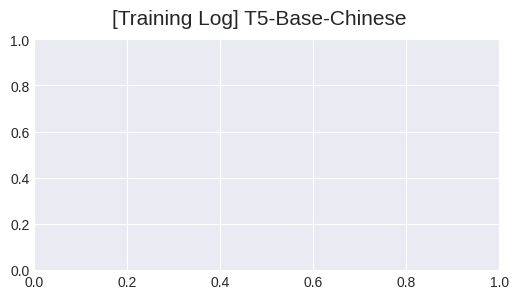

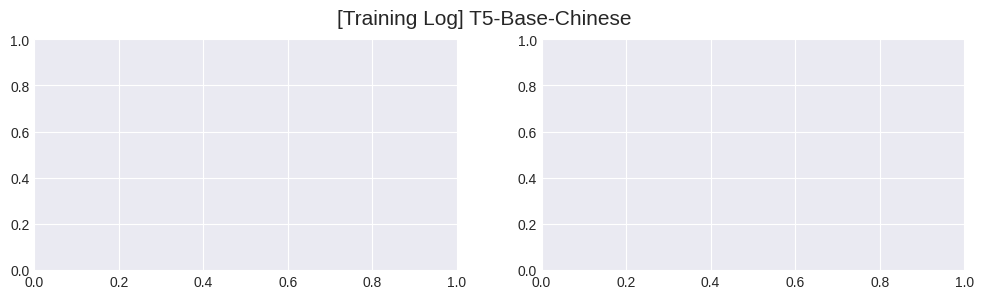

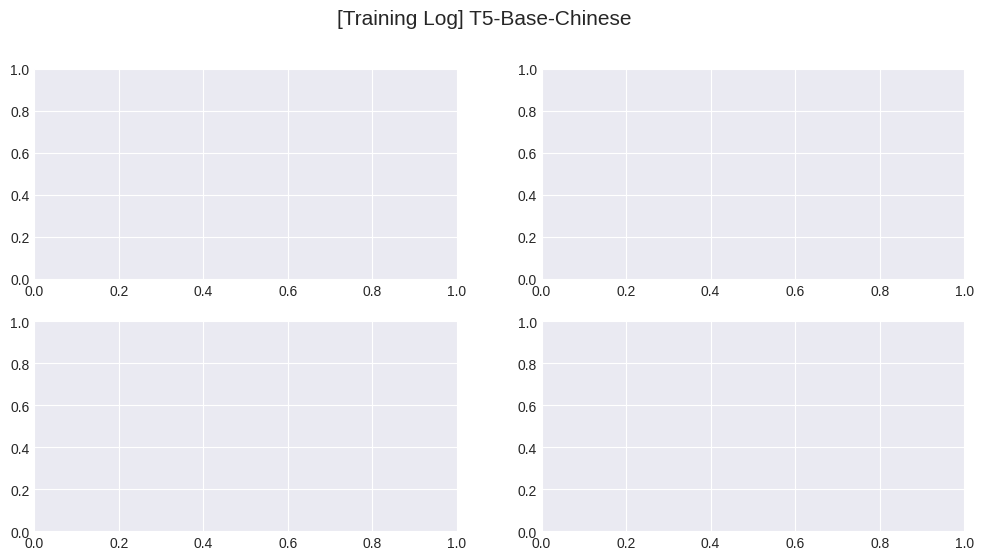

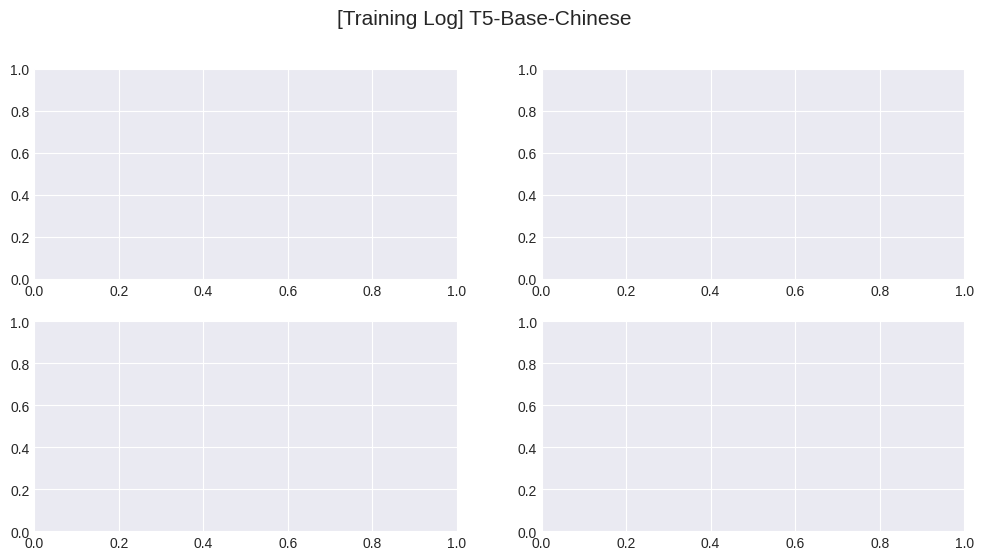

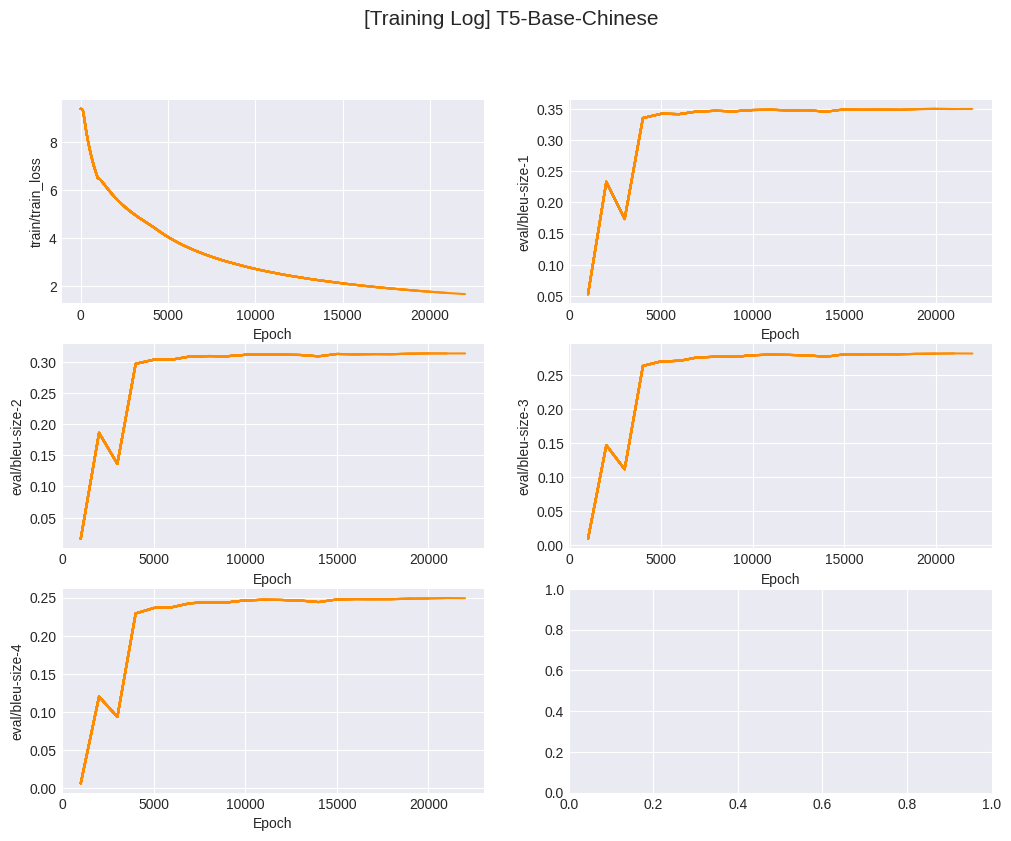

In [ ]:
from rich import print
train()

In [ ]:
from rich import print
from transformers import AutoTokenizer, T5ForConditionalGeneration

device = 'cuda:0'
max_source_seq_len = 256
tokenizer = AutoTokenizer.from_pretrained('./checkpoints/DuReaderQG/model_best/')
model = T5ForConditionalGeneration.from_pretrained('./checkpoints/DuReaderQG/model_best/')
model.to(device).eval()


def inference(qustion: str, context: str):
    """
    inference函数。

    Args:
        qustion (str): 问题
        context (str): 原文
    """
    input_seq = f'问题：{question}{tokenizer.sep_token}原文：{context}'
    inputs = tokenizer(
        text=input_seq,
        truncation=True,
        max_length=max_source_seq_len,
        padding='max_length',
        return_tensors='pt'
    )
    outputs = model.generate(input_ids=inputs["input_ids"].to(device))
    output = tokenizer.decode(outputs[0].cpu().numpy(), skip_special_tokens=True).replace(" ", "")
    print(f'Q: "{qustion}"')
    print(f'C: "{context}"')
    print(f'A: "{output}"')


In [ ]:
question = '中信信用卡白金卡额度是多少'
context= "目前中信银行信用卡额度一般从3000元到五万元不等。中信普卡的额度一般为3000元到10000元之间，中信白金卡额度在一万到五万之间。中信信用卡的取现额度为实际额度的50%。如果信用卡批卡之后，持卡者便就可以查询您的信用额度。"
inference(question, context)


Q: "中信信用卡白金卡额度是多少"

C: 
"目前中信银行信用卡额度一般从3000元到五万元不等。中信普卡的额度一般为3000元到10000元之间，中信白金卡额度在一万到五
万之间。中信信用卡的取现额度为实际额度的50%。如果信用卡批卡之后，持卡者便就可以查询您的信用额度。"

A: "答案:一万到五万"

In [ ]:
question = '治疗宫颈糜烂的最佳时间'
context = '专家指出，宫颈糜烂治疗时间应选在月经干净后3-7日，因为治疗之后宫颈有一定的创面，如赶上月经期易发生感染。因此患者应在月经干净后3天尽快来医院治疗。同时应该注意，术前3天禁同房，有生殖道急性炎症者应治好后才可进行。'
inference(qustion=question, context=context)

Q: "治疗宫颈糜烂的最佳时间"

C: 
"专家指出，宫颈糜烂治疗时间应选在月经干净后3-7日，因为治疗之后宫颈有一定的创面，如赶上月经期易发生感染。因此患者应
在月经干净后3天尽快来医院治疗。同时应该注意，术前3天禁同房，有生殖道急性炎症者应治好后才可进行。"

A: "答案:月经干净后3-7日"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

google_drive_path = '/content/drive/MyDrive/models/DuReaderQG'
local_checkpoint_path = 'checkpoints/DuReaderQG'

shutil.copytree(local_checkpoint_path, google_drive_path)
print(f"模型已成功上传到 {google_drive_path}")


模型已成功上传到 /content/drive/MyDrive/models/DuReaderQG

In [ ]:
!du -sh checkpoints/DuReaderQG

23G	checkpoints/DuReaderQG
